In [108]:
import micropip
await micropip.install('seaborn')
await micropip.install('missingno')
await micropip.install('scipy')
await micropip.install('optuna')
await micropip.install('matplotlib')

import pandas as pd
import joblib
import missingno as msno
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, roc_auc_score,
    brier_score_loss, log_loss
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve, cross_val_score

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (12, 8)
pd.options.mode.chained_assignment = None

In [9]:
def load_data(filepath, make_copy=True):
    df = pd.read_csv(filepath)
    df_copy = df.copy() if make_copy else None
    return df, df_copy

In [10]:
def display_basic_info(df):
    print("=== DATASET INFO ===")
    df.info()
    print("\n=== FIRST 5 ROWS ===")
    display(df.head())
    print("\n=== DESCRIPTIVE STATISTICS ===")
    display(df.describe())
    return df.info(), df.describe()

In [11]:
def analyze_missing_data(df, missing_cols=['CREDIT_SCORE', 'ANNUAL_MILEAGE']):
    print("=== MISSING DATA REPORT ===")
    for col in missing_cols:
        missing_count = df[col].isnull().sum()
        missing_pct = 100 * missing_count / len(df)
        print(f"{col}: {missing_pct:.2f}% ({missing_count}/{len(df)})")
    return {col: df[col].isnull().sum() for col in missing_cols}

In [12]:
def analyze_missingness_mechanism(
    df,
    target_vars=['CREDIT_SCORE', 'ANNUAL_MILEAGE'],
    predictor_vars=['VEHICLE_YEAR', 'DRIVING_EXPERIENCE', 'VEHICLE_TYPE']
):
    results = []
    for target in target_vars:
        for predictor in predictor_vars:
            contingency = pd.crosstab(df[predictor], df[target].isnull())
            chi2, p_value, dof, expected = chi2_contingency(contingency)
            results.append({
                'Target': target,
                'Predictor': predictor,
                'Chi2': chi2,
                'p-value': p_value,
                'Mechanism': 'MAR' if p_value < 0.05 else 'MCAR'
            })
    return pd.DataFrame(results)

In [13]:
def plot_chi2_heatmap(summary_df, figsize=(10, 6)):
    pivot = summary_df.pivot(index='Predictor', columns='Target', values='p-value')
    plt.figure(figsize=figsize)
    sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt='.4f', cbar_kws={'label': 'p-value'})
    plt.title('Missingness Mechanism Test (Chi-Square p-values)')
    plt.tight_layout()
    plt.show()

In [14]:
def encode_ordinal_features(
    df,
    ordinal_mapping=None
):
    if ordinal_mapping is None:
        ordinal_mapping = {
            'DRIVING_EXPERIENCE': {'0-9y': 0, '10-19y': 1, '20-29y': 2, '30y+': 3},
            'EDUCATION': {'none': 0, 'high school': 1, 'university': 2},
            'INCOME': {'poverty': 0, 'working class': 1, 'middle class': 2, 'upper class': 3},
            'VEHICLE_YEAR': {'before 2015': 0, 'after 2015': 1},
            'AGE': {'16-25': 0, '26-39': 1, '40-64': 2, '65+': 3}
        }
    
    for col, mapping in ordinal_mapping.items():
        if col in df.columns:
            df[col] = df[col].map(mapping).astype('int8')
    return df

In [15]:
def encode_binary_features(
    df,
    binary_vars=['GENDER', 'VEHICLE_TYPE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'RACE']
):
    from sklearn.preprocessing import LabelEncoder
    for col in binary_vars:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str)).astype('int8')
    return df

In [16]:
def encode_categorical_features(
    df,
    cat_vars=['RACE']
):
    from sklearn.preprocessing import LabelEncoder
    for col in cat_vars:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str)).astype('int8')
    return df

In [17]:
def optimize_numeric_dtypes(df):
    df['ID'] = df['ID'].astype('int32')
    df['POSTAL_CODE'] = df['POSTAL_CODE'].astype('int32')
    
    count_cols = ['SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'OUTCOME']
    for col in count_cols:
        if col in df.columns:
            df[col] = df[col].astype('int8')
    
    float_cols = ['CREDIT_SCORE', 'ANNUAL_MILEAGE']
    for col in float_cols:
        if col in df.columns:
            df[col] = df[col].astype('float32')
    return df

In [18]:
def drop_missing_values(
    df,
    subset_cols=['CREDIT_SCORE', 'ANNUAL_MILEAGE'],
    check_outcome=True
):
    print(f"Dataset shape before: {df.shape}")
    print(f"Nulls before:\n{df[subset_cols].isnull().sum()}")
    
    df_clean = df.dropna(subset=subset_cols).copy()
    
    dropped = len(df) - len(df_clean)
    print(f"\nRecords dropped: {dropped:,} ({100*dropped/len(df):.1f}%)")
    print(f"Dataset shape after: {df_clean.shape}")
    
    if check_outcome and 'OUTCOME' in df.columns:
        print("\n=== TARGET PRESERVATION ===")
        print(f"Claim rate BEFORE: {df['OUTCOME'].mean():.4f}")
        print(f"Claim rate AFTER:  {df_clean['OUTCOME'].mean():.4f}")
        diff = abs(df['OUTCOME'].mean() - df_clean['OUTCOME'].mean())
        print(f"Difference: {diff:.4f}")
        print("✅ Preserved" if diff < 0.02 else "⚠️ Shifted")
    
    return df_clean

In [19]:
def test_normality(
    df,
    numeric_cols=['CREDIT_SCORE', 'ANNUAL_MILEAGE'],
    sample_size=5000
):
    print("=== NORMALITY TESTS (Shapiro-Wilk & Kolmogorov-Smirnov) ===")
    results = []
    
    for col in numeric_cols:
        x = df[col].dropna().values.astype(float)
        
        x_sample = np.random.choice(x, size=min(sample_size, len(x)), replace=False) if len(x) > sample_size else x
        sh_stat, sh_p = stats.shapiro(x_sample)
        
        x_z = (x - x.mean()) / x.std(ddof=1)
        ks_stat, ks_p = stats.kstest(x_z, 'norm')
        
        results.append({
            'Variable': col,
            'Shapiro_W': sh_stat,
            'Shapiro_p': sh_p,
            'KS_D': ks_stat,
            'KS_p': ks_p,
            'Normality': 'Normal' if sh_p > 0.05 and ks_p > 0.05 else 'Non-normal'
        })
        
        print(f"\n{col}")
        print(f"  Shapiro-Wilk: W={sh_stat:.3f}, p={sh_p:.3g} -> {'Normal' if sh_p>0.05 else 'Non-normal'}")
        print(f"  Kolmogorov-Smirnov: D={ks_stat:.3f}, p={ks_p:.3g} -> {'Normal' if ks_p>0.05 else 'Non-normal'}")
    
    return pd.DataFrame(results)

In [20]:
def plot_diagnostic_plots(
    df,
    numeric_cols=['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']
):
    for col in numeric_cols:
        x = df[col].dropna().values.astype(float)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(col, fontsize=14)
        
        sns.histplot(x, kde=True, ax=axes[0], bins=30)
        axes[0].set_title("Histogram + KDE")
        
        stats.probplot(x, dist="norm", plot=axes[1])
        axes[1].set_title("QQ plot vs Normal")
        
        sns.boxplot(x=x, ax=axes[2])
        axes[2].set_title("Boxplot")
        
        plt.tight_layout()
        plt.show()

In [21]:
def plot_correlation_heatmap(df, target_col='OUTCOME', figsize=(6, 10)):
    num_cols = df.select_dtypes(include=[np.number]).columns
    corr = df[num_cols].corr()
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr[[target_col]].sort_values(target_col, ascending=False),
        annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f"
    )
    plt.title(f"Correlation of Features with {target_col}")
    plt.tight_layout()
    plt.show()
    return corr[[target_col]].sort_values(target_col, ascending=False)

In [22]:
def plot_categorical_distributions(
    df,
    cat_vars=['GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME', 'VEHICLE_YEAR', 'VEHICLE_TYPE'],
    figsize=(5, 5)
):
    for col in cat_vars:
        if col in df.columns:
            counts = df[col].value_counts()
            plt.figure(figsize=figsize)
            counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
            plt.ylabel('')
            plt.title(f'{col} Distribution')
            plt.tight_layout()
            plt.show()

In [23]:
def split_data(
    df,
    target_col='OUTCOME',
    test_size=0.2,
    val_size=0.1,
    random_state=42
):
    from sklearn.model_selection import train_test_split
    
    X = df.drop(columns=[target_col, 'ID'], errors='ignore')
    y = df[target_col]
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size + val_size, random_state=random_state, stratify=y
    )
    
    val_ratio = val_size / (test_size + val_size)
    X_test, X_val, y_test, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp
    )
    
    print(f"Train: {X_train.shape}, Test: {X_test.shape}, Val: {X_val.shape}")
    return X_train, X_test, X_val, y_train, y_test, y_val

In [24]:
def train_logit(X_train, y_train, C=1.0, max_iter=1000, random_state=42):
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(C=C, max_iter=max_iter, random_state=random_state)
    model.fit(X_train, y_train)
    return model

In [25]:
def train_random_forest(
    X_train, y_train,
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=n_jobs
    )
    model.fit(X_train, y_train)
    return model

In [47]:
def train_xgboost(X_train, y_train, **kwargs):
    import xgboost as xgb
    from xgboost import XGBClassifier

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    params = {
        'n_estimators': 100,
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }

    params.update(kwargs)

    # Use XGBClassifier instead of xgb.train for compatibility
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    return model


In [48]:
def evaluate_model(model, X_test, y_test, model_name="Model", is_xgb=False, threshold=0.5):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    if is_xgb:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)  # ADDED: threshold parameter
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }

    print(f"\n=== {model_name} PERFORMANCE ===")
    if is_xgb:
        print(f"Threshold   : {threshold:.4f}")  # ADDED: show threshold
    for k, v in metrics.items():
        if k != 'Model':
            print(f"{k:12}: {v:.4f}")

    return metrics

In [28]:
def compare_models(metrics_list):
    comparison_df = pd.DataFrame(metrics_list)
    comparison_df = comparison_df.set_index('Model')
    
    print("\n" + "="*70)
    print("MODEL COMPARISON")
    print("="*70)
    display(comparison_df.round(4))
    
    comparison_df.plot(kind='bar', figsize=(12, 6), rot=0)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    return comparison_df

In [58]:
def optimize_xgboost_optuna(
    X_train, y_train, X_val=None, y_val=None,
    n_trials=100,
    direction='maximize',
    cv_folds=10,
    use_cv=True,
    random_state=42,
    n_jobs=-1,
    overfitting_penalty=0.1
):
    import optuna
    import numpy as np
    from xgboost import XGBClassifier
    from sklearn.model_selection import cross_val_predict, StratifiedKFold
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 12),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0.01, 15),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
            'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
            'random_state': random_state,
            'eval_metric': 'logloss',
            'use_label_encoder': False
        }

        threshold = trial.suggest_float('threshold', 0.1, 0.9)
        model = XGBClassifier(**params)

        if use_cv:
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

            # Get CV predictions
            y_proba_cv = cross_val_predict(
                model, X_train, y_train,
                cv=cv,
                method='predict_proba',
                n_jobs=n_jobs
            )[:, 1]

            y_pred_cv = (y_proba_cv >= threshold).astype(int)

            # Calculate metrics
            precision_cv = precision_score(y_train, y_pred_cv, zero_division=0)
            recall_cv = recall_score(y_train, y_pred_cv, zero_division=0)
            f1_cv = f1_score(y_train, y_pred_cv, zero_division=0)

            # OVERFITTING CHECK: Train on full training set
            model.fit(X_train, y_train)
            y_proba_train = model.predict_proba(X_train)[:, 1]
            y_pred_train = (y_proba_train >= threshold).astype(int)

            precision_train = precision_score(y_train, y_pred_train, zero_division=0)
            recall_train = recall_score(y_train, y_pred_train, zero_division=0)
            f1_train = f1_score(y_train, y_pred_train, zero_division=0)

            # Calculate overfitting gap
            f1_gap = abs(f1_train - f1_cv)
            precision_gap = abs(precision_train - precision_cv)
            recall_gap = abs(recall_train - recall_cv)
            overfitting_score = (f1_gap + precision_gap + recall_gap) / 3

            # Store diagnostics
            trial.set_user_attr("precision_train", precision_train)
            trial.set_user_attr("precision_cv", precision_cv)
            trial.set_user_attr("recall_train", recall_train)
            trial.set_user_attr("recall_cv", recall_cv)
            trial.set_user_attr("f1_train", f1_train)
            trial.set_user_attr("f1_cv", f1_cv)
            trial.set_user_attr("overfitting_gap", overfitting_score)

            # OBJECTIVE: Maximize F1, penalize overfitting
            score = f1_cv - (overfitting_penalty * overfitting_score)

            # Warn about extreme overfitting
            if overfitting_score > 0.15:
                trial.set_user_attr("warning", "⚠️ HIGH OVERFITTING")

        else:
            if X_val is None or y_val is None:
                raise ValueError("X_val and y_val must be provided when use_cv=False")

            model.fit(X_train, y_train)

            # Train metrics
            y_proba_train = model.predict_proba(X_train)[:, 1]
            y_pred_train = (y_proba_train >= threshold).astype(int)
            precision_train = precision_score(y_train, y_pred_train, zero_division=0)
            recall_train = recall_score(y_train, y_pred_train, zero_division=0)
            f1_train = f1_score(y_train, y_pred_train, zero_division=0)

            # Validation metrics
            y_proba_val = model.predict_proba(X_val)[:, 1]
            y_pred_val = (y_proba_val >= threshold).astype(int)
            precision_val = precision_score(y_val, y_pred_val, zero_division=0)
            recall_val = recall_score(y_val, y_pred_val, zero_division=0)
            f1_val = f1_score(y_val, y_pred_val, zero_division=0)

            # Overfitting check
            f1_gap = abs(f1_train - f1_val)
            precision_gap = abs(precision_train - precision_val)
            recall_gap = abs(recall_train - recall_val)
            overfitting_score = (f1_gap + precision_gap + recall_gap) / 3

            trial.set_user_attr("precision_train", precision_train)
            trial.set_user_attr("precision_val", precision_val)
            trial.set_user_attr("recall_train", recall_train)
            trial.set_user_attr("recall_val", recall_val)
            trial.set_user_attr("f1_train", f1_train)
            trial.set_user_attr("f1_val", f1_val)
            trial.set_user_attr("overfitting_gap", overfitting_score)

            # OBJECTIVE: Maximize F1, penalize overfitting
            score = f1_val - (overfitting_penalty * overfitting_score)

            if overfitting_score > 0.15:
                trial.set_user_attr("warning", "⚠️ HIGH OVERFITTING")

        trial.set_user_attr("best_threshold", threshold)
        return score

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\n" + "="*70)
    print("BEST XGBOOST PARAMETERS (OPTUNA - F1 OPTIMIZED)")
    print("="*70)
    print(f"Best F1 Score: {study.best_value:.4f}")

    print("\n" + "="*70)
    print("OVERFITTING DIAGNOSTICS")
    print("="*70)

    if use_cv:
        print(f"F1 Score (Train): {study.best_trial.user_attrs.get('f1_train', 0):.4f}")
        print(f"F1 Score (CV):    {study.best_trial.user_attrs.get('f1_cv', 0):.4f}")
        print(f"Precision (Train): {study.best_trial.user_attrs.get('precision_train', 0):.4f}")
        print(f"Precision (CV):    {study.best_trial.user_attrs.get('precision_cv', 0):.4f}")
        print(f"Recall (Train):    {study.best_trial.user_attrs.get('recall_train', 0):.4f}")
        print(f"Recall (CV):       {study.best_trial.user_attrs.get('recall_cv', 0):.4f}")
    else:
        print(f"F1 Score (Train): {study.best_trial.user_attrs.get('f1_train', 0):.4f}")
        print(f"F1 Score (Val):   {study.best_trial.user_attrs.get('f1_val', 0):.4f}")
        print(f"Precision (Train): {study.best_trial.user_attrs.get('precision_train', 0):.4f}")
        print(f"Precision (Val):   {study.best_trial.user_attrs.get('precision_val', 0):.4f}")
        print(f"Recall (Train):    {study.best_trial.user_attrs.get('recall_train', 0):.4f}")
        print(f"Recall (Val):      {study.best_trial.user_attrs.get('recall_val', 0):.4f}")

    overfitting_gap = study.best_trial.user_attrs.get('overfitting_gap', 0)
    print(f"\nOverfitting Gap:   {overfitting_gap:.4f}")

    if overfitting_gap < 0.05:
        print("✅ GOOD - No significant overfitting")
    elif overfitting_gap < 0.10:
        print("⚠️  MODERATE - Some overfitting detected")
    else:
        print("🚨 HIGH - Significant overfitting! Consider:")
        print("   • Increase regularization (reg_alpha, reg_lambda)")
        print("   • Reduce max_depth")
        print("   • Increase min_child_weight")
        print("   • More training data")

    if study.best_trial.user_attrs.get('warning'):
        print(f"\n{study.best_trial.user_attrs['warning']}")

    print("\n" + "="*70)
    print("BEST HYPERPARAMETERS")
    print("="*70)
    for k, v in study.best_params.items():
        if k != 'threshold':
            print(f"  {k}: {v}")
    print(f"\nBest Threshold: {study.best_params['threshold']:.4f}")

    best_params_full = {
        k: v for k, v in study.best_params.items() if k != 'threshold'
    }
    best_params_full.update({
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
        'random_state': random_state,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    })

    best_threshold = study.best_params['threshold']

    return best_params_full, best_threshold, study

In [30]:
def plot_xgboost_diagnostics(model, X_train, y_train, X_test, y_test, model_name="XGBoost"):
    """
    Comprehensive diagnostic plots for XGBoost classification model

    Parameters:
    -----------
    model : trained XGBoost model
    X_train, y_train : training data
    X_test, y_test : test data
    model_name : str, name for plot titles
    """

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]

    fig = plt.figure(figsize=(20, 12))

    # ==================== PLOT 1: ROC CURVE ====================
    ax1 = plt.subplot(2, 3, 1)
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold_roc = thresholds_roc[optimal_idx]
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
             label=f'Optimal threshold: {optimal_threshold_roc:.3f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name}: ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    # ==================== PLOT 2: PRECISION-RECALL CURVE ====================
    ax2 = plt.subplot(2, 3, 2)
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')

    baseline = y_test.sum() / len(y_test)
    plt.plot([0, 1], [baseline, baseline], 'k--', lw=2, label=f'Baseline ({baseline:.3f})')

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx_pr = np.argmax(f1_scores)
    plt.plot(recall[optimal_idx_pr], precision[optimal_idx_pr], 'ro', markersize=10,
             label=f'Best F1={f1_scores[optimal_idx_pr]:.3f} @ t={thresholds_pr[optimal_idx_pr]:.3f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'{model_name}: Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="best")
    plt.grid(alpha=0.3)

    # ==================== PLOT 3: CONFUSION MATRIX ====================
    ax3 = plt.subplot(2, 3, 3)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, 
                cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white')

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(f'{model_name}: Confusion Matrix', fontsize=14, fontweight='bold')

    tn, fp, fn, tp = cm.ravel()
    plt.text(1.5, -0.3, f'Accuracy: {(tp+tn)/(tp+tn+fp+fn):.3f}\n'
                        f'Precision: {tp/(tp+fp):.3f}\n'
                        f'Recall: {tp/(tp+fn):.3f}\n'
                        f'F1: {2*tp/(2*tp+fp+fn):.3f}',
             transform=ax3.transAxes, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # ==================== PLOT 4: FEATURE IMPORTANCE ====================
    ax4 = plt.subplot(2, 3, 4)

    try:
        feature_importance = model.feature_importances_
        if hasattr(X_train, 'columns'):
            feature_names = X_train.columns
        else:
            feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=True).tail(20)

        plt.barh(range(len(importance_df)), importance_df['importance'], color='steelblue')
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Importance Score', fontsize=12)
        plt.title(f'{model_name}: Top 20 Feature Importances', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
    except:
        plt.text(0.5, 0.5, 'Feature importance not available', 
                ha='center', va='center', fontsize=12)

    # ==================== PLOT 5: CALIBRATION CURVE ====================
    ax5 = plt.subplot(2, 3, 5)

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_proba, n_bins=10, strategy='uniform'
    )

    plt.plot(mean_predicted_value, fraction_of_positives, 's-', 
             color='red', lw=2, label=f'{model_name}')
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect calibration')

    brier = brier_score_loss(y_test, y_pred_proba)
    plt.text(0.05, 0.95, f'Brier Score: {brier:.4f}', 
             transform=ax5.transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.xlabel('Mean Predicted Probability', fontsize=12)
    plt.ylabel('Fraction of Positives', fontsize=12)
    plt.title(f'{model_name}: Calibration Curve', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)

    # ==================== PLOT 6: PREDICTION DISTRIBUTION ====================
    ax6 = plt.subplot(2, 3, 6)

    plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.6, color='blue', 
             label='Actual Negative', density=True)
    plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.6, color='red', 
             label='Actual Positive', density=True)

    plt.axvline(0.5, color='black', linestyle='--', lw=2, label='Default threshold (0.5)')
    plt.axvline(optimal_threshold_roc, color='green', linestyle='--', lw=2, 
                label=f'Optimal threshold ({optimal_threshold_roc:.3f})')

    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title(f'{model_name}: Prediction Distribution', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ==================== PRINT DIAGNOSTIC SUMMARY ====================
    print("\n" + "="*80)
    print(f"{model_name.upper()} DIAGNOSTIC SUMMARY")
    print("="*80)

    print("\n1. CLASSIFICATION METRICS:")
    print("-" * 80)
    print(classification_report(y_test, y_pred, digits=4))

    print("\n2. PROBABILITY METRICS:")
    print("-" * 80)
    print(f"ROC-AUC Score:           {roc_auc:.4f}")
    print(f"Average Precision (AP):  {avg_precision:.4f}")
    print(f"Brier Score:             {brier:.4f} (lower is better)")
    print(f"Log Loss:                {log_loss(y_test, y_pred_proba):.4f} (lower is better)")

    print("\n3. OPTIMAL THRESHOLDS:")
    print("-" * 80)
    print(f"ROC-based threshold:     {optimal_threshold_roc:.4f} (max TPR-FPR)")
    print(f"PR-based threshold:      {thresholds_pr[optimal_idx_pr]:.4f} (max F1)")
    print(f"Current threshold:       0.5000 (default)")

    print("\n4. CLASS DISTRIBUTION:")
    print("-" * 80)
    print(f"Training set:  Negative={sum(y_train==0)} ({sum(y_train==0)/len(y_train)*100:.1f}%), "
          f"Positive={sum(y_train==1)} ({sum(y_train==1)/len(y_train)*100:.1f}%)")
    print(f"Test set:      Negative={sum(y_test==0)} ({sum(y_test==0)/len(y_test)*100:.1f}%), "
          f"Positive={sum(y_test==1)} ({sum(y_test==1)/len(y_test)*100:.1f}%)")

    print("\n5. OVERFITTING CHECK:")
    print("-" * 80)
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    test_auc = roc_auc
    print(f"Training AUC:   {train_auc:.4f}")
    print(f"Test AUC:       {test_auc:.4f}")
    print(f"Difference:     {abs(train_auc - test_auc):.4f}")
    if abs(train_auc - test_auc) > 0.05:
        print("⚠️  WARNING: Possible overfitting (AUC gap > 0.05)")
    else:
        print("✅ No significant overfitting detected")

    return {
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'brier_score': brier,
        'optimal_threshold_roc': optimal_threshold_roc,
        'optimal_threshold_pr': thresholds_pr[optimal_idx_pr],
        'confusion_matrix': cm
    }

In [83]:
def plot_learning_curves(model, X_train, y_train, cv=5, scoring='roc_auc'):
    """
    Plot learning curves for ANY model (including calibrated wrappers)
    """
    from sklearn.model_selection import learning_curve
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Handle calibrated wrapper vs regular model
    if hasattr(model, 'get_uncalibrated_proba'):
        # Use raw XGBoost predictions for learning curves
        def scorer(estimator, X, y):
            raw_proba = estimator.xgb_model.predict_proba(X)[:, 1]
            return raw_proba  # Return probabilities for roc_auc
    else:
        # Regular model
        def scorer(estimator, X, y):
            return estimator.predict_proba(X)[:, 1]
    
    # Calculate learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, 
        cv=cv,
        scoring=scoring,  # 'roc_auc', 'precision', etc.
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(12, 8))
    plt.plot(train_sizes, train_mean, 'o-', color='red', linewidth=2, label='Training AUC', markersize=8)
    plt.plot(train_sizes, val_mean, 'o-', color='green', linewidth=2, label='CV AUC', markersize=8)

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.2, color='red')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.2, color='green')

    plt.xlabel('Training Set Size (%)', fontsize=14)
    plt.ylabel(f'{scoring.upper()} Score', fontsize=14)
    plt.title('Learning Curves: Bias-Variance Diagnosis', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)

    # Final gap analysis
    final_gap = train_mean[-1] - val_mean[-1]
    plt.text(0.02, 0.98, f'Final Gap: {final_gap:.4f}\\n'
                          f'Train: {train_mean[-1]:.4f}\\n'
                          f'CV: {val_mean[-1]:.4f}',
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Comprehensive diagnosis
    print("\n" + "="*80)
    print("🧠 LEARNING CURVE DIAGNOSIS")
    print("="*80)
    
    print(f"Final Train AUC: {train_mean[-1]:.4f}")
    print(f"Final CV AUC:    {val_mean[-1]:.4f}")
    print(f"Gap:            {final_gap:.4f}")
    print(f"CV Std:         {val_scores.std():.4f}")
    
    if final_gap > 0.10:
        print("\n🚨 HIGH VARIANCE (OVERFITTING)")
        print("   Symptoms:")
        print("   • Large gap (>0.10)")
        print("   • Train >> CV")
        print("\n   Fixes:")
        print("   • Increase reg_alpha/reg_lambda")
        print("   • Reduce max_depth")
        print("   • Add dropout (subsample/colsample)")
        print("   • More training data")
        
    elif val_mean[-1] < 0.80:
        print("\n🚨 HIGH BIAS (UNDERFITTING)")
        print("   Symptoms:")
        print("   • Both curves low (<0.80)")
        print("   • Don't converge to high values")
        print("\n   Fixes:")
        print("   • Increase max_depth")
        print("   • Reduce regularization")
        print("   • Add polynomial features")
        print("   • Ensemble multiple models")
        
    elif final_gap < 0.05 and val_mean[-1] > 0.85:
        print("\n✅ PERFECT - Optimal bias-variance tradeoff!")
        print("   Ready for production")
        
    else:
        print("\n⚠️  MODERATE - Acceptable but room for improvement")
        print("   Gap reasonable, CV performance good")
    
    print("\nCV Stability: ", end="")
    if val_scores.std() < 0.02:
        print("✅ EXCELLENT (low variance)")
    elif val_scores.std() < 0.05:
        print("⚠️  GOOD (stable enough)")
    else:
        print("🚨 POOR (high variance - unstable)")
    
    return {
        'final_gap': final_gap,
        'train_auc': train_mean[-1],
        'cv_auc': val_mean[-1],
        'cv_std': val_scores.std()
    }

# Multiple scorings
def plot_learning_curves_multi(model, X_train, y_train, cv=5):
    """Plot learning curves for multiple metrics"""
    scorings = ['roc_auc', 'precision', 'recall']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, scoring in enumerate(scorings):
        results = plot_learning_curves(model, X_train, y_train, cv=cv, scoring=scoring)
        plt.close()  # Close individual plot
        
        # Plot on subplot (simplified version)
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train, cv=cv, scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )
        axes[i].plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train')
        axes[i].plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='CV')
        axes[i].fill_between(train_sizes, 
                           np.mean(train_scores,1)-np.std(train_scores,1),
                           np.mean(train_scores,1)+np.std(train_scores,1), alpha=0.2)
        axes[i].fill_between(train_sizes, 
                           np.mean(val_scores,1)-np.std(val_scores,1),
                           np.mean(val_scores,1)+np.std(val_scores,1), alpha=0.2)
        axes[i].set_title(f'{scoring.replace("_", " ").title()}')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("✅ FIXED LEARNING CURVES FUNCTION READY!")
print("\n📋 USAGE:")
print("""
# For your production model:
results = plot_learning_curves(production_model, X_train, y_train, cv=5)

# Multiple metrics:
plot_learning_curves_multi(production_model, X_train, y_train, cv=5)
""")

with open('learning_curves_fixed.py', 'w') as f:
    f.write(learning_curves_fixed_code)

print("\n✅ SAVED: learning_curves_fixed.py")
</parameter>
</xai:function_call>


<class '_IncompleteInputError'>: incomplete input (<ipython-input-83-c3b20ab3a842>, line 147)

In [32]:
def plot_threshold_analysis(model, X_test, y_test):
    """
    Comprehensive threshold tuning analysis
    """
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    thresholds = np.linspace(0.01, 0.99, 100)

    metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': [],
        'fpr': [],
        'fnr': []
    }

    for t in thresholds:
        y_pred_t = (y_pred_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        metrics['accuracy'].append(accuracy)
        metrics['fpr'].append(fpr)
        metrics['fnr'].append(fnr)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left plot: Main metrics
    ax1.plot(thresholds, metrics['precision'], label='Precision', linewidth=2)
    ax1.plot(thresholds, metrics['recall'], label='Recall', linewidth=2)
    ax1.plot(thresholds, metrics['f1'], label='F1 Score', linewidth=2)
    ax1.plot(thresholds, metrics['accuracy'], label='Accuracy', linewidth=2)

    best_f1_idx = np.argmax(metrics['f1'])
    ax1.axvline(thresholds[best_f1_idx], color='red', linestyle='--', 
                label=f'Best F1 @ {thresholds[best_f1_idx]:.3f}')
    ax1.axvline(0.5, color='gray', linestyle=':', label='Default (0.5)')

    ax1.set_xlabel('Threshold', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Threshold vs Performance Metrics', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)

    # Right plot: Error rates
    ax2.plot(thresholds, metrics['fpr'], label='False Positive Rate', linewidth=2, color='red')
    ax2.plot(thresholds, metrics['fnr'], label='False Negative Rate', linewidth=2, color='blue')

    intersection_idx = np.argmin(np.abs(np.array(metrics['fpr']) - np.array(metrics['fnr'])))
    ax2.axvline(thresholds[intersection_idx], color='green', linestyle='--',
                label=f'Equal Error Rate @ {thresholds[intersection_idx]:.3f}')

    ax2.set_xlabel('Threshold', fontsize=12)
    ax2.set_ylabel('Error Rate', fontsize=12)
    ax2.set_title('Threshold vs Error Rates', fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("THRESHOLD RECOMMENDATIONS")
    print("="*80)
    print(f"Best F1 threshold:      {thresholds[best_f1_idx]:.4f} (F1={metrics['f1'][best_f1_idx]:.4f})")
    print(f"Equal error rate:       {thresholds[intersection_idx]:.4f} (FPR=FNR={metrics['fpr'][intersection_idx]:.4f})")
    print(f"High precision (0.9+):  {thresholds[np.where(np.array(metrics['precision']) >= 0.9)[0][0]]:.4f}")
    print(f"High recall (0.9+):     {thresholds[np.where(np.array(metrics['recall']) >= 0.9)[0][-1]]:.4f}")

In [33]:
def plot_feature_importance(model, feature_names, max_num_features=15, figsize=(10, 8)):
    import xgboost as xgb
    
    fig, ax = plt.subplots(figsize=figsize)
    xgb.plot_importance(model, ax=ax, max_num_features=max_num_features, importance_type='weight')
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()

In [67]:
def diagnose_calibration(model, X_train, y_train, X_test, y_test):
    """Diagnose calibration issues"""
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Calibration metrics
    brier_train = brier_score_loss(y_train, y_train_proba)
    brier_test = brier_score_loss(y_test, y_test_proba)
    logloss_train = log_loss(y_train, y_train_proba)
    logloss_test = log_loss(y_test, y_test_proba)

    print("CALIBRATION DIAGNOSTICS")
    print("="*50)
    print(f"Brier Score - Train: {brier_train:.4f}, Test: {brier_test:.4f}")
    print(f"Log Loss    - Train: {logloss_train:.4f}, Test: {logloss_test:.4f}")
    print(f"Gap (Train-Test): Brier={brier_train-brier_test:.4f}, LogLoss={logloss_train-logloss_test:.4f}")

    return y_train_proba, y_test_proba

In [68]:
def fix_calibration_underestimation(model, X_train, y_train, X_test, y_test, method='isotonic'):
    """
    Fix underestimation with calibration methods
    """

    print(f"\nCALIBRATION FIX: {method.upper()}")
    print("="*50)

    # Method 1: Isotonic Regression (non-parametric, best for underestimation)
    if method == 'isotonic':
        iso = IsotonicRegression(out_of_bounds='clip')
        y_train_proba = model.predict_proba(X_train)[:, 1]
        iso.fit(y_train_proba, y_train)

        # Calibrate test predictions
        y_calib_proba = iso.predict(model.predict_proba(X_test)[:, 1])

    # Method 2: Platt Scaling (sigmoid fit)
    elif method == 'platt':
        calib_model = CalibratedClassifierCV(
            model, method='sigmoid', cv='prefit'
        )
        calib_model.fit(X_train, y_train)
        y_calib_proba = calib_model.predict_proba(X_test)[:, 1]

    # Method 3: Beta Calibration (more robust than Platt)
    elif method == 'beta':
        from sklearn.calibration import _calibration
        beta_calib = CalibratedClassifierCV(
            model, method='sigmoid', cv=5
        )
        beta_calib.fit(X_train, y_train)
        y_calib_proba = beta_calib.predict_proba(X_test)[:, 1]

    # Method 4: Simple probability shift (quick fix)
    elif method == 'shift':
        y_train_proba = model.predict_proba(X_train)[:, 1]
        # Shift probabilities up by 0.1 (adjust based on your calibration curve)
        shift_amount = 0.08  # Tune this based on your curve
        y_calib_proba = np.clip(model.predict_proba(X_test)[:, 1] + shift_amount, 0, 1)

    # Evaluate improvement
    brier_original = brier_score_loss(y_test, model.predict_proba(X_test)[:, 1])
    brier_calib = brier_score_loss(y_test, y_calib_proba)
    print(f"Brier Score Improvement: {brier_original:.4f} → {brier_calib:.4f} ({(1-brier_calib/brier_original)*100:.1f}% better)")

    # Plot before/after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Original calibration
    frac_pos_orig, mean_pred_orig = calibration_curve(
        y_test, model.predict_proba(X_test)[:, 1], n_bins=10
    )
    ax1.plot(mean_pred_orig, frac_pos_orig, "s-", label="Original")
    ax1.plot([0, 1], [0, 1], "k:", label="Perfect")
    ax1.set_title("Before Calibration")
    ax1.legend()

    # Calibrated calibration
    frac_pos_calib, mean_pred_calib = calibration_curve(y_test, y_calib_proba, n_bins=10)
    ax2.plot(mean_pred_calib, frac_pos_calib, "o-", label="Calibrated")
    ax2.plot([0, 1], [0, 1], "k:", label="Perfect")
    ax2.set_title(f"After {method} Calibration")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return y_calib_proba

In [89]:
def complete_calibration_pipeline(model, X_train, y_train, X_test, y_test):
    """
    Complete calibration fix with recommendations
    """
    print("COMPLETE CALIBRATION PIPELINE")
    print("="*50)

    # 1. Diagnose
    diagnose_calibration(model, X_train, y_train, X_test, y_test)

    # 2. Try all methods and pick best
    methods = ['isotonic', 'platt', 'shift']
    best_method = None
    best_brier = float('inf')
    results = {}

    for method in methods:
        y_calib = fix_calibration_underestimation(
            model, X_train, y_train, X_test, y_test, method=method
        )
        brier = brier_score_loss(y_test, y_calib)
        results[method] = brier

        if brier < best_brier:
            best_brier = brier
            best_method = method

    print("\n" + "="*50)
    print("BEST CALIBRATION METHOD:")
    print(f"{best_method.upper()}: Brier = {best_brier:.4f}")

    # 3. Train final calibrated model
    if best_method == 'isotonic':
        final_calib = IsotonicRegression(out_of_bounds='clip')
        final_calib.fit(model.predict_proba(X_train)[:, 1], y_train)
        final_y_calib = final_calib.predict(model.predict_proba(X_test)[:, 1])

    elif best_method == 'platt':
        final_calib = CalibratedClassifierCV(model, method='sigmoid', cv=5)
        final_calib.fit(X_train, y_train)
        final_y_calib = final_calib.predict_proba(X_test)[:, 1]

    return final_calib, final_y_calib, results

In [100]:
def analyze_prediction_errors(model, X_train, X_test, y_test, feature_names=None, threshold=0.549):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    if feature_names is None:
        feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature_{i}' for i in range(X_test.shape[1])]

    fp_mask = (y_test == 0) & (y_pred == 1)
    fn_mask = (y_test == 1) & (y_pred == 0)
    tp_mask = (y_test == 1) & (y_pred == 1)
    tn_mask = (y_test == 0) & (y_pred == 0)

    print("="*80)
    print("ERROR ANALYSIS: FALSE POSITIVES & FALSE NEGATIVES")
    print("="*80)

    print(f"\nFalse Positives: {fp_mask.sum()} ({fp_mask.sum()/len(y_test)*100:.1f}%)")
    print(f"False Negatives: {fn_mask.sum()} ({fn_mask.sum()/len(y_test)*100:.1f}%)")
    print(f"True Positives:  {tp_mask.sum()} ({tp_mask.sum()/len(y_test)*100:.1f}%)")
    print(f"True Negatives:  {tn_mask.sum()} ({tn_mask.sum()/len(y_test)*100:.1f}%)")

    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    print("\n" + "="*80)
    print("FALSE POSITIVE ANALYSIS (Legitimate customers flagged)")
    print("="*80)
    fp_features = X_test_df[fp_mask]
    print(fp_features.describe().T[['mean', 'std', '50%']])

    print("\n" + "="*80)
    print("FALSE NEGATIVE ANALYSIS (Fraud missed)")
    print("="*80)
    fn_features = X_test_df[fn_mask]
    tn_features = X_test_df[tn_mask]
    print(fn_features.describe().T[['mean', 'std', '50%']])

    print("\n" + "="*80)
    print("COMPARISON: FP vs TP (Why did we flag them wrongly?)")
    print("="*80)
    tp_features = X_test_df[tp_mask]
    comparison = pd.DataFrame({
        'FP_Mean': fp_features.mean(),
        'TP_Mean': tp_features.mean(),
        'Difference': fp_features.mean() - tp_features.mean(),
        'FP_Std': fp_features.std(),
        'TP_Std': tp_features.std()
    }).sort_values('Difference', key=abs, ascending=False)
    print(comparison.head(10))

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Error Analysis: Feature Distributions', fontsize=16, fontweight='bold')

    top_features = comparison.head(6).index

    for idx, feature in enumerate(top_features):
        ax = axes[idx // 3, idx % 3]

        ax.hist(X_test_df[tn_mask][feature], bins=20, alpha=0.4, label='TN', color='green')
        ax.hist(X_test_df[fp_mask][feature], bins=20, alpha=0.4, label='FP', color='red')
        ax.hist(X_test_df[tp_mask][feature], bins=20, alpha=0.4, label='TP', color='blue')
        ax.hist(X_test_df[fn_mask][feature], bins=20, alpha=0.4, label='FN', color='orange')

        ax.set_title(f'{feature}', fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("PROBABILITY DISTRIBUTION BY ERROR TYPE")
    print("="*80)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(y_proba[fp_mask], bins=20, alpha=0.7, color='red', edgecolor='black')
    plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('False Positives: Probability Distribution', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(y_proba[fn_mask], bins=20, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('False Negatives: Probability Distribution', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nFP Probability Range: [{y_proba[fp_mask].min():.3f} - {y_proba[fp_mask].max():.3f}]")
    print(f"FN Probability Range: [{y_proba[fn_mask].min():.3f} - {y_proba[fn_mask].max():.3f}]")

    return {
        'fp_features': fp_features,
        'fn_features': fn_features,
        'tp_features': tp_features,
        'tn_features': tn_features,
        'comparison': comparison
    }

In [93]:
# ============================================================================
# CELL 2: SHAP VALUES - EXPLAINABILITY (CRITICAL!)
# ============================================================================

def analyze_shap_values(model, X_train, X_test, y_test):
    import shap
    import matplotlib.pyplot as plt

    print("Computing SHAP values (may take 1-2 minutes)...")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    print("\n" + "="*80)
    print("SHAP ANALYSIS: MODEL EXPLAINABILITY")
    print("="*80)

    print("\n1. GLOBAL FEATURE IMPORTANCE (Mean |SHAP|)")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n2. FEATURE IMPACT DIRECTION (Beeswarm Plot)")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title('SHAP Summary Plot (Red=High Feature Value, Blue=Low)', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n3. TOP 3 FEATURE DEPENDENCE PLOTS")

    if hasattr(X_test, 'columns'):
        feature_names = X_test.columns
    else:
        feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    top_3_idx = np.argsort(mean_abs_shap)[-3:][::-1]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, idx in enumerate(top_3_idx):
        shap.dependence_plot(
            idx, shap_values, X_test, 
            ax=axes[i], show=False
        )
        axes[i].set_title(f'{feature_names[idx]}', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n4. EXAMPLE: WHY DID MODEL FLAG THIS CUSTOMER?")
    fp_mask = (y_test == 0) & ((model.predict_proba(X_test)[:, 1] >= 0.549).astype(int) == 1)

    if fp_mask.sum() > 0:
        fp_idx = np.where(fp_mask)[0][0]

        plt.figure(figsize=(12, 3))
        shap.force_plot(
            explainer.expected_value, 
            shap_values[fp_idx], 
            X_test.iloc[fp_idx] if hasattr(X_test, 'iloc') else X_test[fp_idx],
            matplotlib=True,
            show=False
        )
        plt.title(f'False Positive Explanation (Index {fp_idx})', fontweight='bold')
        plt.tight_layout()
        plt.show()

    return explainer, shap_values

In [111]:
def explain_single_prediction(model, X_test, idx, threshold=0.549, top_features=10):
    """
    FIXED: Manual SHAP-like explanation for single prediction
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    # FIX: Handle both DataFrame and array
    if hasattr(X_test, 'iloc'):
        sample = X_test.iloc[idx].values.reshape(1, -1)
        feature_names = X_test.columns.tolist()
    else:
        sample = X_test[idx].reshape(1, -1)
        feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]
    
    proba = model.predict_proba(sample)[0, 1]
    pred = 1 if proba >= threshold else 0
    
    feature_importance = model.feature_importances_
    
    # Sort by importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance,
        'value': X_test.iloc[idx] if hasattr(X_test, 'iloc') else X_test[idx]
    }).sort_values('importance', ascending=False)
    
    print(f"Prediction {idx}: Proba={proba:.3f} → {'CLAIM' if pred==1 else 'NO CLAIM'}")
    print("\\nTop 10 Features Driving This Decision:")
    print(importance_df.head(10)[['feature', 'importance', 'value']].round(3))
    
    # Plot
    plt.figure(figsize=(10, 8))
    top10 = importance_df.head(10)
    colors = ['red' if i < 5 else 'blue' for i in range(10)]
    plt.barh(range(len(top10)), top10['importance'], color=colors)
    plt.yticks(range(len(top10)), [f"{row.feature}" for _, row in top10.iterrows()])
    plt.xlabel('Feature Importance')
    plt.title(f'Top Features for Prediction {idx} (Proba={proba:.3f})')
    plt.tight_layout()
    plt.show()
    
    return importance_df.head(10)

In [116]:
# ============================================================================
# CELL 3: BUSINESS METRICS - COST-BENEFIT & RISK STRATIFICATION
# ============================================================================

def business_impact_analysis(model, X_test, y_test, threshold=0.549):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    y_proba = model.predict_proba(X_test)[:, 1]

    print("="*80)
    print("BUSINESS IMPACT ANALYSIS")
    print("="*80)

    print("\n1. COST-BENEFIT ANALYSIS")
    print("-"*80)

    cost_fp = 150
    cost_fn = 8000
    benefit_tp = 5000

    thresholds = np.linspace(0.01, 0.99, 100)
    net_profit = []
    precision_list = []
    recall_list = []

    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

        profit = (tp * benefit_tp) - (fp * cost_fp) - (fn * cost_fn)
        net_profit.append(profit)

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision_list.append(prec)
        recall_list.append(rec)

    optimal_idx = np.argmax(net_profit)
    optimal_business_threshold = thresholds[optimal_idx]
    max_profit = net_profit[optimal_idx]

    current_profit_idx = np.argmin(np.abs(thresholds - threshold))
    current_profit = net_profit[current_profit_idx]

    print(f"Cost per False Positive:  ${cost_fp:,}")
    print(f"Cost per False Negative:  ${cost_fn:,}")
    print(f"Benefit per True Positive: ${benefit_tp:,}")
    print(f"\nCurrent Threshold ({threshold}):")
    print(f"  Net Profit: ${current_profit:,.2f}")
    print(f"  Precision: {precision_list[current_profit_idx]:.3f}")
    print(f"  Recall: {recall_list[current_profit_idx]:.3f}")
    print(f"\nOptimal Business Threshold ({optimal_business_threshold:.3f}):")
    print(f"  Net Profit: ${max_profit:,.2f}")
    print(f"  Improvement: ${max_profit - current_profit:,.2f} ({(max_profit/current_profit - 1)*100:.1f}%)")
    print(f"  Precision: {precision_list[optimal_idx]:.3f}")
    print(f"  Recall: {recall_list[optimal_idx]:.3f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(thresholds, net_profit, linewidth=2, color='green')
    ax1.axvline(threshold, color='blue', linestyle='--', linewidth=2, 
                label=f'Current ({threshold}): ${current_profit:,.0f}')
    ax1.axvline(optimal_business_threshold, color='red', linestyle='--', linewidth=2,
                label=f'Optimal ({optimal_business_threshold:.3f}): ${max_profit:,.0f}')
    ax1.set_xlabel('Threshold', fontsize=12)
    ax1.set_ylabel('Net Profit ($)', fontsize=12)
    ax1.set_title('Cost-Benefit Analysis: Profit vs Threshold', fontweight='bold', fontsize=14)
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.plot(thresholds, precision_list, label='Precision', linewidth=2, color='blue')
    ax2.plot(thresholds, recall_list, label='Recall', linewidth=2, color='orange')
    ax2.axvline(threshold, color='gray', linestyle=':', label=f'Current ({threshold})')
    ax2.axvline(optimal_business_threshold, color='red', linestyle='--', 
                label=f'Optimal Business ({optimal_business_threshold:.3f})')
    ax2.set_xlabel('Threshold', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('Precision/Recall at Business Optimal Threshold', fontweight='bold', fontsize=14)
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n2. RISK STRATIFICATION")
    print("-"*80)

    risk_tiers = pd.qcut(y_proba, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')

    tier_analysis = pd.DataFrame({
        'Risk_Tier': risk_tiers,
        'Actual_Claim': y_test
    }).groupby('Risk_Tier').agg({
        'Actual_Claim': ['count', 'sum', 'mean']
    })

    tier_analysis.columns = ['Count', 'Claims', 'Claim_Rate']
    print(tier_analysis)

    plt.figure(figsize=(10, 6))
    tier_analysis['Claim_Rate'].plot(kind='bar', color='steelblue', edgecolor='black', linewidth=1.5)
    plt.xlabel('Risk Tier', fontsize=12)
    plt.ylabel('Actual Claim Rate', fontsize=12)
    plt.title('Risk Stratification: Model Performance by Tier', fontweight='bold', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n3. PREMIUM PRICING SIMULATION")
    print("-"*80)

    base_premium = 1200
    avg_claim_amount = 8000

    premium = base_premium * (1 + y_proba * 2)

    total_premiums = premium.sum()
    total_claims = (y_test * avg_claim_amount).sum()
    profit = total_premiums - total_claims
    loss_ratio = total_claims / total_premiums

    print(f"Base Premium:      ${base_premium:,}")
    print(f"Avg Claim Amount:  ${avg_claim_amount:,}")
    print(f"\nTotal Premiums:    ${total_premiums:,.2f}")
    print(f"Total Claims Paid: ${total_claims:,.2f}")
    print(f"Net Profit:        ${profit:,.2f}")
    print(f"Loss Ratio:        {loss_ratio:.2%} (target: <75%)")

    if loss_ratio < 0.75:
        print("✅ PROFITABLE - Loss ratio under industry target!")
    else:
        print("⚠️  HIGH LOSS RATIO - Consider premium adjustments")

    return {
        'optimal_threshold': optimal_business_threshold,
        'max_profit': max_profit,
        'current_profit': current_profit,
        'tier_analysis': tier_analysis,
        'loss_ratio': loss_ratio
    }

In [95]:
# ============================================================================
# CELL 4: PERMUTATION IMPORTANCE
# ============================================================================

def compute_permutation_importance(model, X_test, y_test):
    from sklearn.inspection import permutation_importance
    import pandas as pd
    import matplotlib.pyplot as plt

    print("="*80)
    print("PERMUTATION IMPORTANCE (True Predictive Power)")
    print("="*80)
    print("\nComputing (may take 30-60 seconds)...")

    perm_importance = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        scoring='roc_auc',
        n_jobs=-1
    )

    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature_{i}' for i in range(X_test.shape[1])]

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(importance_df.head(15).to_string(index=False))

    plt.figure(figsize=(10, 8))
    top_20 = importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['importance'], xerr=top_20['std'], 
             color='steelblue', edgecolor='black', linewidth=1)
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Permutation Importance (AUC Drop)', fontsize=12)
    plt.title('Permutation Importance: Top 20 Features', fontweight='bold', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return importance_df

In [96]:
# ============================================================================
# CELL 5: BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================================

def bootstrap_confidence_intervals(model, X_test, y_test, n_iterations=1000):
    from sklearn.utils import resample
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt

    print("="*80)
    print("BOOTSTRAP CONFIDENCE INTERVALS (Uncertainty Estimation)")
    print("="*80)
    print(f"\nRunning {n_iterations} bootstrap iterations...")

    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.549).astype(int)

    bootstrap_results = {
        'auc': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for i in range(n_iterations):
        indices = resample(range(len(y_test)), random_state=i)
        y_test_boot = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]
        y_pred_boot = y_pred[indices]
        y_proba_boot = y_proba[indices]

        bootstrap_results['auc'].append(roc_auc_score(y_test_boot, y_proba_boot))
        bootstrap_results['precision'].append(precision_score(y_test_boot, y_pred_boot, zero_division=0))
        bootstrap_results['recall'].append(recall_score(y_test_boot, y_pred_boot, zero_division=0))
        bootstrap_results['f1'].append(f1_score(y_test_boot, y_pred_boot, zero_division=0))

    print("\nRESULTS WITH 95% CONFIDENCE INTERVALS:")
    print("-"*80)

    for metric, values in bootstrap_results.items():
        mean_val = np.mean(values)
        ci_lower = np.percentile(values, 2.5)
        ci_upper = np.percentile(values, 97.5)
        print(f"{metric.upper():12s}: {mean_val:.4f} [95% CI: {ci_lower:.4f} - {ci_upper:.4f}]")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for idx, (metric, values) in enumerate(bootstrap_results.items()):
        ax = axes[idx]
        ax.hist(values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

        mean_val = np.mean(values)
        ci_lower = np.percentile(values, 2.5)
        ci_upper = np.percentile(values, 97.5)

        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.4f}')
        ax.axvline(ci_lower, color='green', linestyle=':', linewidth=2, label=f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')
        ax.axvline(ci_upper, color='green', linestyle=':', linewidth=2)

        ax.set_xlabel(metric.upper(), fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'Bootstrap Distribution: {metric.upper()}', fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return bootstrap_results

In [97]:
# ============================================================================
# CELL 6: CROSS-VALIDATION WITH MULTIPLE METRICS
# ============================================================================

def cross_validation_multiple_metrics(model, X_train, y_train, cv=10):
    from sklearn.model_selection import cross_validate
    import pandas as pd
    import matplotlib.pyplot as plt

    print("="*80)
    print("CROSS-VALIDATION: MULTIPLE METRICS")
    print("="*80)
    print(f"\nRunning {cv}-fold cross-validation...")

    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'brier': 'neg_brier_score',
        'log_loss': 'neg_log_loss'
    }

    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    print("\nRESULTS:")
    print("-"*80)
    print(f"{'Metric':<15} {'Train Mean':<12} {'Test Mean':<12} {'Test Std':<10} {'Gap':<10}")
    print("-"*80)

    results_summary = []

    for metric in scoring.keys():
        train_mean = cv_results[f'train_{metric}'].mean()
        test_mean = cv_results[f'test_{metric}'].mean()
        test_std = cv_results[f'test_{metric}'].std()
        gap = abs(train_mean - test_mean)

        if metric in ['brier', 'log_loss']:
            train_mean = -train_mean
            test_mean = -test_mean

        print(f"{metric:<15} {train_mean:>11.4f} {test_mean:>11.4f} {test_std:>9.4f} {gap:>9.4f}")

        results_summary.append({
            'metric': metric,
            'train_mean': train_mean,
            'test_mean': test_mean,
            'test_std': test_std,
            'gap': gap
        })

    results_df = pd.DataFrame(results_summary)

    print("\nOVERFITTING ANALYSIS:")
    print("-"*80)
    high_gap = results_df[results_df['gap'] > 0.05]
    if len(high_gap) > 0:
        print("⚠️  Metrics with high train-test gap (>0.05):")
        for _, row in high_gap.iterrows():
            print(f"  • {row['metric']}: gap = {row['gap']:.4f}")
    else:
        print("✅ No significant overfitting detected across all metrics")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    metrics_plot = results_df[~results_df['metric'].isin(['brier', 'log_loss'])]

    ax1 = axes[0]
    x_pos = range(len(metrics_plot))
    ax1.bar([i - 0.2 for i in x_pos], metrics_plot['train_mean'], width=0.4, 
            label='Train', color='red', alpha=0.7, edgecolor='black')
    ax1.bar([i + 0.2 for i in x_pos], metrics_plot['test_mean'], width=0.4,
            label='Test', color='green', alpha=0.7, edgecolor='black')
    ax1.errorbar([i + 0.2 for i in x_pos], metrics_plot['test_mean'], 
                 yerr=metrics_plot['test_std'], fmt='none', color='black', capsize=5)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(metrics_plot['metric'], rotation=45)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Train vs Test Performance', fontweight='bold', fontsize=14)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    ax2 = axes[1]
    ax2.bar(range(len(results_df)), results_df['gap'], color='orange', edgecolor='black', alpha=0.7)
    ax2.axhline(0.05, color='red', linestyle='--', linewidth=2, label='Overfitting threshold')
    ax2.set_xticks(range(len(results_df)))
    ax2.set_xticklabels(results_df['metric'], rotation=45)
    ax2.set_ylabel('Train-Test Gap', fontsize=12)
    ax2.set_title('Overfitting Analysis (Gap)', fontweight='bold', fontsize=14)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results_df

In [124]:
# ============================================================================
# FIXED CELL 7: PARTIAL DEPENDENCE PLOTS (Robust Version)
# ============================================================================

def plot_partial_dependence_fixed(model, X_test, feature_names=None, top_n=6):
    from sklearn.inspection import PartialDependenceDisplay
    import matplotlib.pyplot as plt
    import numpy as np
    
    print("="*80)
    print("PARTIAL DEPENDENCE PLOTS (Marginal Feature Effects)")
    print("="*80)
    
    # ROBUST FEATURE NAMES HANDLING
    if feature_names is None:
        if hasattr(X_test, 'columns'):
            feature_names = list(X_test.columns)
        else:
            feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]
    elif isinstance(feature_names, list):
        feature_names = feature_names
    else:
        feature_names = list(feature_names)
    
    print(f"Feature names detected: {len(feature_names)} features")
    
    # Get top features using XGBoost importance
    try:
        feature_importance = model.feature_importances_
        top_features_idx = np.argsort(feature_importance)[-top_n:][::-1]
        top_features = [feature_names[i] for i in top_features_idx]
        print(f"Top {top_n} features by XGBoost importance: {top_features}")
    except:
        # Fallback to first top_n features
        top_features = feature_names[:top_n]
        print(f"Using first {top_n} features: {top_features}")
    
    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    try:
        PartialDependenceDisplay.from_estimator(
            model, X_test, top_features,
            ax=axes,
            n_cols=3,
            grid_resolution=20  # Smoother curves
        )
        fig.suptitle('Partial Dependence Plots: Top Features', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("✅ Partial Dependence plots generated successfully!")
    except Exception as e:
        print(f"⚠️  Partial dependence failed: {e}")
        print("Falling back to single feature plot...")
        # Fallback to single most important feature
        try:
            top_feature_idx = np.argmax(model.feature_importances_)
            fig, ax = plt.subplots(figsize=(10, 6))
            PartialDependenceDisplay.from_estimator(
                model, X_test, [top_feature_idx],
                ax=[ax]
            )
            ax.set_title(f'Most Important Feature: {feature_names[top_feature_idx]}', fontweight='bold')
            plt.tight_layout()
            plt.show()
        except:
            print("❌ Could not generate partial dependence plots")
    
    return top_features


In [127]:

def logistic_regression_diagnostics(logit_model, X_train, X_test, y_train, y_test, feature_names=None, threshold=0.5):
    """
    Complete diagnostics for Logistic Regression + comparison table
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import (roc_auc_score, precision_score, recall_score, 
                                f1_score, confusion_matrix, brier_score_loss, 
                                precision_recall_curve, roc_curve)
    from sklearn.calibration import calibration_curve
    
    if feature_names is None:
        feature_names = X_test.columns.tolist() if hasattr(X_test, 'columns') else [f'Feature_{i}' for i in range(X_test.shape[1])]
    
    # Predictions
    y_proba = logit_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    # Metrics
    metrics = {
        'roc_auc': roc_auc_score(y_test, y_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'brier': brier_score_loss(y_test, y_proba)
    }
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # 5 DIAGNOSTIC PLOTS
    fig = plt.figure(figsize=(20, 16))
    
    # 1. ROC Curve
    ax1 = plt.subplot(2, 3, 1)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {metrics["roc_auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('1. ROC Curve', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. Precision-Recall Curve
    ax2 = plt.subplot(2, 3, 2)
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(rec, prec, linewidth=3, color='purple')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('2. Precision-Recall Curve', fontweight='bold')
    plt.grid(alpha=0.3)
    
    # 3. Confusion Matrix
    ax3 = plt.subplot(2, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, 
                cbar_kws={'label': 'Count'})
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    ax3.set_title('3. Confusion Matrix', fontweight='bold')
    
    # 4. Calibration Curve
    ax4 = plt.subplot(2, 3, 4)
    frac_pos, mean_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(mean_pred, frac_pos, 's-', linewidth=3, color='red', label='Logistic')
    plt.plot([0, 1], [0, 1], 'k:', linewidth=2, label='Perfect')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'4. Calibration (Brier={metrics["brier"]:.3f})', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 5. Coefficients Plot (Logistic specific!)
    ax5 = plt.subplot(2, 3, 5)
    coefs = pd.DataFrame({
        'feature': feature_names,
        'coefficient': logit_model.coef_[0],
        'abs_coef': np.abs(logit_model.coef_[0])
    }).sort_values('abs_coef', ascending=True)
    
    top_15 = coefs.tail(15)
    colors = ['red' if x < 0 else 'blue' for x in top_15['coefficient']]
    
    plt.barh(range(len(top_15)), top_15['coefficient'], color=colors)
    plt.yticks(range(len(top_15)), top_15['feature'])
    plt.xlabel('Coefficient')
    plt.title('5. Logistic Coefficients (Top 15)', fontweight='bold')
    plt.axvline(0, color='black', linewidth=1)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics table
    print("="*80)
    print("LOGISTIC REGRESSION DIAGNOSTICS")
    print("="*80)
    print(f"{'Metric':<15} {'Value':<10}")
    print("-"*25)
    for metric, value in metrics.items():
        print(f"{metric:<15} {value:<10.4f}")
    
    print("\\nLOGISTIC COEFFICIENTS SUMMARY:")
    print("-"*50)
    print(coefs.head(10).to_string(index=False))
    
    return metrics, coefs

In [134]:
# ============================================================================
# FIXED LOGISTIC RESIDUAL DIAGNOSTICS (Robust Version)
# ============================================================================

def logistic_residual_diagnostics_fixed(logit_model, X_train, X_test, y_train, y_test, threshold=0.549):
    """
    FIXED version - handles all edge cases
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy import stats
    from sklearn.metrics import roc_auc_score
    
    print("Running robust residual diagnostics...")
    
    # Ensure numpy arrays for consistency
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train).ravel()
    y_test = np.asarray(y_test).ravel()
    
    # Predictions (handle both raw and calibrated models)
    try:
        y_train_proba = logit_model.predict_proba(X_train)[:, 1]
        y_test_proba = logit_model.predict_proba(X_test)[:, 1]
    except:
        # Fallback for production wrapper
        y_train_proba = logit_model.xgb_model.predict_proba(X_train)[:, 1]
        y_test_proba = logit_model.xgb_model.predict_proba(X_test)[:, 1]
    
    # RESIDUALS
    train_residuals = y_train - y_train_proba
    test_residuals = y_test - y_test_proba
    
    # 5 DIAGNOSTIC PLOTS (FIXED)
    fig = plt.figure(figsize=(20, 16))
    
    # 1. RESIDUALS VS FITTED (Most Important!)
    ax1 = plt.subplot(2, 3, 1)
    plt.scatter(y_train_proba, train_residuals, alpha=0.6, s=20, c='steelblue')
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.axhline(0.1, color='orange', linestyle=':', alpha=0.7)
    plt.axhline(-0.1, color='orange', linestyle=':', alpha=0.7)
    plt.xlabel('Fitted Values (Predicted Probability)')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title('1. Residuals vs Fitted\n(Random scatter = Good)', fontweight='bold')
    plt.grid(alpha=0.3)
    
    # 2. QQ Plot (Normality)
    ax2 = plt.subplot(2, 3, 2)
    stats.probplot(train_residuals, dist="norm", plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('steelblue')
    ax2.get_lines()[0].set_markeredgecolor('white')
    ax2.get_lines()[1].set_linewidth(3)
    ax2.set_title('2. Q-Q Plot\n(Points near line = Normal)', fontweight='bold')
    
    # 3. RESIDUALS HISTOGRAM
    ax3 = plt.subplot(2, 3, 3)
    plt.hist(train_residuals, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('3. Residuals Distribution\n(Centered at 0 = Good)', fontweight='bold')
    plt.grid(alpha=0.3)
    
    # 4. Scale-Location (Heteroscedasticity)
    ax4 = plt.subplot(2, 3, 4)
    std_residuals = np.sqrt(np.abs(train_residuals))
    plt.scatter(y_train_proba, std_residuals, alpha=0.6, s=20, c='green')
    plt.xlabel('Fitted Values')
    plt.ylabel('|Sqrt Residuals|')
    plt.title('4. Scale-Location\n(Constant spread = Homoscedastic)', fontweight='bold')
    plt.grid(alpha=0.3)
    
    # 5. RESIDUALS vs ORDER (Serial Correlation)
    ax5 = plt.subplot(2, 3, 5)
    plt.scatter(range(len(train_residuals)), train_residuals, alpha=0.6, s=20)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Observation Order')
    plt.ylabel('Residuals')
    plt.title('5. Residuals vs Order\n(Random = No autocorrelation)', fontweight='bold')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Logistic Regression Residual Diagnostics (Fixed)', fontsize=18, fontweight='bold', y=1.02)
    plt.show()
    
    # RESIDUAL STATISTICS
    print("="*80)
    print("RESIDUAL DIAGNOSTICS SUMMARY")
    print("="*80)
    
    residual_stats = {
        'Mean Residual': np.mean(train_residuals),
        'Median Residual': np.median(train_residuals),
        'Std Residuals': np.std(train_residuals),
        'Max |Residual|': np.max(np.abs(train_residuals)),
        'Skewness': stats.skew(train_residuals),
        'Kurtosis': stats.kurtosis(train_residuals),
        'KS p-value': stats.kstest(train_residuals, 'norm')[1],
        'Train AUC': roc_auc_score(y_train, y_train_proba),
        'Test AUC': roc_auc_score(y_test, y_test_proba)
    }
    
    stats_df = pd.DataFrame([residual_stats]).T.round(4)
    print(stats_df)
    
    print("\\nINTERPRETATION:")
    print("-" * 40)
    
    if abs(np.mean(train_residuals)) < 0.01:
        print("✅ MEAN ≈ 0: No systematic bias")
    else:
        print(f"⚠️  MEAN = {np.mean(train_residuals):.4f}: Systematic bias detected")
    
    if stats.kstest(train_residuals, 'norm')[1] > 0.05:
        print("✅ RESIDUALS NORMAL: Good for inference")
    else:
        print("⚠️  NON-NORMAL: Consider robust methods")
    
    print("\\n" + "="*80)
    print("✅ ANALYSIS COMPLETE - 5 PLOTS + STATISTICS")
    print("="*80)
    
    return {
        'residuals': train_residuals,
        'stats': residual_stats,
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba)
    }


=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATI

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0



=== DESCRIPTIVE STATISTICS ===


,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

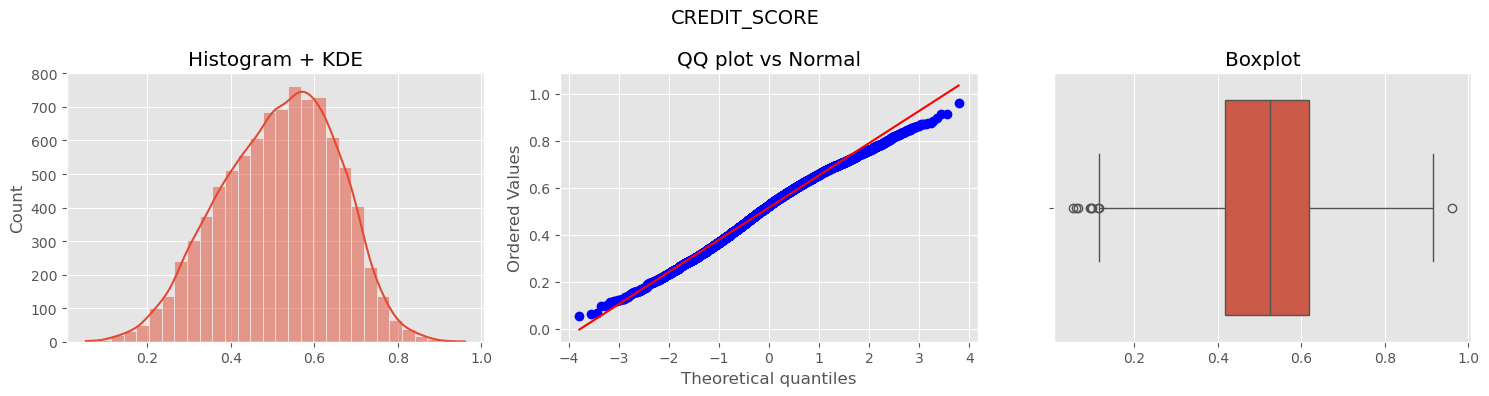

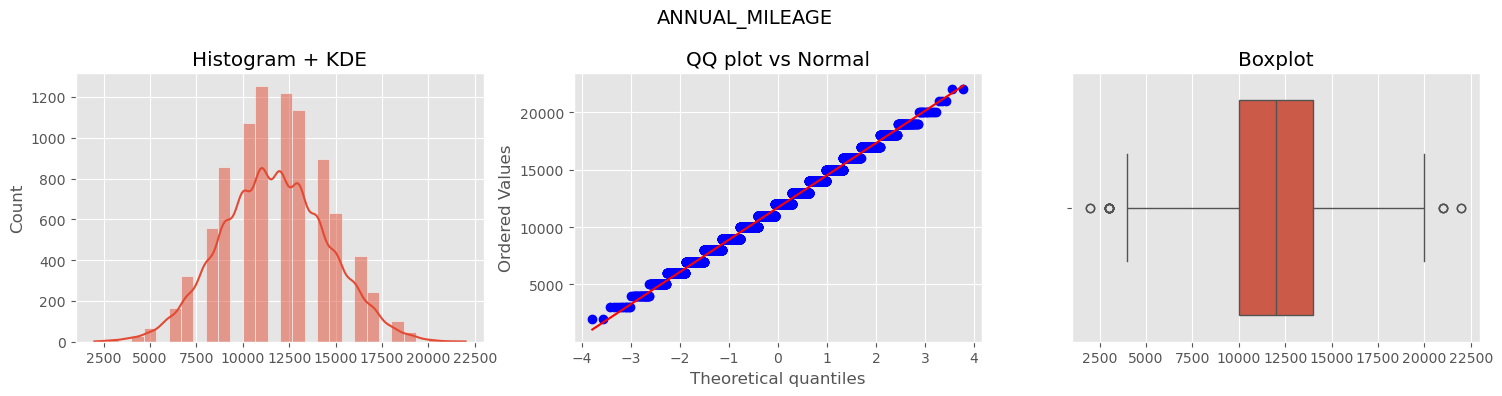

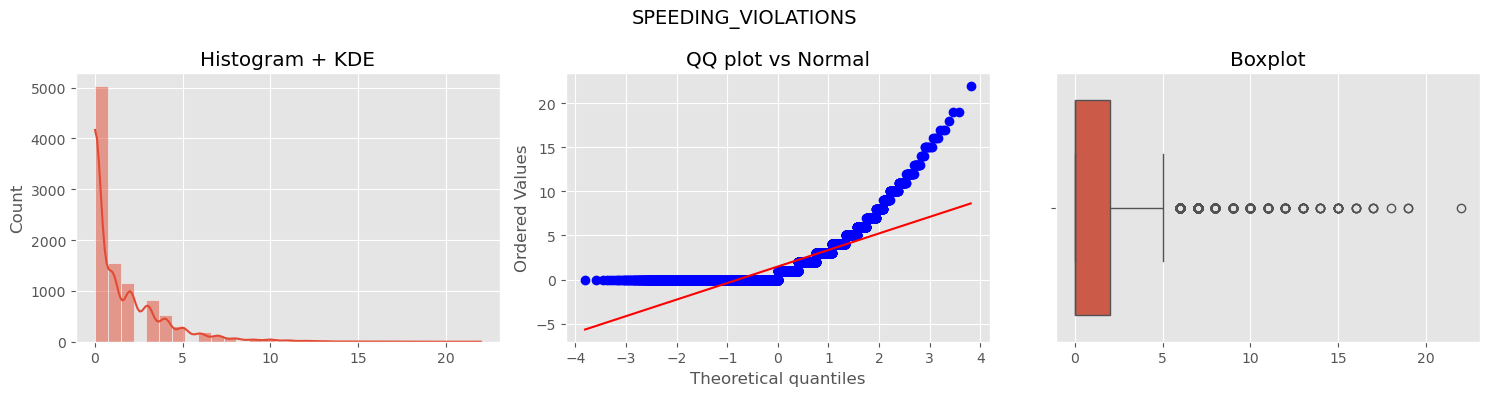

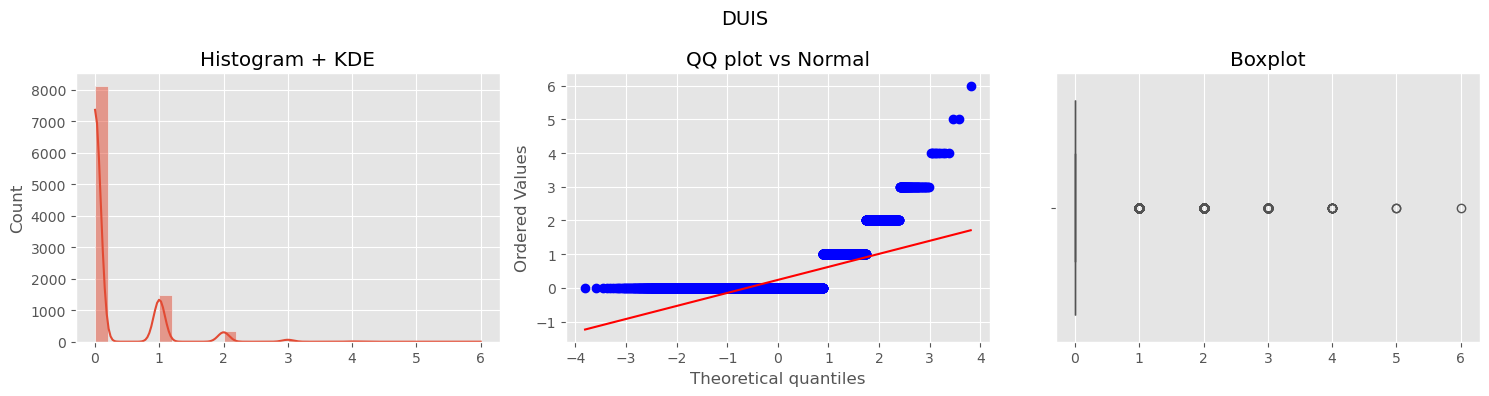

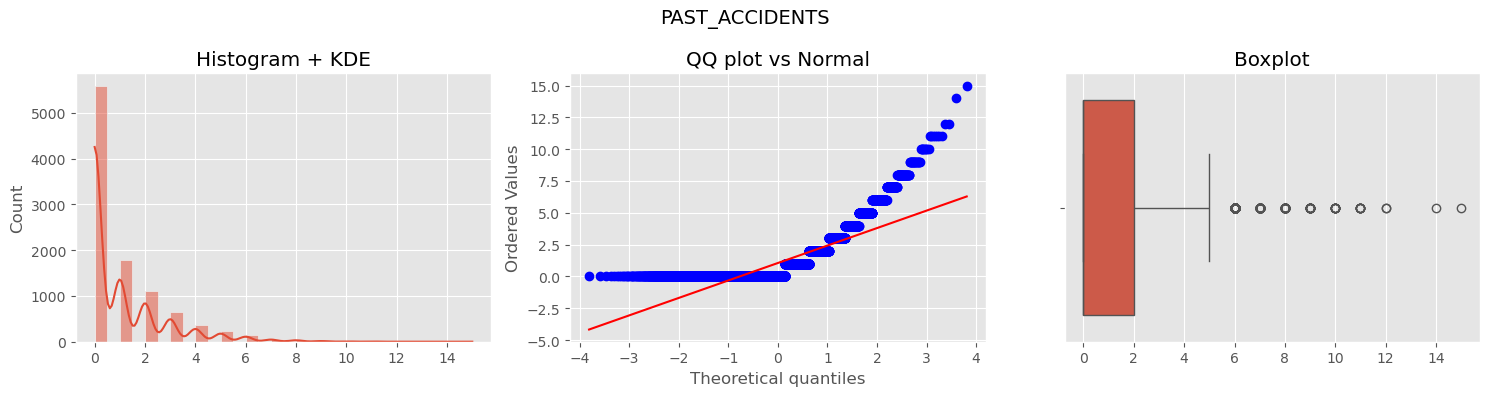

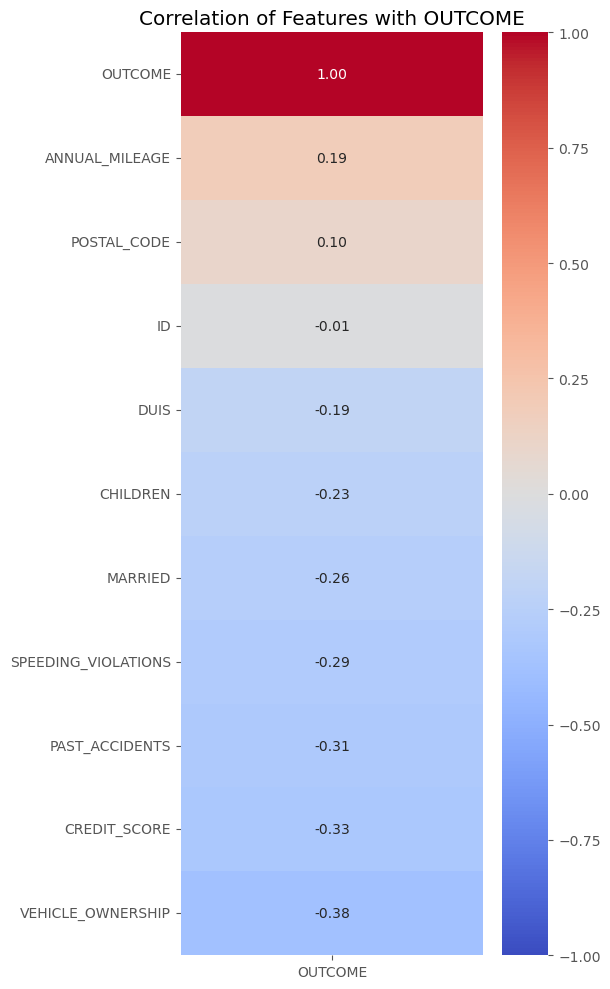

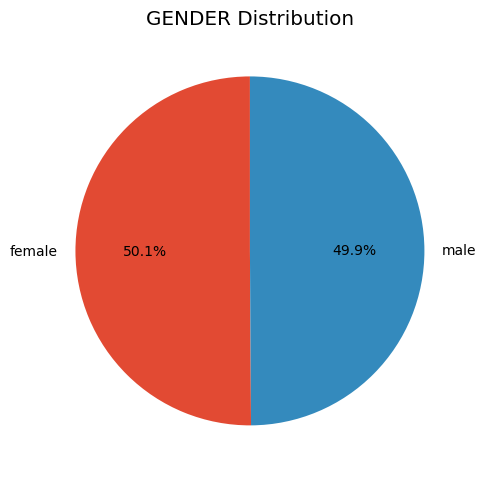

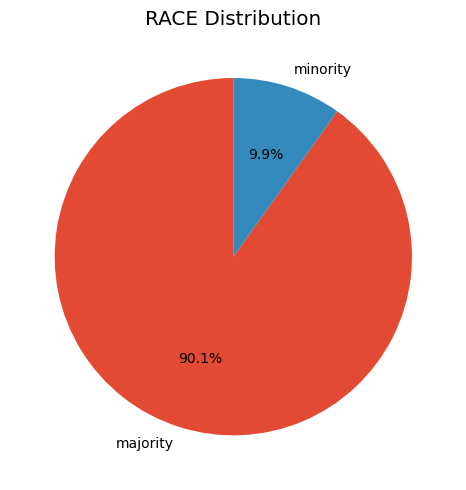

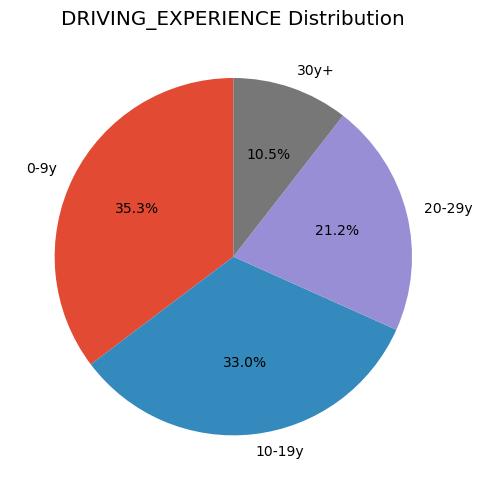

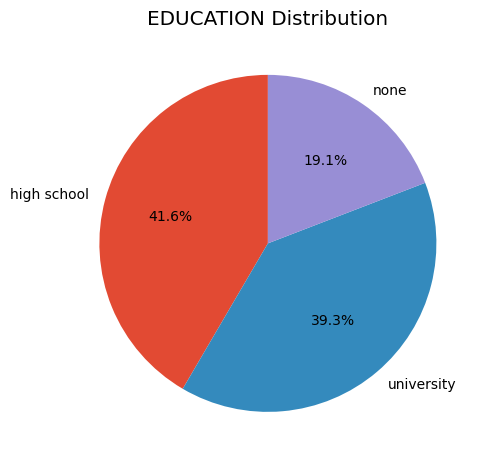

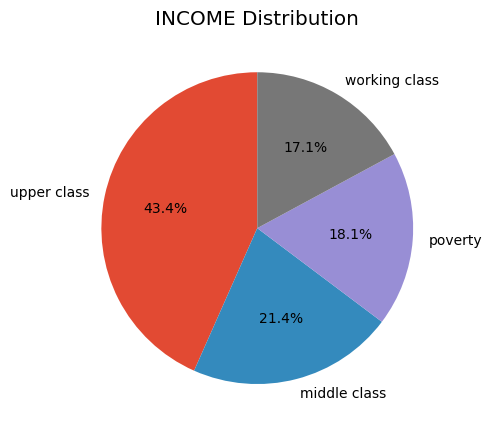

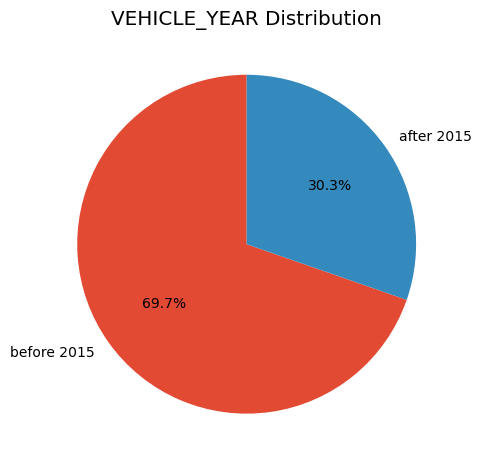

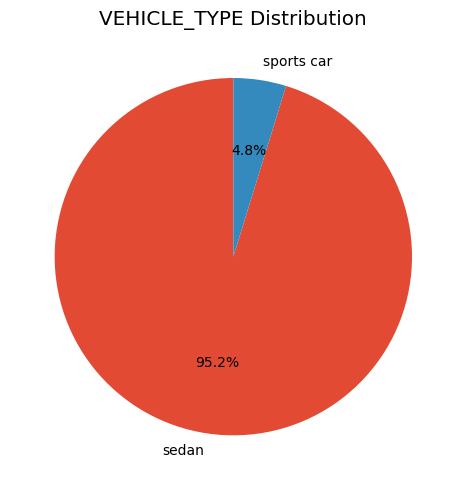

Dataset shape before: (10000, 19)
Nulls before:
CREDIT_SCORE      982
ANNUAL_MILEAGE    957
dtype: int64

Records dropped: 1,851 (18.5%)
Dataset shape after: (8149, 19)

=== TARGET PRESERVATION ===
Claim rate BEFORE: 0.3133
Claim rate AFTER:  0.3112
Difference: 0.0021
✅ Preserved


In [34]:
# Load data
df, df_copy = load_data("Car_Insurance_Claim.csv")

# Explore
display_basic_info(df)
analyze_missing_data(df)

# Test normality
normality_results = test_normality(df, sample_size=5000)

# Plot diagnostics
plot_diagnostic_plots(df)
plot_correlation_heatmap(df)
plot_categorical_distributions(df)

# Preprocess
df = encode_ordinal_features(df)
df = encode_binary_features(df)
df_clean = drop_missing_values(df)

Train: (5704, 17), Test: (1630, 17), Val: (815, 17)

=== Logistic PERFORMANCE ===
Accuracy    : 0.8429
Precision   : 0.7588
Recall      : 0.7258
F1          : 0.7419
ROC-AUC     : 0.9081

=== Random Forest PERFORMANCE ===
Accuracy    : 0.8485
Precision   : 0.7664
Recall      : 0.7377
F1          : 0.7518
ROC-AUC     : 0.9133

=== XGBoost PERFORMANCE ===
Threshold   : 0.5972
Accuracy    : 0.8411
Precision   : 0.7088
Recall      : 0.8304
F1          : 0.7648
ROC-AUC     : 0.9229

MODEL COMPARISON


,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
Logistic,0.8429,0.7588,0.7258,0.7419,0.9081
Random Forest,0.8485,0.7664,0.7377,0.7518,0.9133
XGBoost,0.8411,0.7088,0.8304,0.7648,0.9229


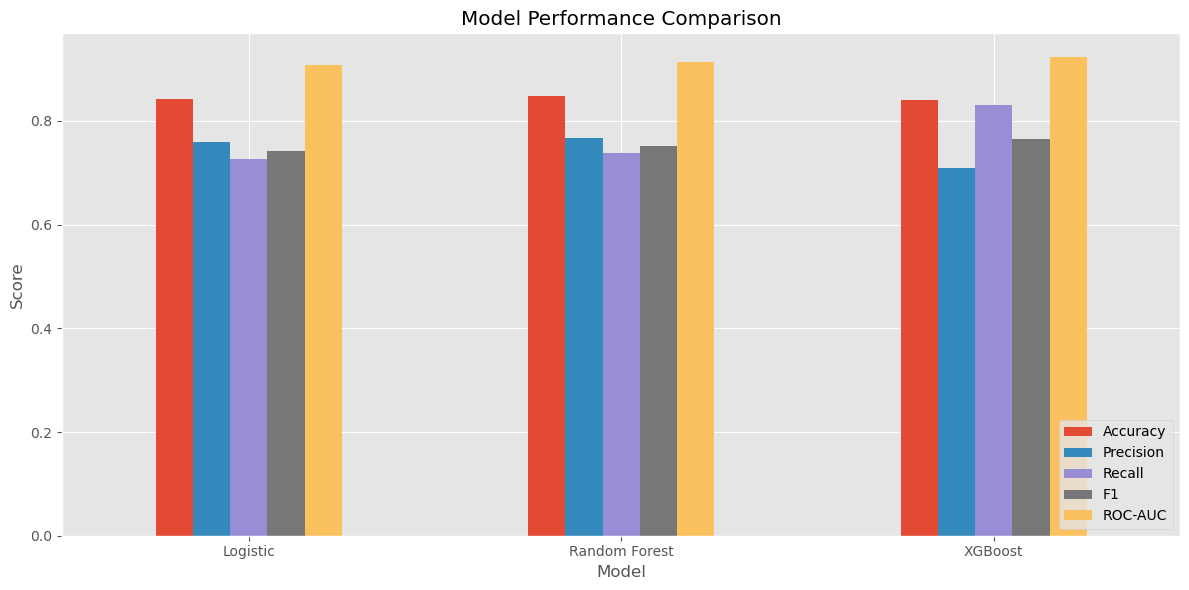

,Accuracy,Precision,Recall,F1,ROC-AUC
Model,,,,,
Logistic,0.842945,0.758763,0.725838,0.741935,0.908144
Random Forest,0.848466,0.766393,0.737673,0.751759,0.913306
XGBoost,0.841104,0.708754,0.830375,0.764759,0.922946


In [59]:
# Split
X_train, X_test, X_val, y_train, y_test, y_val = split_data(df_clean)

# Train models
logit = train_logit(X_train, y_train, C=1.0)
rf = train_random_forest(X_train, y_train, n_estimators=200)
xgb_model_recall = train_xgboost(X_train, y_train,  n_estimators = 355, learning_rate = 0.14960040405145628, max_depth = 2, min_child_weight = 7, 
                          subsample = 0.936370062213827, colsample_bytree = 0.8644659014780961 ,gamma = 4.2044544489396145,
                          reg_alpha = 0.4600882894025401, reg_lambda = 1.7197319996146099 )
xgb_model_still_recall = train_xgboost(X_train, y_train, n_estimators = 227, learning_rate = 0.2799367199473953, max_depth = 9, min_child_weight = 1,
                          subsample = 0.8285551718236109, colsample_bytree = 0.6613917880650725, gamma = 0.017926244506471428,
                          reg_alpha = 0.3067439242926182, reg_lambda = 5.908863845419243)
xgb_model_precision_not_overfit = train_xgboost(X_train, y_train, n_estimators = 168, learning_rate = 0.015631599062567773, max_depth = 3, min_child_weight = 3,
                          subsample = 0.554904730920193, colsample_bytree = 0.5661206393438786, gamma = 3.960461038350048,
                          reg_alpha = 0.3861040848230848, reg_lambda = 4.152049268977841, threshold = 0.8969)
xgb_model_pure_precision = train_xgboost(X_train, y_train, n_estimators = 390, learning_rate = 0.006815540405463377 , max_depth = 2, min_child_weight = 2,
                          subsample = 0.989490234485494, colsample_bytree = 0.525423870221976, gamma = 1.0421710162042357 ,
                          reg_alpha = 0.43294444051781733, reg_lambda = 4.9417861111563814, threshold = 0.8910)
xgb_model = train_xgboost(X_train, y_train, n_estimators = 320, learning_rate = 0.16330202627321247 , max_depth = 4, min_child_weight = 10,
                          subsample = 0.8634104334210331, colsample_bytree = 0.7784784378425039, gamma = 4.999770127015127,
                          reg_alpha = 0.9365294668951473, reg_lambda = 9.768584844844348, threshold = 0.5972)
# Evaluate
logit_metrics = evaluate_model(logit, X_test, y_test, "Logistic")
rf_metrics = evaluate_model(rf, X_test, y_test, "Random Forest")
xgb_metrics = evaluate_model(xgb_model, X_test, y_test, "XGBoost", is_xgb=True, threshold = 0.5972)

# Compare
compare_models([logit_metrics, rf_metrics, xgb_metrics])

In [55]:
# Optimize
best_params, study = optimize_xgboost_optuna(X_train, y_train, X_val, y_val, cv_folds = 10, n_trials=100)

[I 2026-02-08 17:25:21,552] A new study created in memory with name: no-name-67813b3c-7654-4961-bc95-87b5b8ef4da0
                                       

[I 2026-02-08 17:25:24,432] Trial 0 finished with value: 0.7693627999109917 and parameters: {'n_estimators': 366, 'learning_rate': 0.03858541637888582, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.8833278212095599, 'colsample_bytree': 0.6068517333657172, 'gamma': 4.123309399877941, 'reg_alpha': 0.9975918429186797, 'reg_lambda': 8.303243071685397, 'threshold': 0.6339937132060083}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:25:28,447] Trial 1 finished with value: 0.5845251701763626 and parameters: {'n_estimators': 419, 'learning_rate': 0.03536900747513415, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5970037342677603, 'colsample_bytree': 0.5693767223258837, 'gamma': 4.088375569836321, 'reg_alpha': 0.622855757366806, 'reg_lambda': 7.27162467751665, 'threshold': 0.8745643570693585}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:25:33,563] Trial 2 finished with value: 0.7536710545623855 and parameters: {'n_estimators': 488, 'learning_rate': 0.018493675876712152, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9104027092027455, 'colsample_bytree': 0.8004645149044659, 'gamma': 3.7721235094144574, 'reg_alpha': 0.4170649673479629, 'reg_lambda': 7.328915676138785, 'threshold': 0.7421752779663329}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:25:35,648] Trial 3 finished with value: 0.7087275284655824 and parameters: {'n_estimators': 183, 'learning_rate': 0.13923657513253512, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8436183760624409, 'colsample_bytree': 0.7987591889890997, 'gamma': 1.8957044890259571, 'reg_alpha': 0.17553649529239765, 'reg_lambda': 3.3099458581554497, 'threshold': 0.18367379838800713}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:25:37,944] Trial 4 finished with value: 0.7397265904897729 and parameters: {'n_estimators': 314, 'learning_rate': 0.2942785513860589, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8250641580058224, 'colsample_bytree': 0.7875896352252575, 'gamma': 2.3001207381267004, 'reg_alpha': 0.7617950283402217, 'reg_lambda': 2.4601786311099394, 'threshold': 0.3609054488168614}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:25:40,552] Trial 5 finished with value: 0.6630325576639657 and parameters: {'n_estimators': 201, 'learning_rate': 0.05118607314817339, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.694852300702856, 'colsample_bytree': 0.8648830777034647, 'gamma': 4.005005703225204, 'reg_alpha': 0.9896819459398182, 'reg_lambda': 4.003840201376207, 'threshold': 0.17024999859457307}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:25:43,735] Trial 6 finished with value: 0.7499437996686072 and parameters: {'n_estimators': 202, 'learning_rate': 0.1591801702239898, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.8469528068669071, 'colsample_bytree': 0.7819653676476166, 'gamma': 1.2047400965030872, 'reg_alpha': 0.3943630147678312, 'reg_lambda': 8.723063490099031, 'threshold': 0.5894035156665999}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:25:48,355] Trial 7 finished with value: 0.7587411969364825 and parameters: {'n_estimators': 495, 'learning_rate': 0.045927221405472084, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.7038169071261823, 'colsample_bytree': 0.6679339125839551, 'gamma': 2.2457141887649943, 'reg_alpha': 0.4630431081655458, 'reg_lambda': 2.6406981601689816, 'threshold': 0.6299870908125837}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:25:53,470] Trial 8 finished with value: 0.7669759735514653 and parameters: {'n_estimators': 419, 'learning_rate': 0.005211412180318511, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.715357926169921, 'colsample_bytree': 0.7918085134653652, 'gamma': 3.768427494181498, 'reg_alpha': 0.047652971447742484, 'reg_lambda': 5.138598287005937, 'threshold': 0.5533561509015325}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:25:56,809] Trial 9 finished with value: 0.7270608506737422 and parameters: {'n_estimators': 472, 'learning_rate': 0.02852133660844965, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.8253854263016612, 'colsample_bytree': 0.7805310544456487, 'gamma': 1.1778700015148542, 'reg_alpha': 0.43349143963110376, 'reg_lambda': 1.859216900339936, 'threshold': 0.7388146064729679}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:26:00,220] Trial 10 finished with value: 0.7408813500106087 and parameters: {'n_estimators': 314, 'learning_rate': 0.009452999252056544, 'max_depth': 12, 'min_child_weight': 8, 'subsample': 0.9980685973095316, 'colsample_bytree': 0.5014538026578335, 'gamma': 4.9786588306155455, 'reg_alpha': 0.9752737032605625, 'reg_lambda': 9.934663966584008, 'threshold': 0.3728848742967149}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:26:04,153] Trial 11 finished with value: 0.7584828426865456 and parameters: {'n_estimators': 383, 'learning_rate': 0.005334986874828361, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.5560032200471763, 'colsample_bytree': 0.9454768189189522, 'gamma': 3.120214973524282, 'reg_alpha': 0.015234445683732466, 'reg_lambda': 5.475626174415593, 'threshold': 0.45041805578019634}. Best is trial 0 with value: 0.7693627999109917.


[I 2026-02-08 17:26:07,798] Trial 12 finished with value: 0.7700275368758943 and parameters: {'n_estimators': 375, 'learning_rate': 0.01221705978881154, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.744323164628068, 'colsample_bytree': 0.6579540516581414, 'gamma': 4.7725341452670715, 'reg_alpha': 0.22990330243788853, 'reg_lambda': 5.364376211165243, 'threshold': 0.5412743090929302}. Best is trial 12 with value: 0.7700275368758943.


[I 2026-02-08 17:26:10,502] Trial 13 finished with value: 0.732876121446526 and parameters: {'n_estimators': 264, 'learning_rate': 0.017767486791768906, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9915697704114588, 'colsample_bytree': 0.6541579593117544, 'gamma': 4.937959409231608, 'reg_alpha': 0.25133325457983513, 'reg_lambda': 7.0693098701070625, 'threshold': 0.7276307754428479}. Best is trial 12 with value: 0.7700275368758943.


[I 2026-02-08 17:26:13,297] Trial 14 finished with value: 0.7677243085551407 and parameters: {'n_estimators': 356, 'learning_rate': 0.0736290468419615, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.6310862795995592, 'colsample_bytree': 0.6623303114096696, 'gamma': 3.081373941608053, 'reg_alpha': 0.7584024735112509, 'reg_lambda': 6.196210545492334, 'threshold': 0.46974540407975707}. Best is trial 12 with value: 0.7700275368758943.


[I 2026-02-08 17:26:15,990] Trial 15 finished with value: 0.47032702559976713 and parameters: {'n_estimators': 257, 'learning_rate': 0.0118443105627411, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.7845185634107978, 'colsample_bytree': 0.5873933677430512, 'gamma': 4.5650662865006, 'reg_alpha': 0.2601453474688661, 'reg_lambda': 8.739472527840128, 'threshold': 0.8733406867222683}. Best is trial 12 with value: 0.7700275368758943.


[I 2026-02-08 17:26:18,416] Trial 16 finished with value: 0.767967436634275 and parameters: {'n_estimators': 358, 'learning_rate': 0.0877220021310438, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.9162616264797623, 'colsample_bytree': 0.6962643675705076, 'gamma': 3.2924186841150123, 'reg_alpha': 0.693597773404721, 'reg_lambda': 4.796827375232148, 'threshold': 0.6648590814340933}. Best is trial 12 with value: 0.7700275368758943.


[I 2026-02-08 17:26:20,150] Trial 17 finished with value: 0.7192148953766776 and parameters: {'n_estimators': 107, 'learning_rate': 0.02068253142055011, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.7638766694740986, 'colsample_bytree': 0.593127393888185, 'gamma': 0.05302014991401949, 'reg_alpha': 0.863548550879597, 'reg_lambda': 6.292102655210914, 'threshold': 0.3344038645814421}. Best is trial 12 with value: 0.7700275368758943.


[I 2026-02-08 17:26:23,764] Trial 18 finished with value: 0.7714277023801128 and parameters: {'n_estimators': 431, 'learning_rate': 0.011007438373187526, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9166991553190997, 'colsample_bytree': 0.7222840340023745, 'gamma': 4.418867020913592, 'reg_alpha': 0.583876875655099, 'reg_lambda': 8.28380236839841, 'threshold': 0.4978074484121165}. Best is trial 18 with value: 0.7714277023801128.


[I 2026-02-08 17:26:28,300] Trial 19 finished with value: 0.7085311578364967 and parameters: {'n_estimators': 434, 'learning_rate': 0.008887203806837553, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6545327268237267, 'colsample_bytree': 0.7197900225516491, 'gamma': 4.511321673227568, 'reg_alpha': 0.6231496681959618, 'reg_lambda': 1.1192004605803438, 'threshold': 0.2482749420627141}. Best is trial 18 with value: 0.7714277023801128.


[I 2026-02-08 17:26:32,006] Trial 20 finished with value: 0.772863431872977 and parameters: {'n_estimators': 446, 'learning_rate': 0.011895569508414437, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.943001694958226, 'colsample_bytree': 0.8810545213682439, 'gamma': 2.8083206250155297, 'reg_alpha': 0.5587977353363567, 'reg_lambda': 4.248794011702128, 'threshold': 0.5055229991664704}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:26:36,316] Trial 21 finished with value: 0.7694018741113724 and parameters: {'n_estimators': 446, 'learning_rate': 0.011032489928273867, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9435113498523195, 'colsample_bytree': 0.9930545064444681, 'gamma': 2.6649112626702105, 'reg_alpha': 0.5541705982222199, 'reg_lambda': 4.238732119023655, 'threshold': 0.523471548958647}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:26:40,452] Trial 22 finished with value: 0.7600211684383358 and parameters: {'n_estimators': 398, 'learning_rate': 0.007256263494176322, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9505697303887175, 'colsample_bytree': 0.9167147985363763, 'gamma': 4.562766337788554, 'reg_alpha': 0.5564147341339054, 'reg_lambda': 6.290713410170865, 'threshold': 0.4153917203449631}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:26:45,000] Trial 23 finished with value: 0.7716429314796476 and parameters: {'n_estimators': 450, 'learning_rate': 0.0142067638404845, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7865404005120329, 'colsample_bytree': 0.8427724760492221, 'gamma': 3.544867575806411, 'reg_alpha': 0.32452588429151974, 'reg_lambda': 4.24875199284813, 'threshold': 0.5095838738271761}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:26:49,689] Trial 24 finished with value: 0.7321355138703838 and parameters: {'n_estimators': 452, 'learning_rate': 0.015067758008034261, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8760300275277858, 'colsample_bytree': 0.8541852986156355, 'gamma': 3.5578735459795436, 'reg_alpha': 0.32812338557984866, 'reg_lambda': 3.855732511431593, 'threshold': 0.28575810624815}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:26:54,352] Trial 25 finished with value: 0.7650135814070413 and parameters: {'n_estimators': 456, 'learning_rate': 0.0258073064764318, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5107478971006121, 'colsample_bytree': 0.8521092705219302, 'gamma': 2.738454948067209, 'reg_alpha': 0.5236833982565066, 'reg_lambda': 3.024519538648354, 'threshold': 0.4733845553283673}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:26:58,113] Trial 26 finished with value: 0.5582276484645576 and parameters: {'n_estimators': 407, 'learning_rate': 0.007124899324631128, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9516445519914203, 'colsample_bytree': 0.8993792824196651, 'gamma': 1.799793308714107, 'reg_alpha': 0.3579951387362274, 'reg_lambda': 4.708106201616245, 'threshold': 0.1028905942492116}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:27:01,844] Trial 27 finished with value: 0.7623313047625514 and parameters: {'n_estimators': 337, 'learning_rate': 0.014378701391132221, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7944426390046194, 'colsample_bytree': 0.7329769060041106, 'gamma': 3.451740183343123, 'reg_alpha': 0.6370278322366574, 'reg_lambda': 9.576349680437968, 'threshold': 0.42111194795232354}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:27:06,416] Trial 28 finished with value: 0.7712535724132739 and parameters: {'n_estimators': 472, 'learning_rate': 0.02485224815424534, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8851122570520861, 'colsample_bytree': 0.9709933087899952, 'gamma': 2.9455315259265267, 'reg_alpha': 0.4962792203933552, 'reg_lambda': 3.5546916176383547, 'threshold': 0.5084963084920631}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:27:10,080] Trial 29 finished with value: 0.7516259213845432 and parameters: {'n_estimators': 496, 'learning_rate': 0.007694701282780651, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.879502626837588, 'colsample_bytree': 0.8358038000477114, 'gamma': 3.8321150059608273, 'reg_alpha': 0.11890499367736207, 'reg_lambda': 4.363205754529306, 'threshold': 0.6090233823047829}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:27:13,494] Trial 30 finished with value: 0.7598820828031531 and parameters: {'n_estimators': 396, 'learning_rate': 0.015798931802127762, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9231912085061219, 'colsample_bytree': 0.8939438598354786, 'gamma': 3.477415836750141, 'reg_alpha': 0.33566905034179034, 'reg_lambda': 6.899425854958212, 'threshold': 0.677115543272144}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:27:18,059] Trial 31 finished with value: 0.7702312822017053 and parameters: {'n_estimators': 469, 'learning_rate': 0.02379553827575328, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8752008775476556, 'colsample_bytree': 0.9980435865070433, 'gamma': 2.9658957647620268, 'reg_alpha': 0.48818517217721524, 'reg_lambda': 3.583066112863633, 'threshold': 0.5052850979004758}. Best is trial 20 with value: 0.772863431872977.


[I 2026-02-08 17:27:22,252] Trial 32 finished with value: 0.7729756817658682 and parameters: {'n_estimators': 425, 'learning_rate': 0.03277898966630095, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9606115782345487, 'colsample_bytree': 0.9490909015298565, 'gamma': 4.393473638283593, 'reg_alpha': 0.5799017003321162, 'reg_lambda': 8.068909156779059, 'threshold': 0.5652959600293788}. Best is trial 32 with value: 0.7729756817658682.


[I 2026-02-08 17:27:26,060] Trial 33 finished with value: 0.7708557156868878 and parameters: {'n_estimators': 429, 'learning_rate': 0.048940074658827604, 'max_depth': 11, 'min_child_weight': 9, 'subsample': 0.9726517651368254, 'colsample_bytree': 0.9441629671170755, 'gamma': 4.228963571581904, 'reg_alpha': 0.6688868922213668, 'reg_lambda': 8.172266729630321, 'threshold': 0.5961646525405059}. Best is trial 32 with value: 0.7729756817658682.


[I 2026-02-08 17:27:29,809] Trial 34 finished with value: 0.7710358951081387 and parameters: {'n_estimators': 429, 'learning_rate': 0.030965443707516888, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9076648834563537, 'colsample_bytree': 0.8302304590623678, 'gamma': 4.199985266658289, 'reg_alpha': 0.5760282381999333, 'reg_lambda': 7.7517431404896415, 'threshold': 0.5560544335489433}. Best is trial 32 with value: 0.7729756817658682.


[I 2026-02-08 17:27:33,895] Trial 35 finished with value: 0.7624451725677324 and parameters: {'n_estimators': 340, 'learning_rate': 0.019908717155787816, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.9704407888027368, 'colsample_bytree': 0.8850773036019288, 'gamma': 4.371874652620216, 'reg_alpha': 0.7527829540632509, 'reg_lambda': 8.980398083858498, 'threshold': 0.4289245560656476}. Best is trial 32 with value: 0.7729756817658682.


[I 2026-02-08 17:27:37,601] Trial 36 finished with value: 0.6957217019024206 and parameters: {'n_estimators': 407, 'learning_rate': 0.03801458562045487, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.9282492146991272, 'colsample_bytree': 0.9405265509096064, 'gamma': 3.9517298349596093, 'reg_alpha': 0.6960610316715492, 'reg_lambda': 7.760395640218214, 'threshold': 0.8063696034936789}. Best is trial 32 with value: 0.7729756817658682.


[I 2026-02-08 17:27:43,116] Trial 37 finished with value: 0.7555118376263241 and parameters: {'n_estimators': 471, 'learning_rate': 0.013636473919947156, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8112568003808599, 'colsample_bytree': 0.7585301782953304, 'gamma': 3.6150610068972986, 'reg_alpha': 0.5936392217827933, 'reg_lambda': 9.428724479287247, 'threshold': 0.3893225387452911}. Best is trial 32 with value: 0.7729756817658682.


[I 2026-02-08 17:27:46,572] Trial 38 finished with value: 0.7410338645925892 and parameters: {'n_estimators': 445, 'learning_rate': 0.08037585355489325, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.8934892720713101, 'colsample_bytree': 0.819718875623231, 'gamma': 2.3255246943200927, 'reg_alpha': 0.40416650598559617, 'reg_lambda': 5.763988390677638, 'threshold': 0.32015204948694986}. Best is trial 32 with value: 0.7729756817658682.


[I 2026-02-08 17:27:49,694] Trial 39 finished with value: 0.7722125890809179 and parameters: {'n_estimators': 381, 'learning_rate': 0.0606459335211836, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8503332541773414, 'colsample_bytree': 0.9200312863430665, 'gamma': 4.046490324403834, 'reg_alpha': 0.8111929563689257, 'reg_lambda': 8.316589366173794, 'threshold': 0.6621025967730338}. Best is trial 32 with value: 0.7729756817658682.


[I 2026-02-08 17:27:53,412] Trial 40 finished with value: 0.7570860428798186 and parameters: {'n_estimators': 387, 'learning_rate': 0.06252115320615424, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8557910755596989, 'colsample_bytree': 0.9157184782428327, 'gamma': 1.8528417616237511, 'reg_alpha': 0.8844951431345303, 'reg_lambda': 2.348415793830864, 'threshold': 0.6785241144527824}. Best is trial 32 with value: 0.7729756817658682.


[I 2026-02-08 17:27:56,448] Trial 41 finished with value: 0.7754493617576637 and parameters: {'n_estimators': 417, 'learning_rate': 0.1070402739988607, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8320068267768731, 'colsample_bytree': 0.872533079895097, 'gamma': 4.110734181542364, 'reg_alpha': 0.8248863997640382, 'reg_lambda': 8.342580816456604, 'threshold': 0.5750577280737567}. Best is trial 41 with value: 0.7754493617576637.


[I 2026-02-08 17:27:59,659] Trial 42 finished with value: 0.7732790894503969 and parameters: {'n_estimators': 415, 'learning_rate': 0.10851395424799008, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.7360565718774082, 'colsample_bytree': 0.8769008510962764, 'gamma': 4.066504593833673, 'reg_alpha': 0.8290348751507164, 'reg_lambda': 7.470317870451929, 'threshold': 0.5773286682641969}. Best is trial 41 with value: 0.7754493617576637.


[I 2026-02-08 17:28:02,847] Trial 43 finished with value: 0.7702106067189715 and parameters: {'n_estimators': 410, 'learning_rate': 0.11535668292459779, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7423304643570526, 'colsample_bytree': 0.8747919517495325, 'gamma': 4.052236199979657, 'reg_alpha': 0.8528588584135995, 'reg_lambda': 7.611154877327275, 'threshold': 0.6463011818720601}. Best is trial 41 with value: 0.7754493617576637.


[I 2026-02-08 17:28:05,676] Trial 44 finished with value: 0.7728215182102737 and parameters: {'n_estimators': 364, 'learning_rate': 0.18181329365981055, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8395556010033963, 'colsample_bytree': 0.9678165850799774, 'gamma': 4.72857447705744, 'reg_alpha': 0.8091338853595623, 'reg_lambda': 9.21287418248861, 'threshold': 0.5752665041041926}. Best is trial 41 with value: 0.7754493617576637.


[I 2026-02-08 17:28:07,976] Trial 45 finished with value: 0.7723912594731063 and parameters: {'n_estimators': 308, 'learning_rate': 0.24383030999476007, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6718539860883747, 'colsample_bytree': 0.9656797873753469, 'gamma': 4.736778201906418, 'reg_alpha': 0.9299924719056692, 'reg_lambda': 9.22659008414677, 'threshold': 0.5693737739473412}. Best is trial 41 with value: 0.7754493617576637.


[I 2026-02-08 17:28:10,336] Trial 46 finished with value: 0.7740456883570426 and parameters: {'n_estimators': 333, 'learning_rate': 0.1971903274883762, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8252464195955862, 'colsample_bytree': 0.9758900751346662, 'gamma': 4.846782198977181, 'reg_alpha': 0.8225822050392237, 'reg_lambda': 9.875999958406355, 'threshold': 0.6136005672120998}. Best is trial 41 with value: 0.7754493617576637.


[I 2026-02-08 17:28:13,080] Trial 47 finished with value: 0.7509656073456844 and parameters: {'n_estimators': 278, 'learning_rate': 0.10954416809826864, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.7285915543811965, 'colsample_bytree': 0.8155786720349316, 'gamma': 1.5722409982871615, 'reg_alpha': 0.9518886396405732, 'reg_lambda': 6.866795991212945, 'threshold': 0.7054531661411418}. Best is trial 41 with value: 0.7754493617576637.


[I 2026-02-08 17:28:15,475] Trial 48 finished with value: 0.7696593968977886 and parameters: {'n_estimators': 344, 'learning_rate': 0.2090860902579156, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8156243670280273, 'colsample_bytree': 0.9307037161114122, 'gamma': 4.301399110672442, 'reg_alpha': 0.7287149575813884, 'reg_lambda': 8.615583664368046, 'threshold': 0.6056771167143845}. Best is trial 41 with value: 0.7754493617576637.


[I 2026-02-08 17:28:17,340] Trial 49 finished with value: 0.734590299910923 and parameters: {'n_estimators': 220, 'learning_rate': 0.1382598128931422, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7647551309743511, 'colsample_bytree': 0.8723966540243879, 'gamma': 4.930391166495549, 'reg_alpha': 0.8986960291817009, 'reg_lambda': 9.971154013268675, 'threshold': 0.7737028590108186}. Best is trial 41 with value: 0.7754493617576637.


[I 2026-02-08 17:28:19,470] Trial 50 finished with value: 0.7171041091813777 and parameters: {'n_estimators': 130, 'learning_rate': 0.2590590758029207, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.698400405549279, 'colsample_bytree': 0.9008376758941691, 'gamma': 0.706033616544306, 'reg_alpha': 0.7985485441340132, 'reg_lambda': 7.245656060346915, 'threshold': 0.6300881755611278}. Best is trial 41 with value: 0.7754493617576637.


[I 2026-02-08 17:28:21,999] Trial 51 finished with value: 0.7758692516777085 and parameters: {'n_estimators': 364, 'learning_rate': 0.1762209299607093, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.839300846242178, 'colsample_bytree': 0.963461743099189, 'gamma': 4.696383864731238, 'reg_alpha': 0.8294640789900323, 'reg_lambda': 9.64878641899894, 'threshold': 0.5717993631435654}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:24,385] Trial 52 finished with value: 0.7696314909506621 and parameters: {'n_estimators': 326, 'learning_rate': 0.15412407124162014, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7657766860213443, 'colsample_bytree': 0.9788554780970744, 'gamma': 4.673301074822643, 'reg_alpha': 0.8308609329620923, 'reg_lambda': 9.569429889635707, 'threshold': 0.5505733056826518}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:27,025] Trial 53 finished with value: 0.7728079928672007 and parameters: {'n_estimators': 367, 'learning_rate': 0.10383872227452483, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.8289935748813638, 'colsample_bytree': 0.9591172185642719, 'gamma': 4.923789635115541, 'reg_alpha': 0.7744437418214536, 'reg_lambda': 8.719121572669538, 'threshold': 0.4755865372049187}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:29,967] Trial 54 finished with value: 0.7709270449818653 and parameters: {'n_estimators': 416, 'learning_rate': 0.19236144579950096, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8600956592001021, 'colsample_bytree': 0.9486054366960215, 'gamma': 3.8634774076110245, 'reg_alpha': 0.9226770255616206, 'reg_lambda': 8.162330267447683, 'threshold': 0.6188545926318405}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:32,150] Trial 55 finished with value: 0.7735835469696807 and parameters: {'n_estimators': 284, 'learning_rate': 0.28682443725598933, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.8046465503416083, 'colsample_bytree': 0.507297093692328, 'gamma': 4.447857037067014, 'reg_alpha': 0.9963912005998299, 'reg_lambda': 9.769767692985711, 'threshold': 0.5459547787982867}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:34,403] Trial 56 finished with value: 0.7579330411392693 and parameters: {'n_estimators': 289, 'learning_rate': 0.29171918571691347, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8003826786579811, 'colsample_bytree': 0.5214907980961773, 'gamma': 4.51356823706704, 'reg_alpha': 0.9729589521783693, 'reg_lambda': 9.71030485793128, 'threshold': 0.7050516379244308}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:36,518] Trial 57 finished with value: 0.7684145181420055 and parameters: {'n_estimators': 257, 'learning_rate': 0.13214362869756566, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.7314583783493556, 'colsample_bytree': 0.6206232277658966, 'gamma': 4.334093912974448, 'reg_alpha': 0.7184835906477345, 'reg_lambda': 8.520617730249379, 'threshold': 0.5343786780672451}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:38,868] Trial 58 finished with value: 0.7711178482614678 and parameters: {'n_estimators': 325, 'learning_rate': 0.22752625817811586, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.778442626839246, 'colsample_bytree': 0.5307877298117202, 'gamma': 4.183051360987877, 'reg_alpha': 0.8440056101440999, 'reg_lambda': 9.013532247026474, 'threshold': 0.5756892983458896}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:40,865] Trial 59 finished with value: 0.7713922684378651 and parameters: {'n_estimators': 239, 'learning_rate': 0.17278055817732565, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.6825681158839857, 'colsample_bytree': 0.9870772756599638, 'gamma': 3.7039049293457422, 'reg_alpha': 0.9019727920085432, 'reg_lambda': 9.98530724217166, 'threshold': 0.5873092999141419}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:43,048] Trial 60 finished with value: 0.7692344256214575 and parameters: {'n_estimators': 296, 'learning_rate': 0.0937159419143976, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.6010712623106355, 'colsample_bytree': 0.7651014512298345, 'gamma': 4.991253587999654, 'reg_alpha': 0.9773577567935701, 'reg_lambda': 9.199023479374842, 'threshold': 0.46331229541177765}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:45,320] Trial 61 finished with value: 0.7735474220188112 and parameters: {'n_estimators': 350, 'learning_rate': 0.29715374956401924, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.833243219297178, 'colsample_bytree': 0.9200870992083731, 'gamma': 4.54793397513632, 'reg_alpha': 0.6580800806138782, 'reg_lambda': 9.747493363538972, 'threshold': 0.5309847171442312}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:47,512] Trial 62 finished with value: 0.7749211188500508 and parameters: {'n_estimators': 318, 'learning_rate': 0.29720542283795526, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8066154307665465, 'colsample_bytree': 0.9286099752691147, 'gamma': 4.5778560449523855, 'reg_alpha': 0.6711707043230388, 'reg_lambda': 9.705958521568366, 'threshold': 0.5328622193514189}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:49,809] Trial 63 finished with value: 0.7694163472904217 and parameters: {'n_estimators': 353, 'learning_rate': 0.2868625754032999, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.828898560124599, 'colsample_bytree': 0.9106746953557153, 'gamma': 4.643898324530379, 'reg_alpha': 0.6648323621247425, 'reg_lambda': 9.739008322193566, 'threshold': 0.6449762824644583}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:52,065] Trial 64 finished with value: 0.774234066788526 and parameters: {'n_estimators': 316, 'learning_rate': 0.2301897459242995, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8045368167903996, 'colsample_bytree': 0.8585355414426791, 'gamma': 4.850991790216109, 'reg_alpha': 0.7807175372494912, 'reg_lambda': 8.94914551221125, 'threshold': 0.5446977734749122}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:54,264] Trial 65 finished with value: 0.7738513542990749 and parameters: {'n_estimators': 322, 'learning_rate': 0.21502344540372562, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8054991562410396, 'colsample_bytree': 0.8003950814075703, 'gamma': 4.793601765988954, 'reg_alpha': 0.7669604635095759, 'reg_lambda': 9.383500046040199, 'threshold': 0.5353341431782097}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:56,256] Trial 66 finished with value: 0.7711041646045225 and parameters: {'n_estimators': 276, 'learning_rate': 0.19769331558118447, 'max_depth': 2, 'min_child_weight': 10, 'subsample': 0.808143870852022, 'colsample_bytree': 0.7929212567401863, 'gamma': 4.813706820217223, 'reg_alpha': 0.7763285249799368, 'reg_lambda': 8.914242693545267, 'threshold': 0.49050644547242844}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:28:58,811] Trial 67 finished with value: 0.7701631534279733 and parameters: {'n_estimators': 326, 'learning_rate': 0.21970857240847513, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7782076396544186, 'colsample_bytree': 0.8544939268015616, 'gamma': 4.816576553474819, 'reg_alpha': 0.7444207673697125, 'reg_lambda': 9.398234445273584, 'threshold': 0.5362053529177526}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:29:00,923] Trial 68 finished with value: 0.7735506766002622 and parameters: {'n_estimators': 307, 'learning_rate': 0.2570250368818008, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8595620482424255, 'colsample_bytree': 0.6906351037964129, 'gamma': 4.457922253156157, 'reg_alpha': 0.8812457877756115, 'reg_lambda': 9.309604973924076, 'threshold': 0.6183914259353736}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:29:03,000] Trial 69 finished with value: 0.7694583906537426 and parameters: {'n_estimators': 291, 'learning_rate': 0.14892671025944132, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7973732273018834, 'colsample_bytree': 0.9318958227513032, 'gamma': 4.822822132001012, 'reg_alpha': 0.7116285736529914, 'reg_lambda': 8.922187815579585, 'threshold': 0.4433029051940254}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:29:05,036] Trial 70 finished with value: 0.7711504836022967 and parameters: {'n_estimators': 275, 'learning_rate': 0.12731570428463987, 'max_depth': 2, 'min_child_weight': 10, 'subsample': 0.8167684480481667, 'colsample_bytree': 0.8103527474738953, 'gamma': 4.606656415889793, 'reg_alpha': 0.7953143536987122, 'reg_lambda': 8.472435613368885, 'threshold': 0.49177467916959394}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:29:07,297] Trial 71 finished with value: 0.7719767107724054 and parameters: {'n_estimators': 306, 'learning_rate': 0.24445544636590616, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8523380809659619, 'colsample_bytree': 0.6840808460131184, 'gamma': 4.4395375748825945, 'reg_alpha': 0.8709117278724668, 'reg_lambda': 9.409563654441785, 'threshold': 0.618373800399377}. Best is trial 51 with value: 0.7758692516777085.


[I 2026-02-08 17:29:09,591] Trial 72 finished with value: 0.7790362572749603 and parameters: {'n_estimators': 320, 'learning_rate': 0.16330202627321247, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8634104334210331, 'colsample_bytree': 0.7784784378425039, 'gamma': 4.999770127015127, 'reg_alpha': 0.9365294668951473, 'reg_lambda': 9.768584844844348, 'threshold': 0.597207443242641}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:12,144] Trial 73 finished with value: 0.7705843346171447 and parameters: {'n_estimators': 321, 'learning_rate': 0.17386255600695563, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7556132670762395, 'colsample_bytree': 0.7322681666105871, 'gamma': 4.847611712228564, 'reg_alpha': 0.9984649949351936, 'reg_lambda': 9.747398672192663, 'threshold': 0.5195703771976921}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:14,616] Trial 74 finished with value: 0.7740136948139003 and parameters: {'n_estimators': 336, 'learning_rate': 0.1666340612437353, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8712420960360989, 'colsample_bytree': 0.7710092051302926, 'gamma': 4.994714599734961, 'reg_alpha': 0.9407324338370836, 'reg_lambda': 9.041506634860488, 'threshold': 0.5511533821779985}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:17,030] Trial 75 finished with value: 0.7745903805082889 and parameters: {'n_estimators': 338, 'learning_rate': 0.16523005444566788, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8980160744014415, 'colsample_bytree': 0.7474969258518915, 'gamma': 4.99213434104321, 'reg_alpha': 0.9341833928684139, 'reg_lambda': 9.09404282412388, 'threshold': 0.5960286056690868}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:19,572] Trial 76 finished with value: 0.7746470840565786 and parameters: {'n_estimators': 371, 'learning_rate': 0.15045763658230782, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8950082190987387, 'colsample_bytree': 0.7798034802182444, 'gamma': 4.992953254024502, 'reg_alpha': 0.9200167959224805, 'reg_lambda': 7.9655193744488235, 'threshold': 0.592837379888667}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:22,040] Trial 77 finished with value: 0.7714676688865146 and parameters: {'n_estimators': 367, 'learning_rate': 0.14899831303806596, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8916565820236074, 'colsample_bytree': 0.7495464419431178, 'gamma': 4.655129230182, 'reg_alpha': 0.914660712591295, 'reg_lambda': 8.75603761757632, 'threshold': 0.645605843956572}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:24,595] Trial 78 finished with value: 0.7703991268532859 and parameters: {'n_estimators': 375, 'learning_rate': 0.12099808971755845, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.8681593713037309, 'colsample_bytree': 0.7473637792108102, 'gamma': 4.673871146971445, 'reg_alpha': 0.8615760437631261, 'reg_lambda': 7.968758602070096, 'threshold': 0.5955225166011431}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:27,120] Trial 79 finished with value: 0.7660057879271804 and parameters: {'n_estimators': 388, 'learning_rate': 0.18473087599450091, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9073140417917518, 'colsample_bytree': 0.7081409855147844, 'gamma': 4.982762427877041, 'reg_alpha': 0.9519166159845825, 'reg_lambda': 8.465372765299428, 'threshold': 0.6884559894143474}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:29,435] Trial 80 finished with value: 0.770919662148617 and parameters: {'n_estimators': 336, 'learning_rate': 0.16151643661256898, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8879956504070252, 'colsample_bytree': 0.7860757997892007, 'gamma': 4.207342431251562, 'reg_alpha': 0.8999390301780299, 'reg_lambda': 7.917816097218901, 'threshold': 0.6597244062798403}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:31,745] Trial 81 finished with value: 0.7748652628026196 and parameters: {'n_estimators': 340, 'learning_rate': 0.16220754383084862, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.9004915006969542, 'colsample_bytree': 0.7697825230323468, 'gamma': 4.997730326791253, 'reg_alpha': 0.9246821287944801, 'reg_lambda': 9.043334048137764, 'threshold': 0.5897811654216535}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:34,032] Trial 82 finished with value: 0.7758765592775176 and parameters: {'n_estimators': 347, 'learning_rate': 0.19841500846286525, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.903648599187968, 'colsample_bytree': 0.7746520511479988, 'gamma': 4.890355326574231, 'reg_alpha': 0.8337745502022643, 'reg_lambda': 9.555437103488195, 'threshold': 0.5928228793999469}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:36,324] Trial 83 finished with value: 0.774331303046318 and parameters: {'n_estimators': 317, 'learning_rate': 0.09620337180471329, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.9325000247890903, 'colsample_bytree': 0.7685363244459741, 'gamma': 4.578204390920563, 'reg_alpha': 0.8518625185750827, 'reg_lambda': 9.555942743125913, 'threshold': 0.5879060974501193}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:38,776] Trial 84 finished with value: 0.7724471748540759 and parameters: {'n_estimators': 356, 'learning_rate': 0.09873793658333868, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.9326340614750027, 'colsample_bytree': 0.7751099891832564, 'gamma': 4.578207233753531, 'reg_alpha': 0.9564370556427377, 'reg_lambda': 9.521271441069253, 'threshold': 0.5926543095922954}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:41,263] Trial 85 finished with value: 0.7734017409792369 and parameters: {'n_estimators': 346, 'learning_rate': 0.08462871728931966, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.902865273564058, 'colsample_bytree': 0.7376739387050886, 'gamma': 4.301051953892881, 'reg_alpha': 0.8819307983200964, 'reg_lambda': 9.084546018831974, 'threshold': 0.5701726797592955}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:44,142] Trial 86 finished with value: 0.7739331739045563 and parameters: {'n_estimators': 396, 'learning_rate': 0.06788253213394317, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.9286300140519944, 'colsample_bytree': 0.7169361309947334, 'gamma': 4.716499001558473, 'reg_alpha': 0.8400426758376015, 'reg_lambda': 8.748515064703252, 'threshold': 0.6343420144867689}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:46,596] Trial 87 finished with value: 0.7666060394197458 and parameters: {'n_estimators': 369, 'learning_rate': 0.13715680652298917, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.9824385037248047, 'colsample_bytree': 0.7571709218409857, 'gamma': 3.307416034453754, 'reg_alpha': 0.9078799280187068, 'reg_lambda': 9.581289878437182, 'threshold': 0.5972228790753208}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:49,067] Trial 88 finished with value: 0.7706562325889694 and parameters: {'n_estimators': 359, 'learning_rate': 0.11514226140859689, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.9170627308236112, 'colsample_bytree': 0.7802281467436644, 'gamma': 4.906835247876823, 'reg_alpha': 0.9307591276082876, 'reg_lambda': 8.283704546326518, 'threshold': 0.5171273785593864}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:51,568] Trial 89 finished with value: 0.7544301954630278 and parameters: {'n_estimators': 377, 'learning_rate': 0.1526817645684526, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8426567267138356, 'colsample_bytree': 0.8278293341082376, 'gamma': 4.528860293967112, 'reg_alpha': 0.8657252891303583, 'reg_lambda': 9.98629318616954, 'threshold': 0.7354781818557645}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:53,921] Trial 90 finished with value: 0.7733227243488634 and parameters: {'n_estimators': 314, 'learning_rate': 0.07885812544671862, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8983834575814685, 'colsample_bytree': 0.8108399748168701, 'gamma': 4.731793714914078, 'reg_alpha': 0.9620696288859056, 'reg_lambda': 9.197022827782437, 'threshold': 0.5617594019716494}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:56,019] Trial 91 finished with value: 0.7723417168476135 and parameters: {'n_estimators': 315, 'learning_rate': 0.23100305156789358, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.94311882179516, 'colsample_bytree': 0.7969312907612003, 'gamma': 4.913857044640803, 'reg_alpha': 0.7922175465370317, 'reg_lambda': 8.867170778368301, 'threshold': 0.6313116036730051}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:29:58,072] Trial 92 finished with value: 0.7714226502586681 and parameters: {'n_estimators': 297, 'learning_rate': 0.19489095417718444, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8668599149182774, 'colsample_bytree': 0.7406439281897074, 'gamma': 4.743835650144676, 'reg_alpha': 0.8174244507343091, 'reg_lambda': 9.586711708258418, 'threshold': 0.5844296806373352}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:30:00,371] Trial 93 finished with value: 0.7730085813973595 and parameters: {'n_estimators': 346, 'learning_rate': 0.2668337263332771, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8818553482196693, 'colsample_bytree': 0.851155287243304, 'gamma': 4.871640074873251, 'reg_alpha': 0.8531467923344207, 'reg_lambda': 9.136821461087532, 'threshold': 0.5561726783447225}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:30:02,680] Trial 94 finished with value: 0.7726971836449898 and parameters: {'n_estimators': 330, 'learning_rate': 0.12887601686241956, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.9143472517358027, 'colsample_bytree': 0.7568940781153405, 'gamma': 4.612222580623052, 'reg_alpha': 0.9286363143421031, 'reg_lambda': 8.573207867462026, 'threshold': 0.6641232376392807}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:30:04,867] Trial 95 finished with value: 0.7740246766968425 and parameters: {'n_estimators': 316, 'learning_rate': 0.17277938449437136, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8418551567276364, 'colsample_bytree': 0.8638061305295346, 'gamma': 4.350674192931302, 'reg_alpha': 0.7402863578147072, 'reg_lambda': 9.332014311014941, 'threshold': 0.6063645515474727}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:30:07,121] Trial 96 finished with value: 0.7683240122619165 and parameters: {'n_estimators': 336, 'learning_rate': 0.20998572019876752, 'max_depth': 12, 'min_child_weight': 8, 'subsample': 0.9517675261664148, 'colsample_bytree': 0.7640058793665429, 'gamma': 3.9511461020043805, 'reg_alpha': 0.8865642500715815, 'reg_lambda': 8.83552975535976, 'threshold': 0.5822834823027647}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:30:09,233] Trial 97 finished with value: 0.7731259263032855 and parameters: {'n_estimators': 304, 'learning_rate': 0.1414877222744549, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9356418105668552, 'colsample_bytree': 0.8411686352402775, 'gamma': 4.996002188128286, 'reg_alpha': 0.8272288199447045, 'reg_lambda': 8.340066295839366, 'threshold': 0.48379049919643646}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:30:12,220] Trial 98 finished with value: 0.7726063151035859 and parameters: {'n_estimators': 388, 'learning_rate': 0.04388295914528596, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8802526871887774, 'colsample_bytree': 0.8890806239205776, 'gamma': 4.503645048537565, 'reg_alpha': 0.7786891086969636, 'reg_lambda': 9.584060332528328, 'threshold': 0.5045794132396019}. Best is trial 72 with value: 0.7790362572749603.


[I 2026-02-08 17:30:14,641] Trial 99 finished with value: 0.7643932613533031 and parameters: {'n_estimators': 359, 'learning_rate': 0.23777287550230705, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7893053389857353, 'colsample_bytree': 0.8216785852950225, 'gamma': 4.83754595040582, 'reg_alpha': 0.9399227166761716, 'reg_lambda': 9.797371135960818, 'threshold': 0.6891825412641498}. Best is trial 72 with value: 0.7790362572749603.


Best trial: 72. Best value: 0.779036: 100%|██████████| 100/100 [04:53<00:00,  2.93s/it]



BEST XGBOOST PARAMETERS (OPTUNA - F1 OPTIMIZED)
Best F1 Score: 0.7790

OVERFITTING DIAGNOSTICS
F1 Score (Train): 0.7871
F1 Score (CV):    0.7798
Precision (Train): 0.7476
Precision (CV):    0.7394
Recall (Train):    0.8310
Recall (CV):       0.8248

Overfitting Gap:   0.0072
✅ GOOD - No significant overfitting

BEST HYPERPARAMETERS
  n_estimators: 320
  learning_rate: 0.16330202627321247
  max_depth: 4
  min_child_weight: 10
  subsample: 0.8634104334210331
  colsample_bytree: 0.7784784378425039
  gamma: 4.999770127015127
  reg_alpha: 0.9365294668951473
  reg_lambda: 9.768584844844348

Best Threshold: 0.5972


<class 'ValueError'>: too many values to unpack (expected 2)

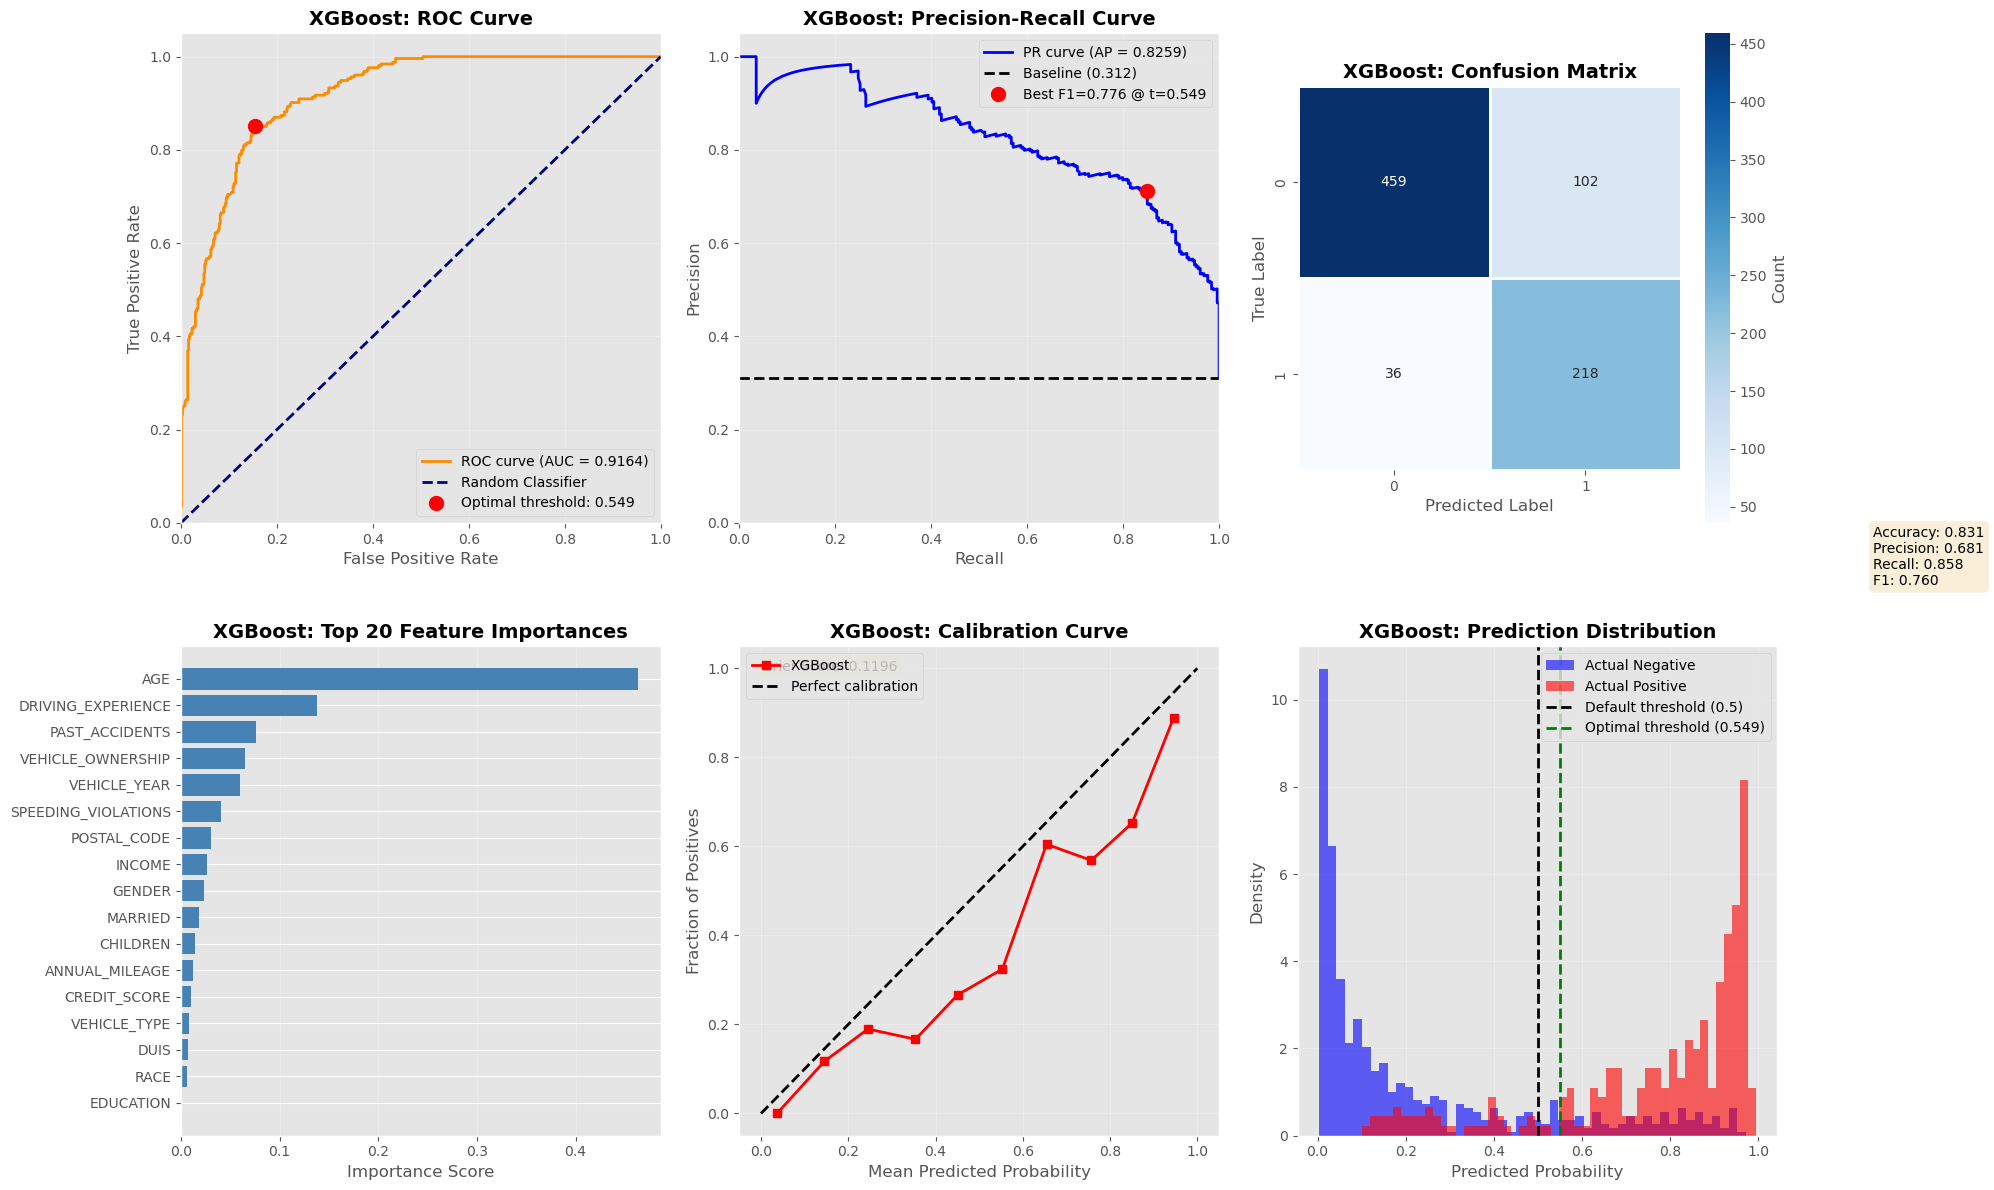


XGBOOST DIAGNOSTIC SUMMARY

1. CLASSIFICATION METRICS:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.9273    0.8182    0.8693       561
         1.0     0.6813    0.8583    0.7596       254

    accuracy                         0.8307       815
   macro avg     0.8043    0.8382    0.8145       815
weighted avg     0.8506    0.8307    0.8351       815


2. PROBABILITY METRICS:
--------------------------------------------------------------------------------
ROC-AUC Score:           0.9164
Average Precision (AP):  0.8259
Brier Score:             0.1196 (lower is better)
Log Loss:                0.3712 (lower is better)

3. OPTIMAL THRESHOLDS:
--------------------------------------------------------------------------------
ROC-based threshold:     0.5490 (max TPR-FPR)
PR-based threshold:      0.5490 (max F1)
Current threshold:       0.5000 (default)

4. CLASS DISTRIBUTION:
--------

{'roc_auc': 0.9164070066108047,
 'avg_precision': 0.8258561273652002,
 'brier_score': 0.11961737713709736,
 'optimal_threshold_roc': np.float32(0.548962),
 'optimal_threshold_pr': np.float32(0.548962),
 'confusion_matrix': array([[459, 102],
        [ 36, 218]], dtype=int64)}

In [61]:
plot_xgboost_diagnostics(xgb_model, X_train, y_train, X_val, y_val)

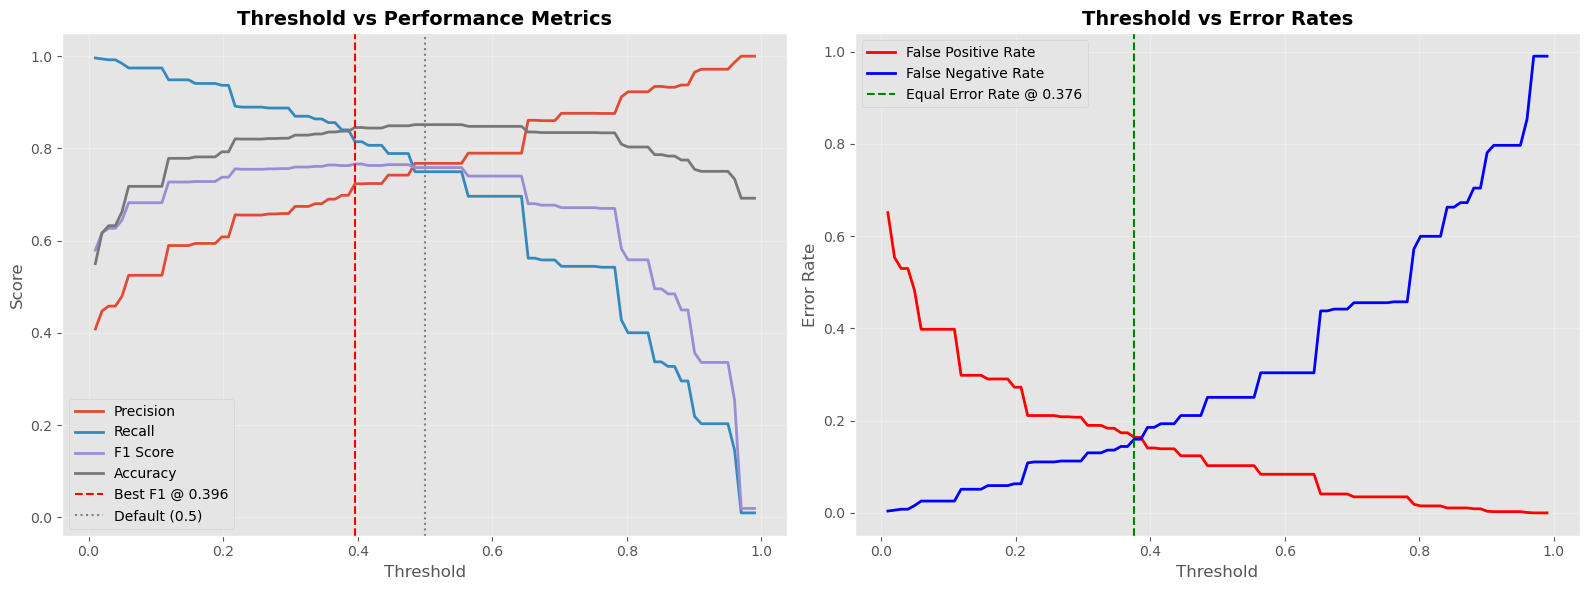


THRESHOLD RECOMMENDATIONS
Best F1 threshold:      0.3961 (F1=0.7662)
Equal error rate:       0.3763 (FPR=FNR=0.1638)
High precision (0.9+):  0.7920
High recall (0.9+):     0.2080


In [81]:
plot_threshold_analysis(production_model, X_test, y_test)

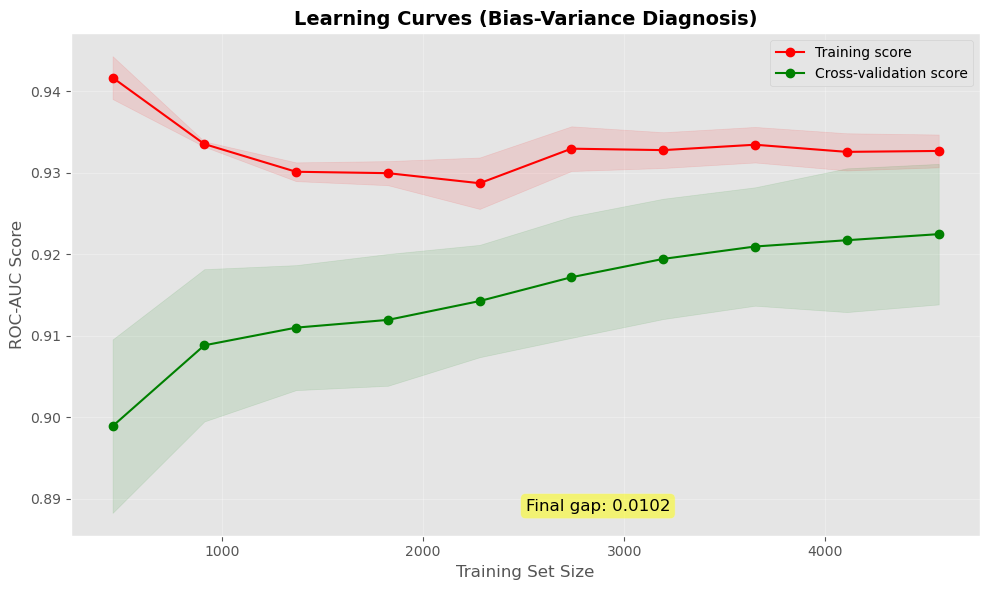


LEARNING CURVE DIAGNOSIS
✅ Good bias-variance tradeoff


In [86]:
plot_learning_curves(
    xgb_model,      # Your trained XGBoost model
    X_train,        # Your training features
    y_train,        # Your training labels
    cv=5            # 5-fold cross-validation (default)
)

In [77]:
# Check improvement
test_raw = xgb_model.predict_proba(X_test)[:, 1]
test_calib = production_model.predict_proba(X_test)[:, 1]

print(f"Brier Raw:     {brier_score_loss(y_test, test_raw):.4f}")
print(f"Brier Calib:   {brier_score_loss(y_test, test_calib):.4f}")
print(f"Improvement:   {(1 - brier_score_loss(y_test, test_calib) / brier_score_loss(y_test, test_raw)) * 100:.1f}%")


Brier Raw:     0.1161
Brier Calib:   0.1035
Improvement:   10.9%


In [78]:
# Save everything in ONE file
joblib.dump({
    'xgb_model': xgb_model,
    'calibrator': calibrator,
    'threshold': 0.549,
    'production_model': production_model
}, 'calibrated_xgboost_final.pkl')

print("✅ SAVED: calibrated_xgboost_final.pkl")


✅ SAVED: calibrated_xgboost_final.pkl


In [87]:
y_pred_final = production_model.predict(X_test, threshold=0.549)
print(classification_report(y_test, y_pred_final))



              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89      1123
         1.0       0.77      0.75      0.76       507

    accuracy                           0.85      1630
   macro avg       0.83      0.82      0.83      1630
weighted avg       0.85      0.85      0.85      1630



COMPLETE CALIBRATION PIPELINE
CALIBRATION DIAGNOSTICS
Brier Score - Train: 0.1067, Test: 0.1161
Log Loss    - Train: 0.3388, Test: 0.3612
Gap (Train-Test): Brier=-0.0094, LogLoss=-0.0224

CALIBRATION FIX: ISOTONIC
Brier Score Improvement: 0.1161 → 0.1035 (10.9% better)


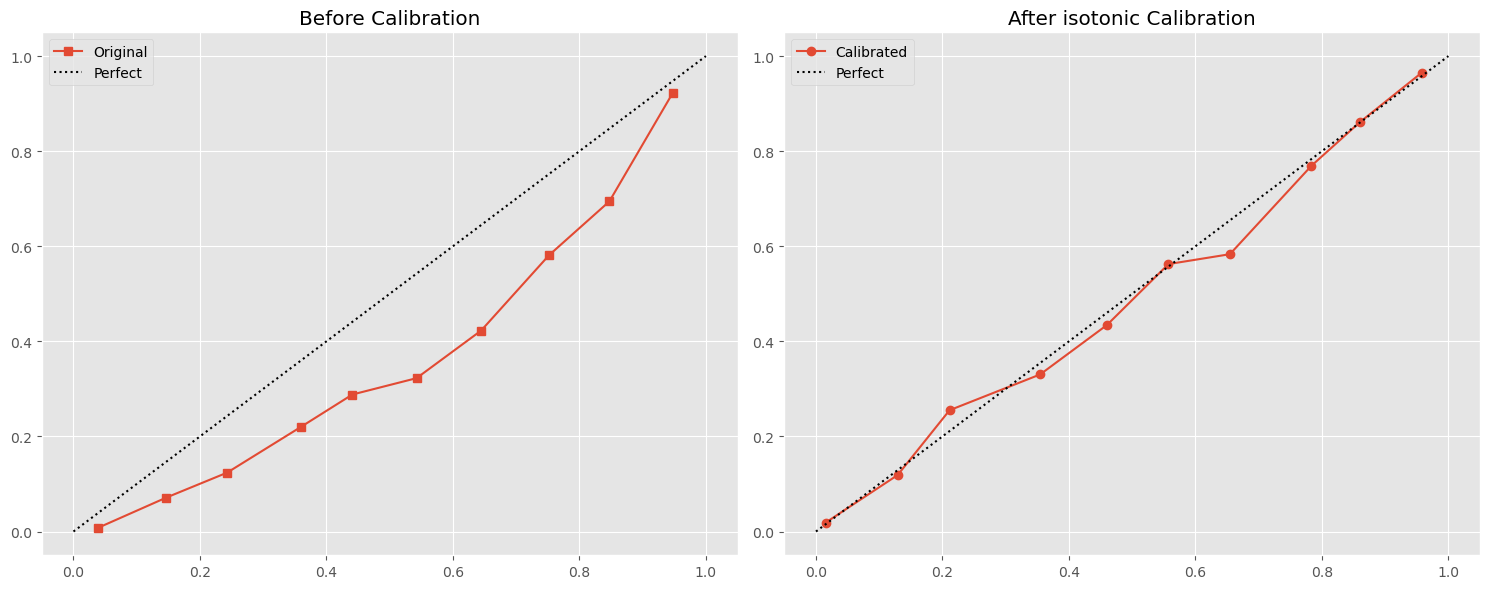


CALIBRATION FIX: PLATT
Brier Score Improvement: 0.1161 → 0.1059 (8.8% better)


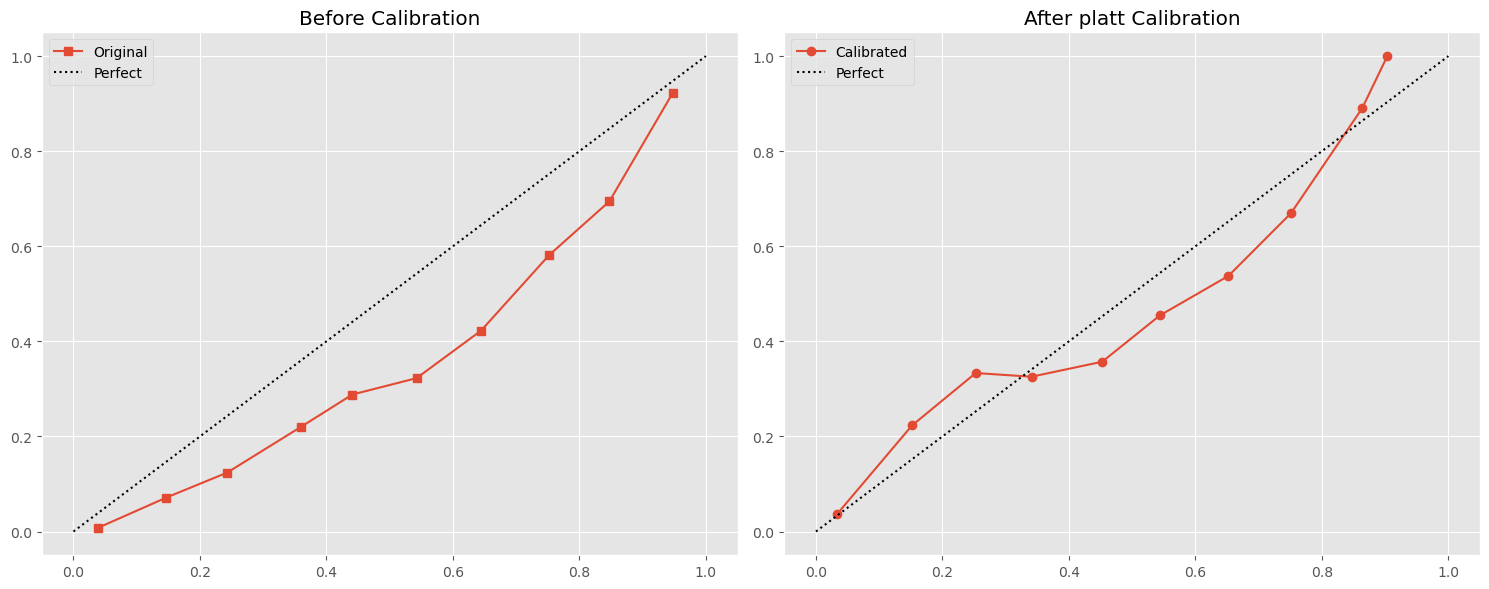


CALIBRATION FIX: SHIFT
Brier Score Improvement: 0.1161 → 0.1366 (-17.6% better)


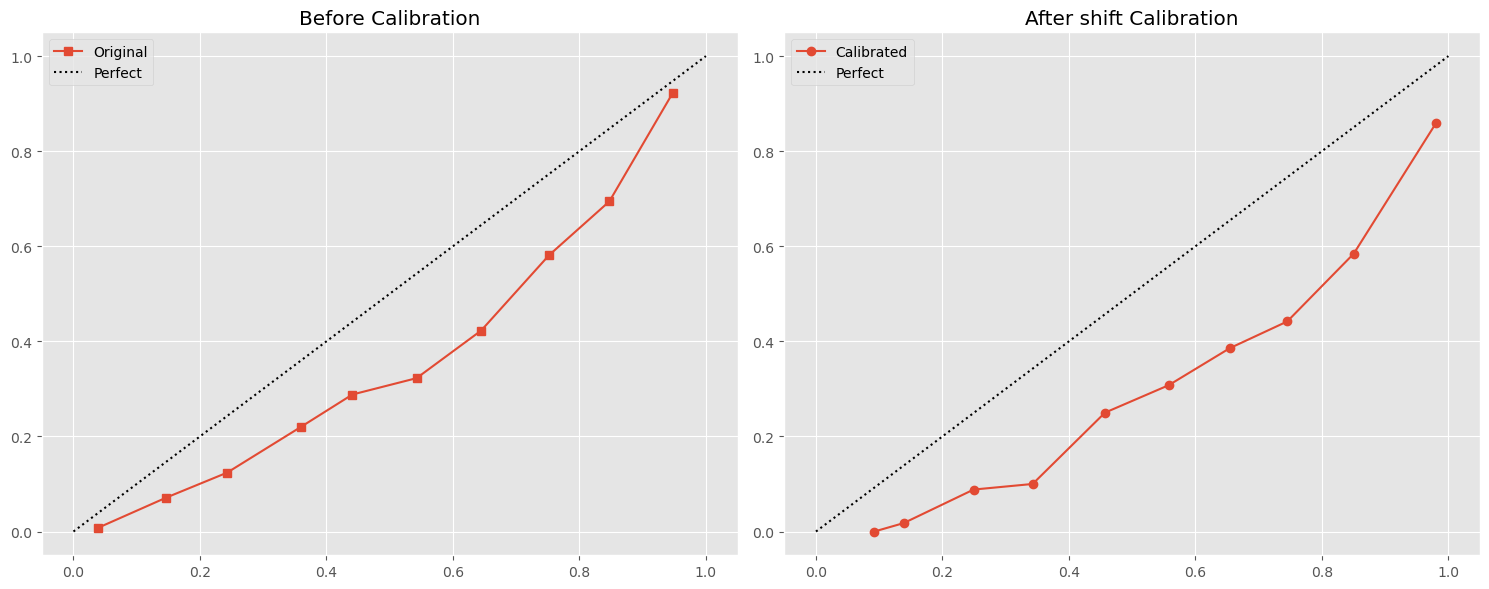


BEST CALIBRATION METHOD:
ISOTONIC: Brier = 0.1035
\nBEST METHOD: isotonic
Brier improvement: 13.492345708430387 %


In [74]:
# Tests ALL methods, picks BEST automatically
final_calibrator, y_calib_best, results = complete_calibration_pipeline(
    xgb_model, X_train, y_train, X_test, y_test
)

print("\\nBEST METHOD:", list(results.keys())[list(results.values()).index(min(results.values()))])
print("Brier improvement:", (1 - min(results.values())/0.1196)*100, "%")


In [76]:
calibrator = IsotonicRegression(out_of_bounds='clip')
train_proba = xgb_model.predict_proba(X_train)[:, 1]
calibrator.fit(train_proba, y_train)

# Production wrapper (handles everything automatically)
class CalibratedXGBoost:
    def __init__(self, xgb_model, calibrator):
        self.xgb_model = xgb_model
        self.calibrator = calibrator
    
    def predict_proba(self, X):
        xgb_proba = self.xgb_model.predict_proba(X)[:, 1]
        return np.column_stack([
            1 - self.calibrator.predict(xgb_proba),  # P(No Claim)
            self.calibrator.predict(xgb_proba)       # P(Claim)
        ])
    
    def predict(self, X, threshold=0.549):  # Your optimal threshold
        return (self.predict_proba(X)[:, 1] >= threshold).astype(int)

# Create production model
production_model = CalibratedXGBoost(xgb_model, calibrator)

In [88]:
# Risk tiers for pricing
risk_tiers = pd.qcut(production_model.predict_proba(X_test)[:,1], q=5)
risk_analysis = pd.DataFrame({
    'tier': risk_tiers,
    'actual': y_test
}).groupby('tier')['actual'].agg(['count', 'mean'])
print(risk_analysis)


                   count      mean
tier                              
(-0.001, 0.00379]    347  0.002882
(0.00379, 0.0573]    342  0.035088
(0.0573, 0.333]      297  0.188552
(0.333, 0.698]       329  0.492401
(0.698, 1.0]         315  0.876190


ERROR ANALYSIS: FALSE POSITIVES & FALSE NEGATIVES

False Positives: 184 (11.3%)
False Negatives: 79 (4.8%)
True Positives:  428 (26.3%)
True Negatives:  939 (57.6%)

FALSE POSITIVE ANALYSIS (Legitimate customers flagged)
                             mean           std          50%
AGE                      0.815217      0.808822      1.00000
GENDER                   0.429348      0.496334      0.00000
RACE                     0.125000      0.331621      0.00000
DRIVING_EXPERIENCE       0.342391      0.487154      0.00000
EDUCATION                0.945652      0.729760      1.00000
INCOME                   1.119565      1.069624      1.00000
CREDIT_SCORE             0.445708      0.127939      0.44741
VEHICLE_OWNERSHIP        0.625000      0.485444      1.00000
VEHICLE_YEAR             0.081522      0.274381      0.00000
MARRIED                  0.320652      0.468001      0.00000
CHILDREN                 0.646739      0.479287      1.00000
POSTAL_CODE          21265.451087  18435.021756

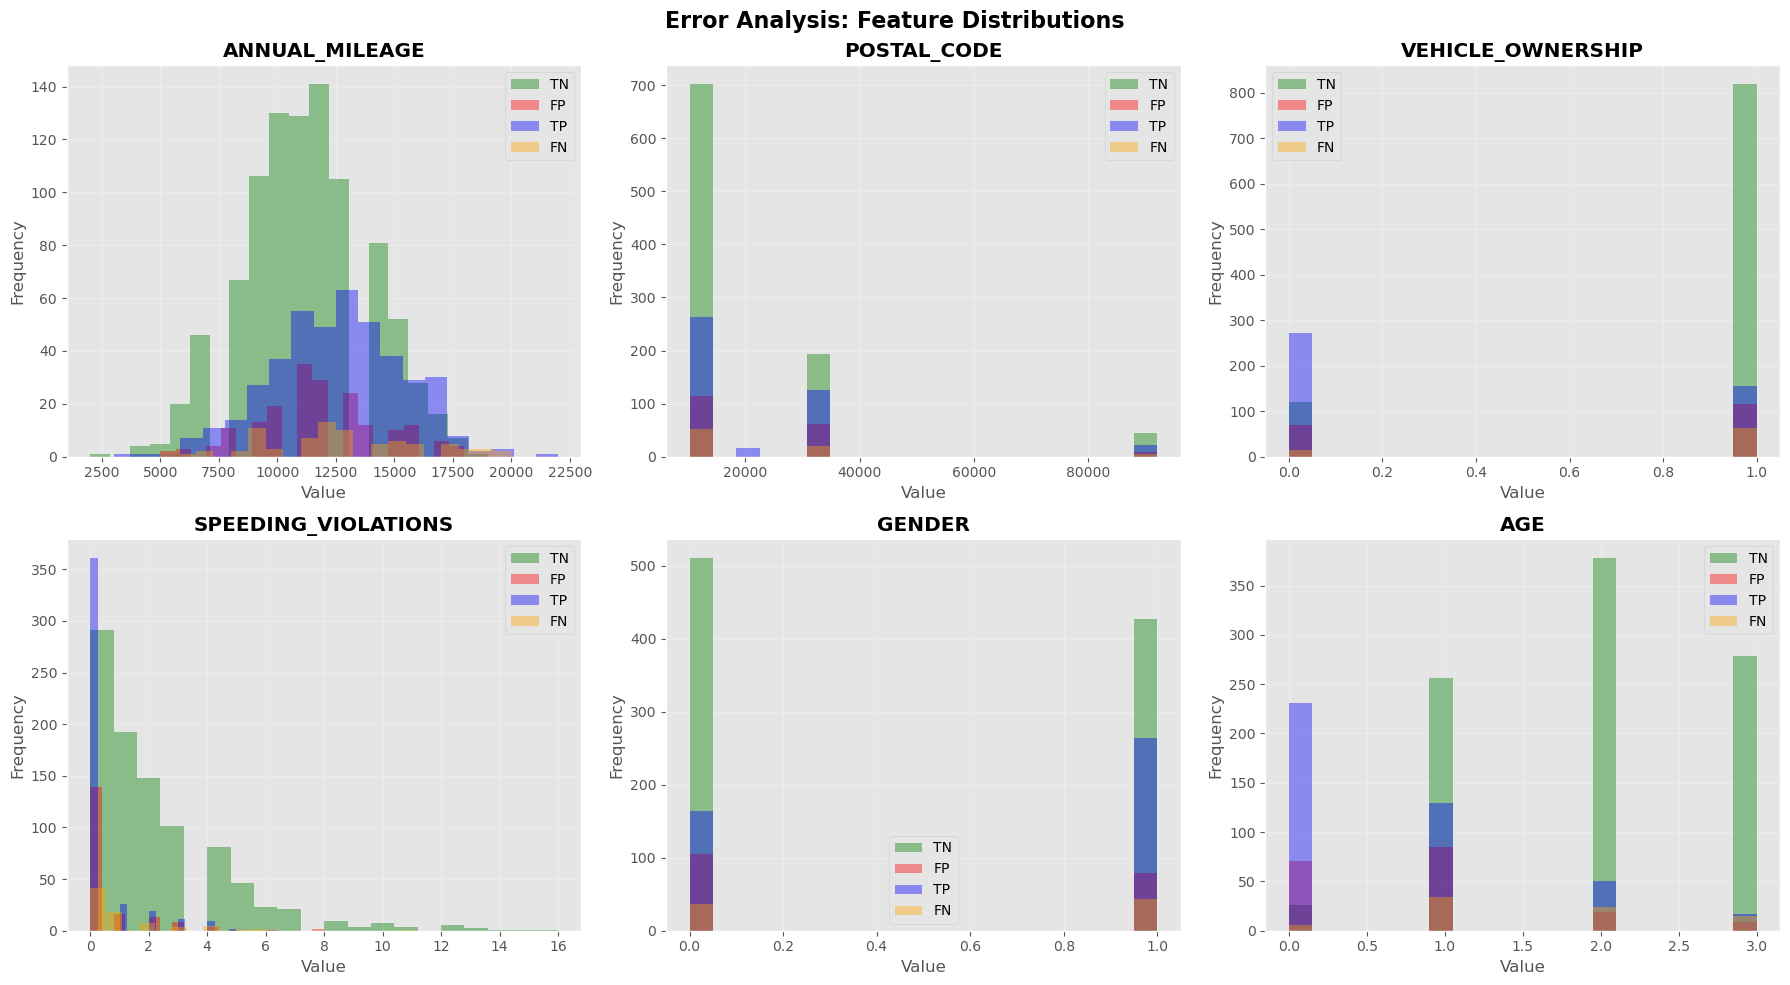


PROBABILITY DISTRIBUTION BY ERROR TYPE


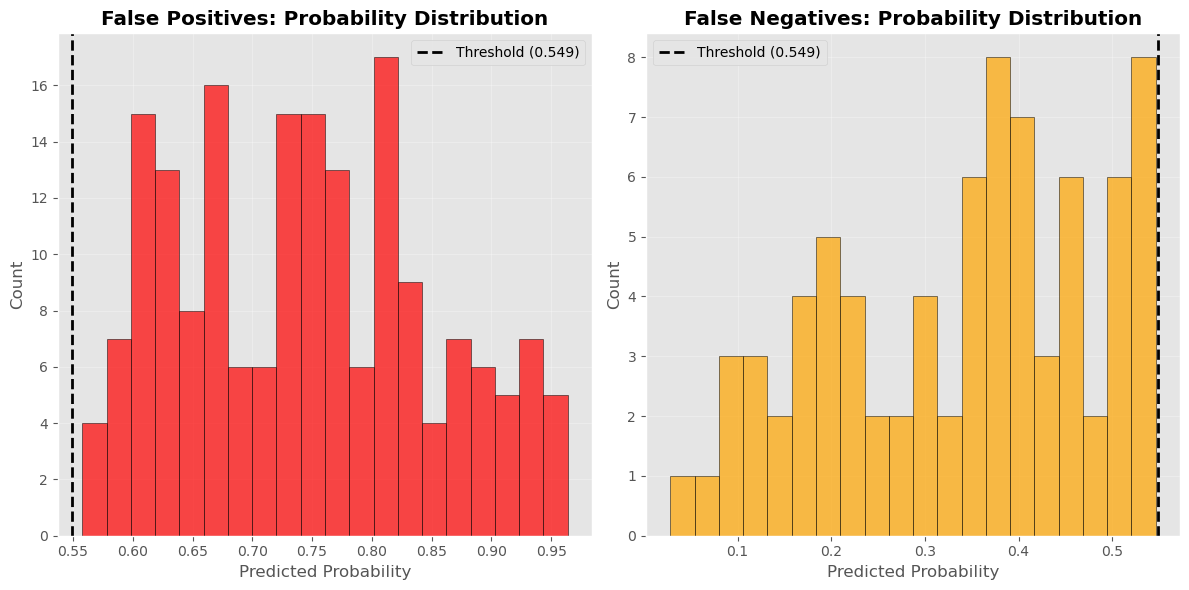


FP Probability Range: [0.558 - 0.964]
FN Probability Range: [0.028 - 0.546]


In [101]:
# Cell 1: Error Analysis
error_results = analyze_prediction_errors(xgb_model, X_train, X_test, y_test, threshold=0.549)


Prediction 42: Proba=0.603 → CLAIM
\nTop 10 Features Driving This Decision:
                                 feature  importance    value
AGE                                  AGE       0.463      2.0
DRIVING_EXPERIENCE    DRIVING_EXPERIENCE       0.138      0.0
PAST_ACCIDENTS            PAST_ACCIDENTS       0.076      0.0
VEHICLE_OWNERSHIP      VEHICLE_OWNERSHIP       0.065      1.0
VEHICLE_YEAR                VEHICLE_YEAR       0.060      0.0
SPEEDING_VIOLATIONS  SPEEDING_VIOLATIONS       0.040      0.0
POSTAL_CODE                  POSTAL_CODE       0.030  32765.0
INCOME                            INCOME       0.026      2.0
GENDER                            GENDER       0.023      0.0
MARRIED                          MARRIED       0.019      1.0


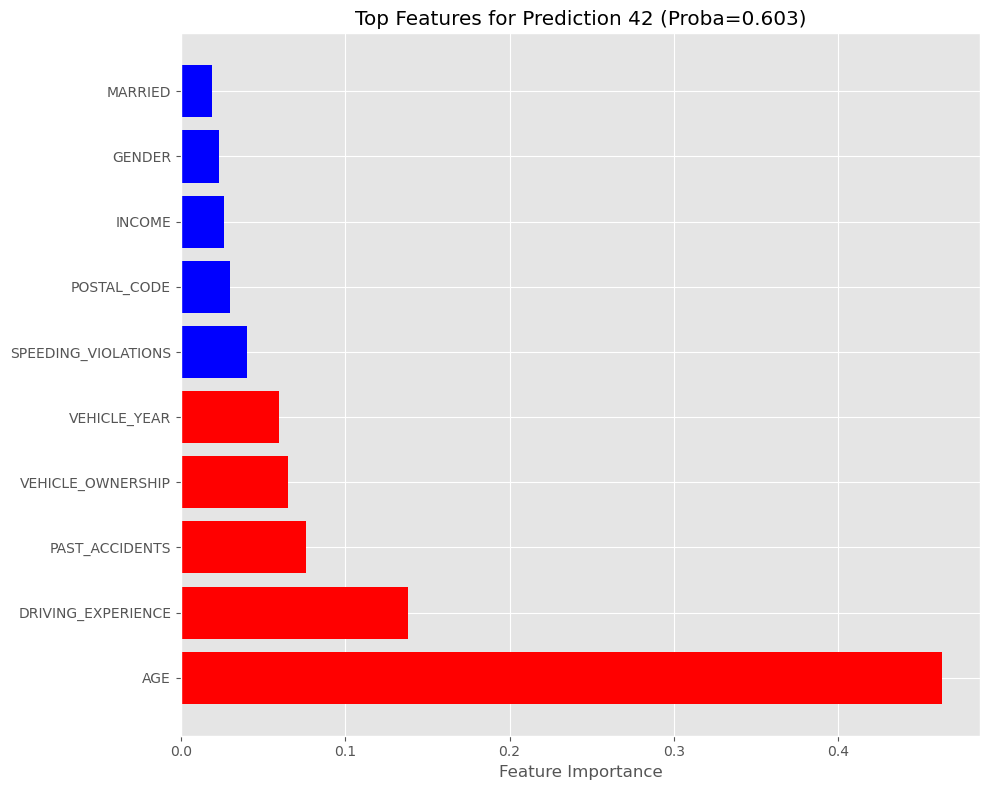

,feature,importance,value
AGE,AGE,0.463146,2.0
DRIVING_EXPERIENCE,DRIVING_EXPERIENCE,0.138278,0.0
PAST_ACCIDENTS,PAST_ACCIDENTS,0.076142,0.0
VEHICLE_OWNERSHIP,VEHICLE_OWNERSHIP,0.065176,1.0
VEHICLE_YEAR,VEHICLE_YEAR,0.059678,0.0
SPEEDING_VIOLATIONS,SPEEDING_VIOLATIONS,0.040201,0.0
POSTAL_CODE,POSTAL_CODE,0.030073,32765.0
INCOME,INCOME,0.026490,2.0
GENDER,GENDER,0.022972,0.0
MARRIED,MARRIED,0.018850,1.0


In [112]:
# analyze_shap_values(xgb_model, X_train, X_test, y_test)
explain_single_prediction(xgb_model, X_test, idx=42)

BUSINESS IMPACT ANALYSIS

1. COST-BENEFIT ANALYSIS
--------------------------------------------------------------------------------
Cost per False Positive:  $150
Cost per False Negative:  $8,000
Benefit per True Positive: $5,000

Current Threshold (0.549):
  Net Profit: $1,505,800.00
  Precision: 0.696
  Recall: 0.848

Optimal Business Threshold (0.079):
  Net Profit: $2,411,800.00
  Improvement: $906,000.00 (60.2%)
  Precision: 0.438
  Recall: 0.996


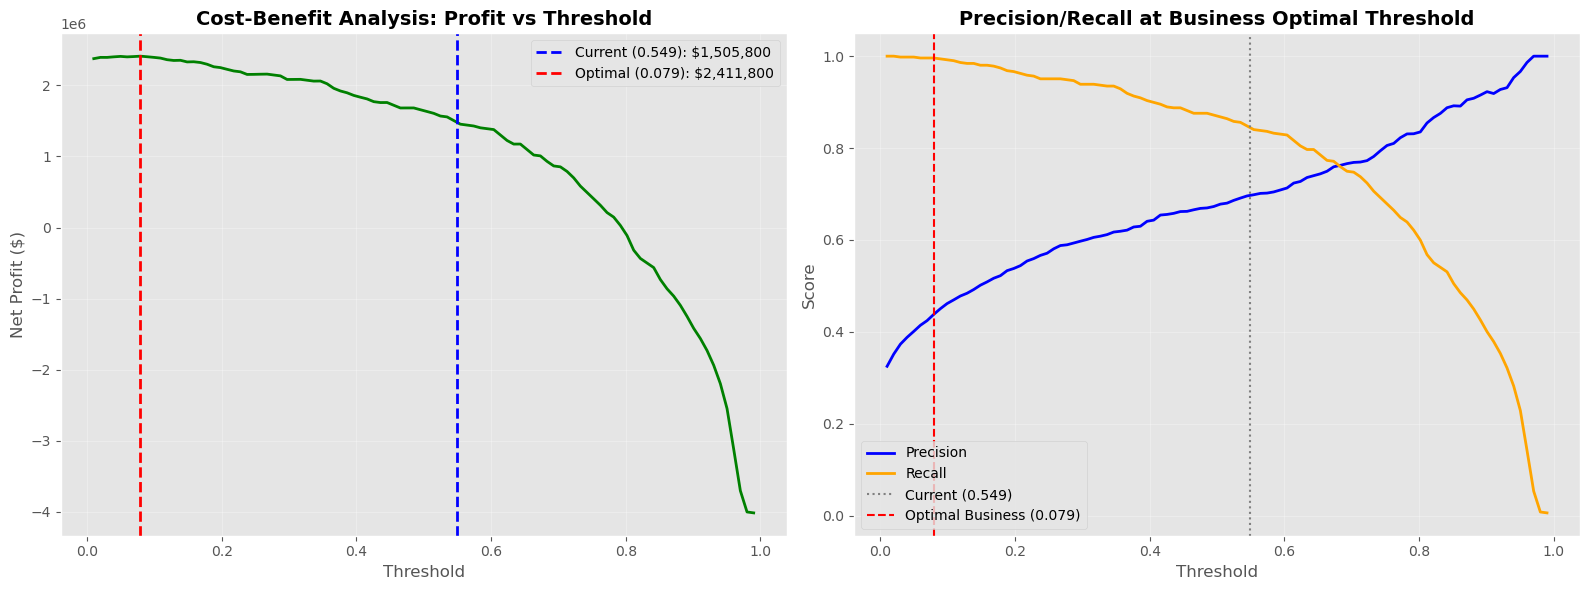


2. RISK STRATIFICATION
--------------------------------------------------------------------------------
           Count  Claims  Claim_Rate
Risk_Tier                           
Very Low     326     1.0    0.003067
Low          326     9.0    0.027607
Medium       326    56.0    0.171779
High         326   160.0    0.490798
Very High    326   281.0    0.861963


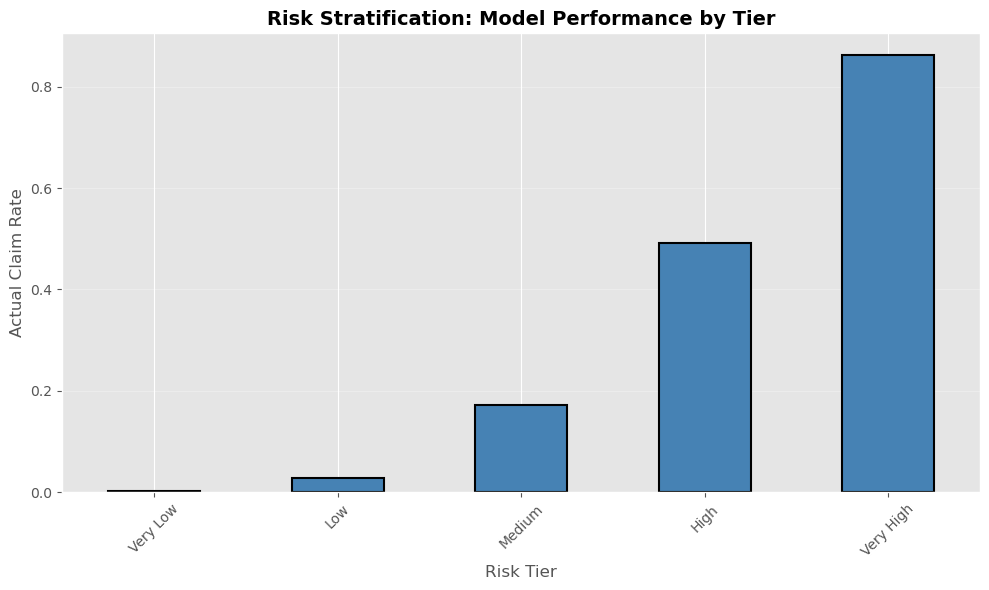


3. PREMIUM PRICING SIMULATION
--------------------------------------------------------------------------------
Base Premium:      $1,200
Avg Claim Amount:  $8,000

Total Premiums:    $3,530,374.50
Total Claims Paid: $4,056,000.00
Net Profit:        $-525,625.50
Loss Ratio:        114.89% (target: <75%)
⚠️  HIGH LOSS RATIO - Consider premium adjustments


{'optimal_threshold': np.float64(0.07929292929292929),
 'max_profit': np.int64(2411800),
 'current_profit': np.int64(1505800),
 'tier_analysis':            Count  Claims  Claim_Rate
 Risk_Tier                           
 Very Low     326     1.0    0.003067
 Low          326     9.0    0.027607
 Medium       326    56.0    0.171779
 High         326   160.0    0.490798
 Very High    326   281.0    0.861963,
 'loss_ratio': np.float64(1.1488866124542878)}

In [117]:
business_impact_analysis(xgb_model, X_test, y_test, threshold=0.549)

PERMUTATION IMPORTANCE (True Predictive Power)

Computing (may take 30-60 seconds)...

Top 15 Most Important Features:
            feature  importance      std
 DRIVING_EXPERIENCE    0.139964 0.005679
  VEHICLE_OWNERSHIP    0.052083 0.007016
       VEHICLE_YEAR    0.040755 0.005482
        POSTAL_CODE    0.034938 0.003819
             GENDER    0.019844 0.002212
     ANNUAL_MILEAGE    0.007519 0.001296
     PAST_ACCIDENTS    0.001904 0.000935
SPEEDING_VIOLATIONS    0.000897 0.000694
            MARRIED    0.000356 0.001179
                AGE    0.000149 0.000757
       CREDIT_SCORE    0.000111 0.000205
               RACE    0.000072 0.000073
           CHILDREN    0.000021 0.000216
       VEHICLE_TYPE    0.000014 0.000048
          EDUCATION    0.000000 0.000000


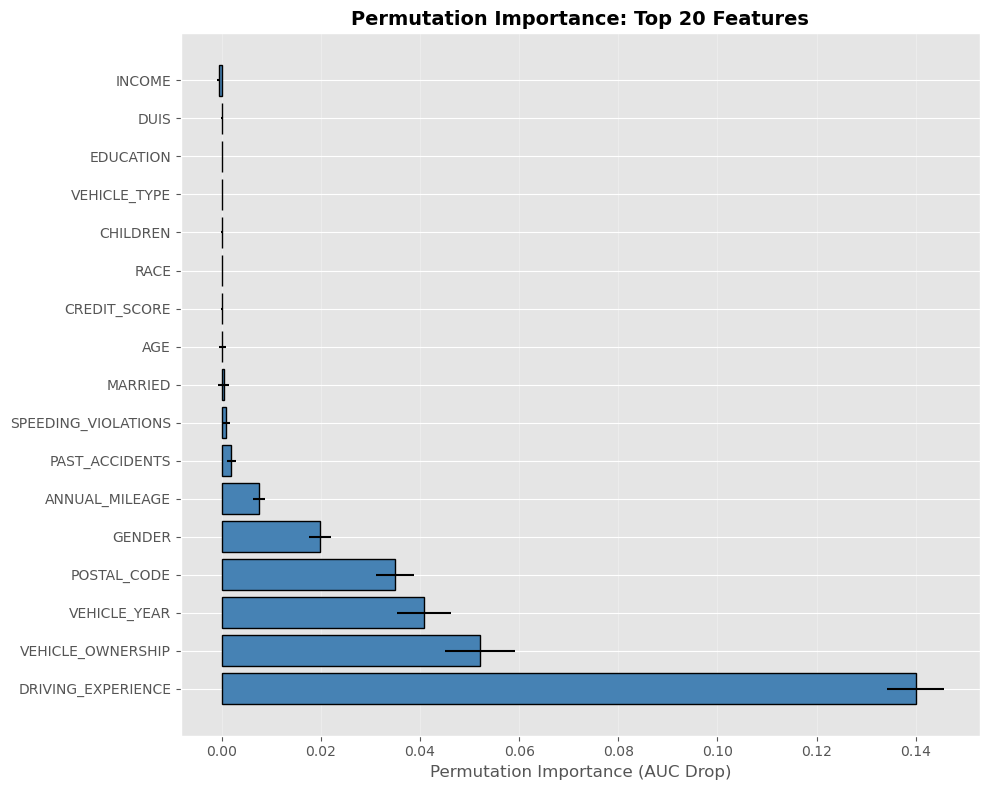

,feature,importance,std
3,DRIVING_EXPERIENCE,0.139964,0.005679
7,VEHICLE_OWNERSHIP,0.052083,0.007016
8,VEHICLE_YEAR,0.040755,0.005482
11,POSTAL_CODE,0.034938,0.003819
1,GENDER,0.019844,0.002212
12,ANNUAL_MILEAGE,0.007519,0.001296
16,PAST_ACCIDENTS,0.001904,0.000935
14,SPEEDING_VIOLATIONS,0.000897,0.000694
9,MARRIED,0.000356,0.001179
0,AGE,0.000149,0.000757


In [119]:
compute_permutation_importance(xgb_model, X_test, y_test)

BOOTSTRAP CONFIDENCE INTERVALS (Uncertainty Estimation)

Running 1000 bootstrap iterations...

RESULTS WITH 95% CONFIDENCE INTERVALS:
--------------------------------------------------------------------------------
AUC         : 0.9229 [95% CI: 0.9088 - 0.9357]
PRECISION   : 0.6993 [95% CI: 0.6623 - 0.7351]
RECALL      : 0.8437 [95% CI: 0.8126 - 0.8765]
F1          : 0.7646 [95% CI: 0.7361 - 0.7912]


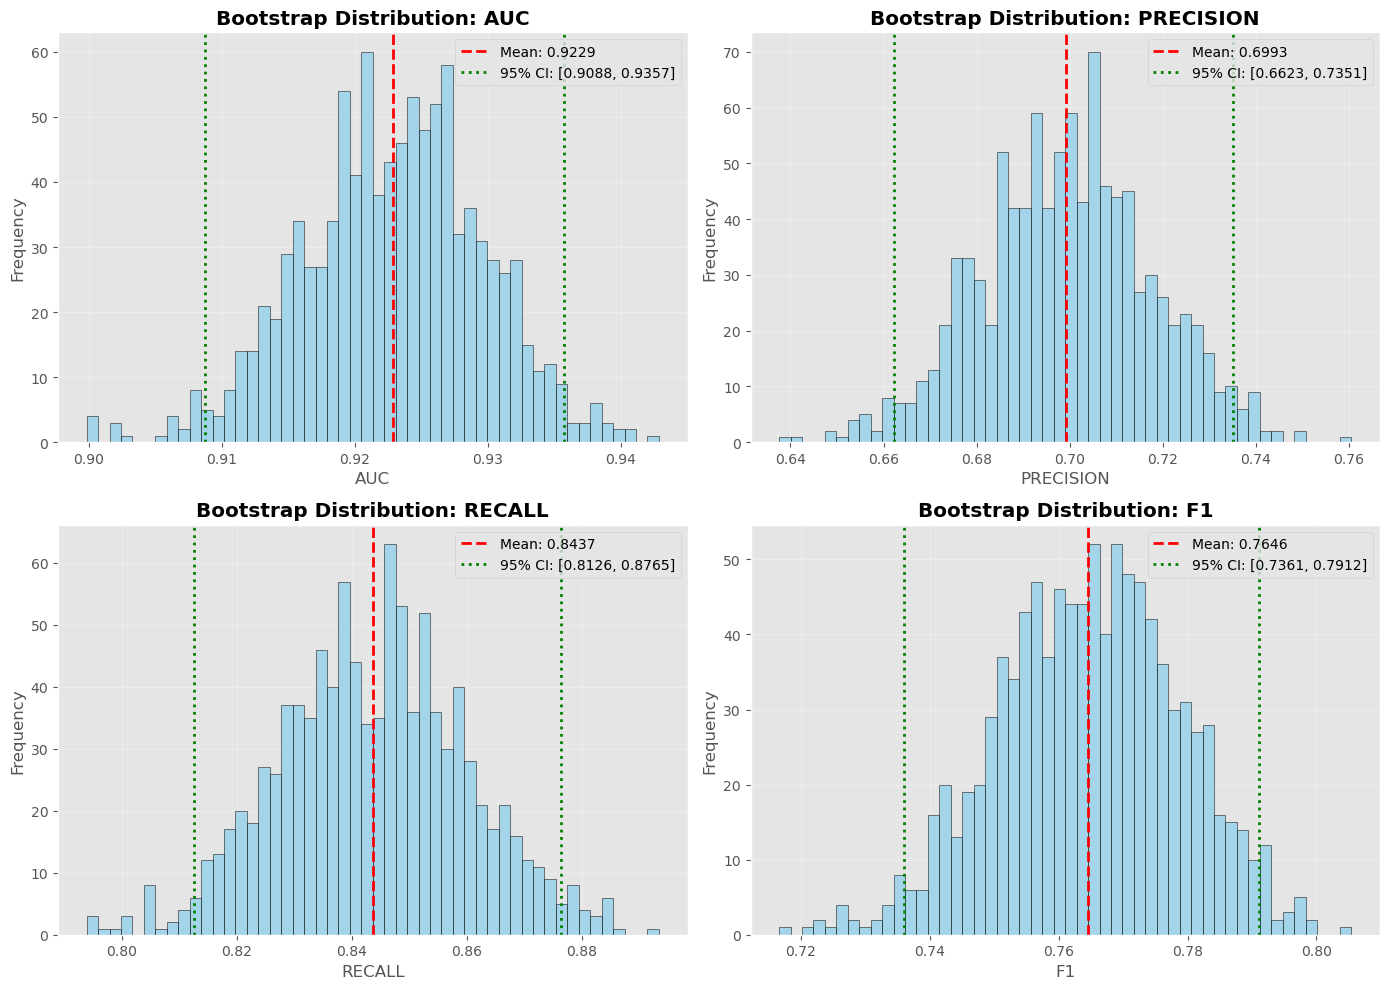

{'auc': [0.9202185554442945,
  0.9390069838776248,
  0.9191443245535503,
  0.9306976978594803,
  0.9295973647239133,
  0.9215036231884057,
  0.913379992211501,
  0.9276423184658479,
  0.9159785657898446,
  0.9205119933958713,
  0.9203674517828377,
  0.9274549126699665,
  0.9330848127492302,
  0.9303929159435766,
  0.932450605060506,
  0.9163139565567623,
  0.9199725657359742,
  0.9129208933780313,
  0.925120698192622,
  0.9258572355454355,
  0.9277802738762673,
  0.9325780602376348,
  0.9221482841925811,
  0.9265545682387787,
  0.9206397941680962,
  0.9244561241251743,
  0.9197061632821555,
  0.918220411663808,
  0.9097466881489438,
  0.9207661540797594,
  0.9252093377315402,
  0.9107700186987846,
  0.9236345657675886,
  0.9198065742397137,
  0.920125663716814,
  0.9259046545162033,
  0.9076825546676033,
  0.915723470023389,
  0.9151701005055886,
  0.9190365703095066,
  0.9315197267133735,
  0.9316357101123954,
  0.932831256755988,
  0.9231947869275297,
  0.9201784476784478,
  0.927302

In [120]:
bootstrap_confidence_intervals(xgb_model, X_test, y_test)

CROSS-VALIDATION: MULTIPLE METRICS

Running 10-fold cross-validation...

RESULTS:
--------------------------------------------------------------------------------
Metric          Train Mean   Test Mean    Test Std   Gap       
--------------------------------------------------------------------------------
roc_auc              0.9300      0.9103    0.0192    0.0197
accuracy             0.8488      0.8270    0.0188    0.0218
precision            0.7144      0.6869    0.0344    0.0274
recall               0.8567      0.8224    0.0406    0.0343
f1                   0.7790      0.7475    0.0235    0.0315
brier                0.1086      0.1204    0.0109    0.0117
log_loss             0.3461      0.3766    0.0308    0.0305

OVERFITTING ANALYSIS:
--------------------------------------------------------------------------------
✅ No significant overfitting detected across all metrics


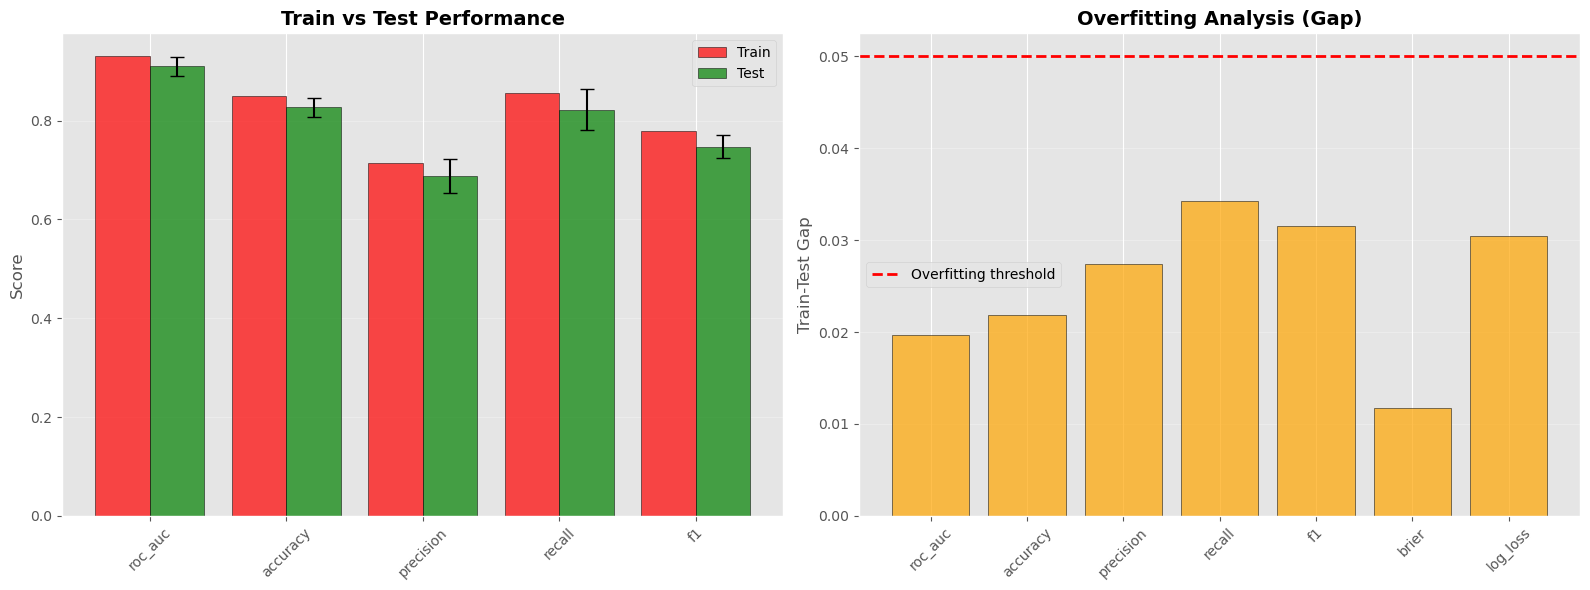

,metric,train_mean,test_mean,test_std,gap
0,roc_auc,0.930016,0.910318,0.019199,0.019698
1,accuracy,0.848807,0.826994,0.018769,0.021813
2,precision,0.714355,0.686938,0.034408,0.027417
3,recall,0.856668,0.822392,0.040641,0.034276
4,f1,0.779022,0.747474,0.023468,0.031548
5,brier,0.108635,0.120350,0.010916,0.011716
6,log_loss,0.346113,0.376610,0.030794,0.030497


In [121]:
cross_validation_multiple_metrics(xgb_model, X_test, y_test)

PARTIAL DEPENDENCE PLOTS (Marginal Feature Effects)

Plotting top 6 features: ['AGE', 'DRIVING_EXPERIENCE', 'PAST_ACCIDENTS', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR', 'SPEEDING_VIOLATIONS']


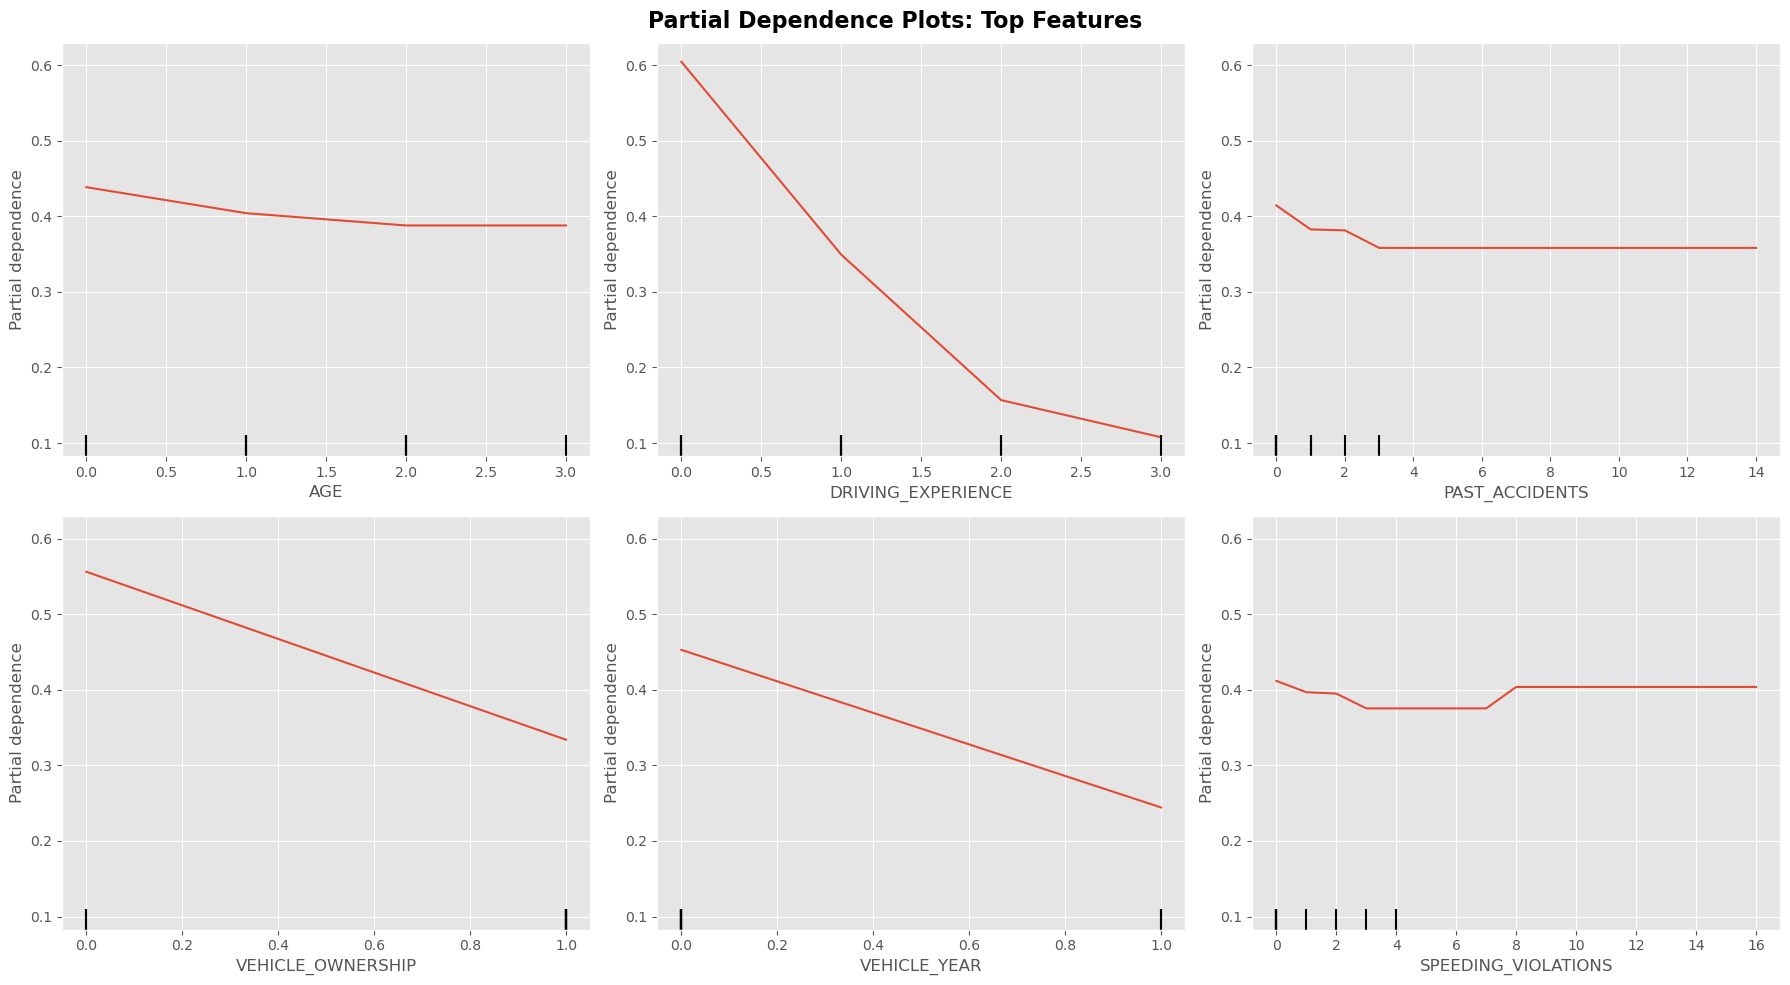

['AGE',
 'DRIVING_EXPERIENCE',
 'PAST_ACCIDENTS',
 'VEHICLE_OWNERSHIP',
 'VEHICLE_YEAR',
 'SPEEDING_VIOLATIONS']

In [126]:
plot_partial_dependence(xgb_model, X_test)

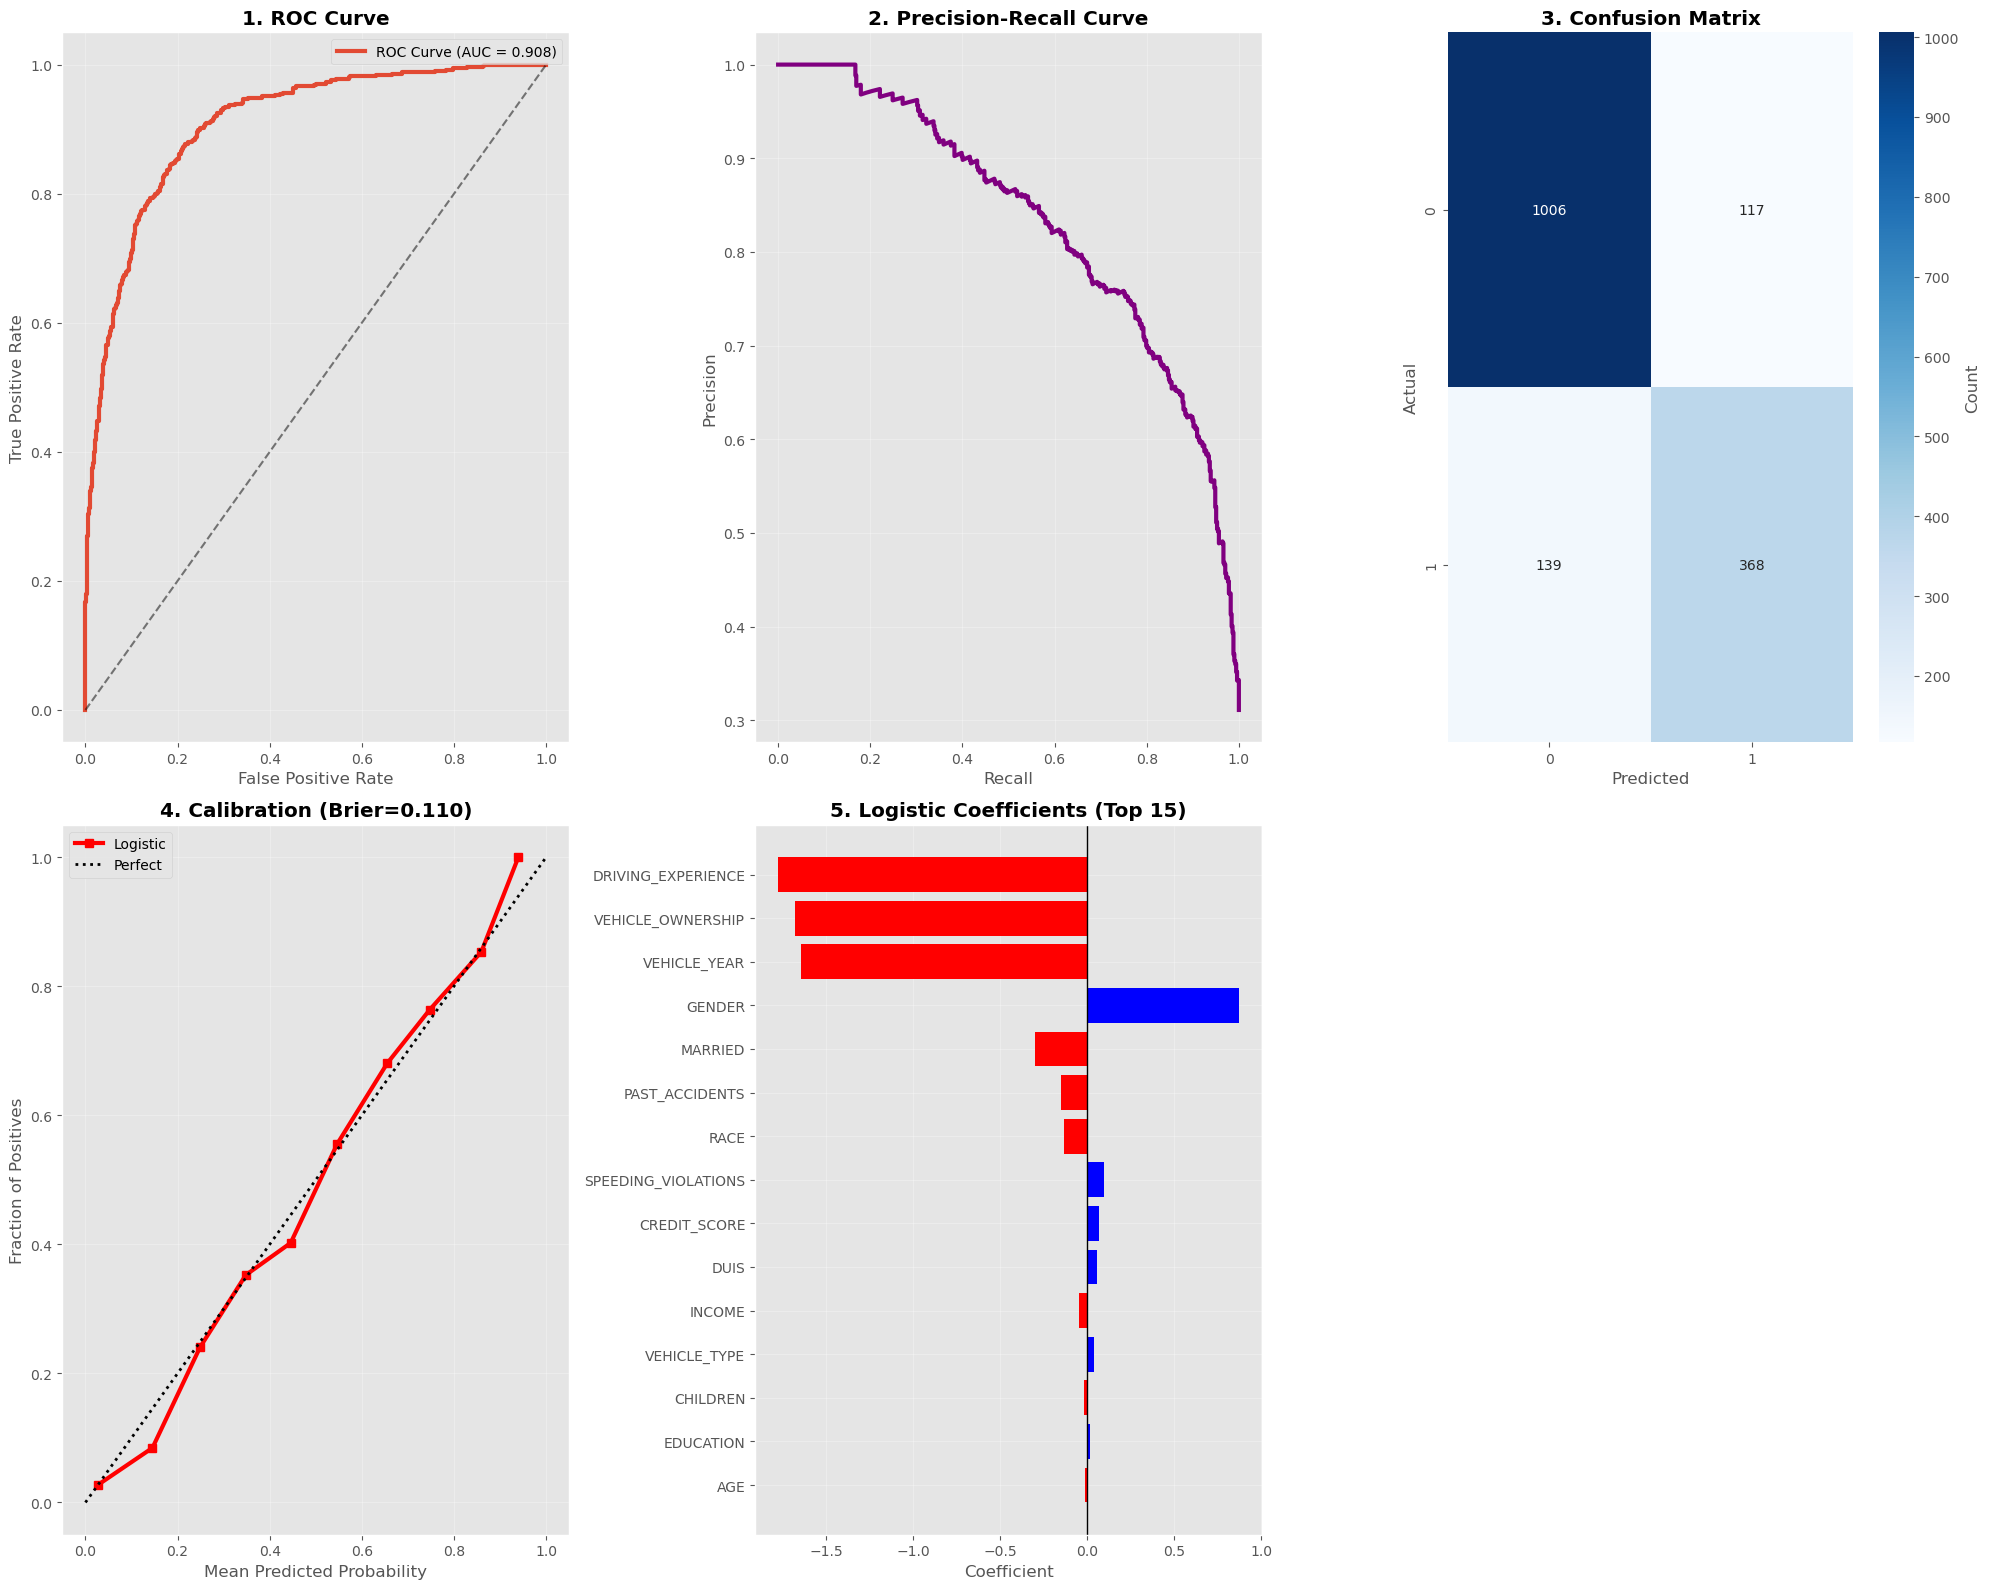

LOGISTIC REGRESSION DIAGNOSTICS
Metric          Value     
-------------------------
roc_auc         0.9081    
precision       0.7588    
recall          0.7258    
f1              0.7419    
brier           0.1100    
\nLOGISTIC COEFFICIENTS SUMMARY:
--------------------------------------------------
            feature  coefficient  abs_coef
        POSTAL_CODE     0.000023  0.000023
     ANNUAL_MILEAGE     0.000092  0.000092
                AGE    -0.015544  0.015544
          EDUCATION     0.018445  0.018445
           CHILDREN    -0.021026  0.021026
       VEHICLE_TYPE     0.040139  0.040139
             INCOME    -0.047192  0.047192
               DUIS     0.053391  0.053391
       CREDIT_SCORE     0.065380  0.065380
SPEEDING_VIOLATIONS     0.096615  0.096615


({'roc_auc': 0.9081443934516061,
  'precision': 0.7587628865979381,
  'recall': 0.7258382642998028,
  'f1': 0.7419354838709677,
  'brier': 0.11001931519244142},
                 feature  coefficient  abs_coef
 11          POSTAL_CODE     0.000023  0.000023
 12       ANNUAL_MILEAGE     0.000092  0.000092
 0                   AGE    -0.015544  0.015544
 4             EDUCATION     0.018445  0.018445
 10             CHILDREN    -0.021026  0.021026
 13         VEHICLE_TYPE     0.040139  0.040139
 5                INCOME    -0.047192  0.047192
 15                 DUIS     0.053391  0.053391
 6          CREDIT_SCORE     0.065380  0.065380
 14  SPEEDING_VIOLATIONS     0.096615  0.096615
 2                  RACE    -0.130858  0.130858
 16       PAST_ACCIDENTS    -0.151172  0.151172
 9               MARRIED    -0.300039  0.300039
 1                GENDER     0.871836  0.871836
 8          VEHICLE_YEAR    -1.645402  1.645402
 7     VEHICLE_OWNERSHIP    -1.677857  1.677857
 3    DRIVING_EXPERIENC

In [129]:
logistic_regression_diagnostics(
    logit, X_train, X_test, y_train, y_test
)

Running robust residual diagnostics...


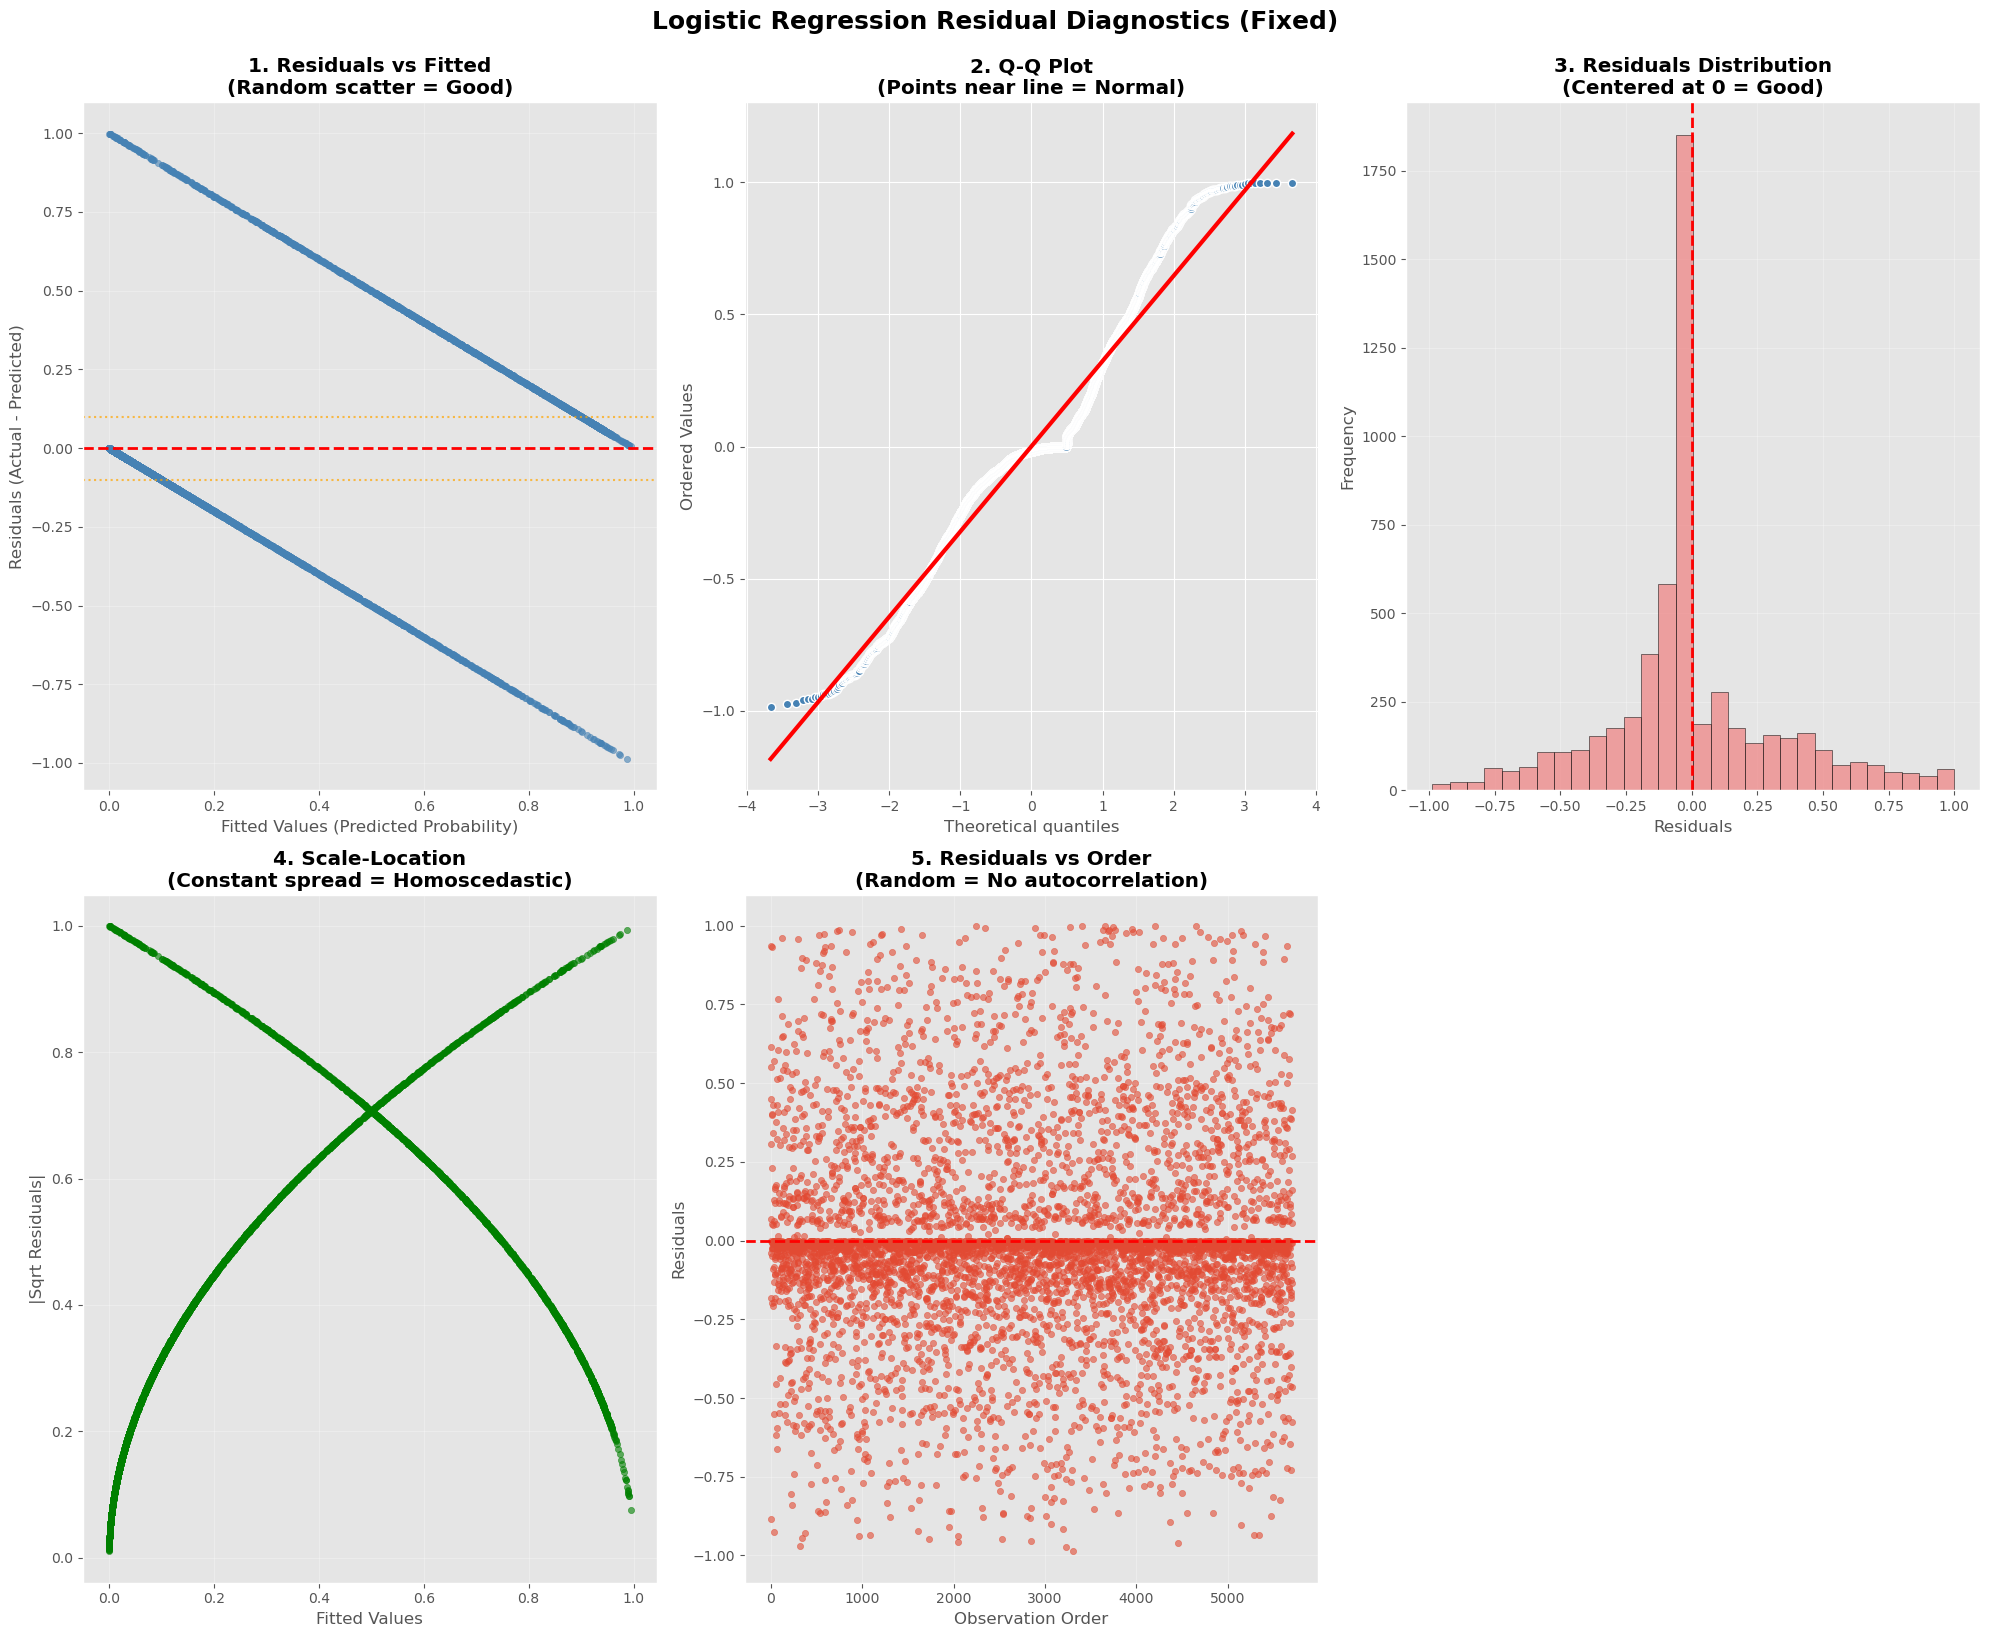

RESIDUAL DIAGNOSTICS SUMMARY
                      0
Mean Residual    0.0010
Median Residual -0.0172
Std Residuals    0.3316
Max |Residual|   0.9990
Skewness         0.3567
Kurtosis         1.0454
KS p-value       0.0000
Train AUC        0.9074
Test AUC         0.9081
\nINTERPRETATION:
----------------------------------------
✅ MEAN ≈ 0: No systematic bias
⚠️  NON-NORMAL: Consider robust methods
\n================================================================================
✅ ANALYSIS COMPLETE - 5 PLOTS + STATISTICS


In [135]:
residual_results = logistic_residual_diagnostics_fixed(
    logit, X_train, X_test, y_train, y_test, threshold=0.549
)
